In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import colors as mcolors
from networkx.algorithms import community

os.makedirs("outputs/plots", exist_ok=True)

# Load CSVs

In [3]:
edges = pd.read_csv("python_dependencies_edges.csv")
edges['source'] = edges['source'].str.lower()
edges['target'] = edges['target'].str.lower()

timeline = pd.read_csv("outputs/top_pypi_snyk_timeline_20221112_20251112.csv")
timeline['package'] = timeline['package'].astype(str).str.lower()


# Build Graphs

In [12]:
# remove self-loops do grafo não-direcionado
UG_clean = UG.copy()
UG_clean.remove_edges_from(nx.selfloop_edges(UG_clean))

print("Nodes (UG_clean):", UG_clean.number_of_nodes())
print("Edges (UG_clean):", UG_clean.number_of_edges())

Nodes (UG_clean): 1547
Edges (UG_clean): 3444


# Compute metrics

In [13]:
deg = dict(DG.in_degree())  # in-degree continua no grafo dirigido

# betweenness no grafo sem self-loop
bet = nx.betweenness_centrality(UG_clean, normalized=True)

try:
    eig = nx.eigenvector_centrality(UG_clean, max_iter=1000)
except nx.PowerIterationFailedConvergence:
    # fallback mais robusto
    eig = nx.eigenvector_centrality_numpy(UG_clean)

core = nx.core_number(UG_clean)

# garante que estamos iterando sobre os mesmos nós
nodes = list(DG.nodes())

metrics = pd.DataFrame({
    "package": nodes,
    "in_degree": [deg.get(n, 0) for n in nodes],
    "betweenness": [bet.get(n, 0.0) for n in nodes],
    "eigenvector": [eig.get(n, 0.0) for n in nodes],
    "kcore": [core.get(n, 0) for n in nodes],
})

metrics.to_csv("outputs/plots/centrality_metrics.csv", index=False)

# Community Detection

In [14]:
comms = list(community.greedy_modularity_communities(UG))
comms = sorted(comms, key=len, reverse=True)

# create label map
cluster_map = {}
for i, c in enumerate(comms):
    for n in c:
        cluster_map[n] = f"C{i+1}"

# Build Halo Plot 

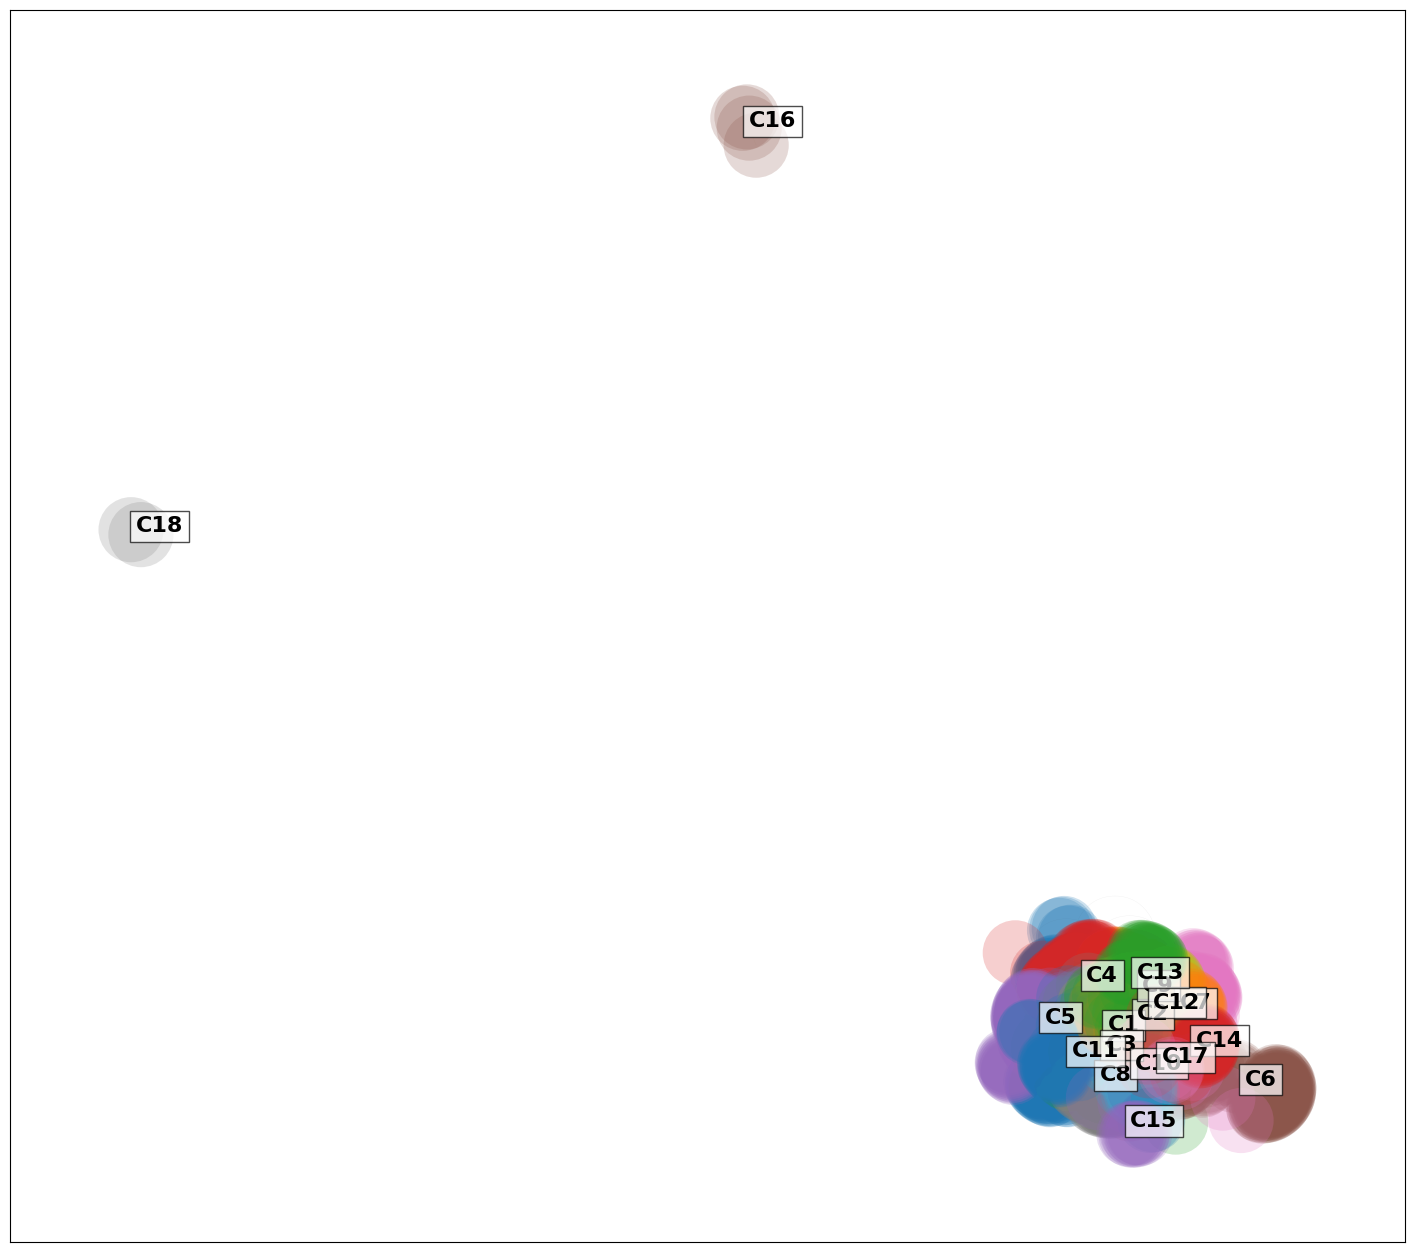

In [15]:
k = 1 / np.sqrt(max(UG.number_of_nodes(), 1))
pos = nx.spring_layout(UG, k=k*3, iterations=350, seed=42)

# color settings
base_colors = list(mcolors.TABLEAU_COLORS.values()) 
halo_size = 2200

fig, ax = plt.subplots(figsize=(18,16))

# draw edges
nx.draw_networkx_edges(UG, pos, ax=ax, alpha=0.12, edge_color="gray", width=0.25)

# draw community halos
handles = []
for i, comm in enumerate(comms):
    comm_color = mcolors.to_rgba(base_colors[i % len(base_colors)], alpha=0.22)
    nodes = list(comm)
    nx.draw_networkx_nodes(
        UG, pos, nodelist=nodes, 
        node_size=halo_size, 
        node_color=[comm_color]*len(nodes),
        ax=ax, edgecolors="none"
    )
    cx = np.mean([pos[n][0] for n in nodes])
    cy = np.mean([pos[n][1] for n in nodes])
    ax.text(cx, cy, f"C{i+1}", fontsize=16, fontweight="bold",
            bbox=dict(facecolor="white", alpha=0.7))

    handles.append(Patch(facecolor=comm_color, label=f"Cluster C{i+1}"))


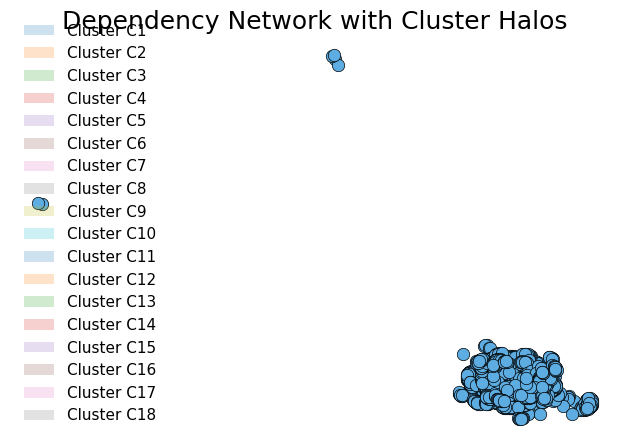

In [16]:
# main nodes
nx.draw_networkx_nodes(
    UG, pos, node_size=80, node_color="#5dade2",
    edgecolors="black", linewidths=0.5
)

plt.legend(handles=handles, loc="lower left", frameon=False, fontsize=11)
plt.title("Dependency Network with Cluster Halos", fontsize=18)
plt.axis("off")
plt.tight_layout()
plt.savefig("outputs/plots/dependency_network_clusters.png", dpi=300)
plt.show()

# SIMULAÇÃO SIS NA REDE DE DEPENDÊNCIAS

In [21]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

os.makedirs("outputs/plots", exist_ok=True)

UG = UG_clean.copy()

# Remover self-loops para k-core e métricas
UG.remove_edges_from(nx.selfloop_edges(UG))

# Dataset temporal Snyk
timeline = pd.read_csv("outputs/top_pypi_snyk_timeline_20221112_20251112.csv")
timeline['package'] = timeline['package'].astype(str).str.lower()
timeline['disclosed_date'] = pd.to_datetime(timeline['disclosed_date'], errors='coerce')
timeline['mitigation_date'] = pd.to_datetime(timeline['mitigation_date'], errors='coerce')

# Dataset temporal real (observação)
snap = pd.read_csv("temporal_ai_snapshots.csv")
snap['time'] = pd.to_datetime(snap['time'], errors='coerce')


In [22]:
def active_packages_at(t, graph_nodes=None):
    t = pd.to_datetime(t)

    df = timeline[
        (timeline['disclosed_date'] <= t) &
        (
            timeline['mitigation_date'].isna() |
            (timeline['mitigation_date'] > t)
        )
    ]
    pkgs = set(df['package'])

    if graph_nodes is not None:
        pkgs = {p for p in pkgs if p in graph_nodes}

    return pkgs


In [23]:
t0 = "2025-01-01"

active_set = active_packages_at(t0, graph_nodes=set(DG.nodes()))
print(f"Pacotes vulneráveis ativos em {t0}: {len(active_set)}")


Pacotes vulneráveis ativos em 2025-01-01: 30


In [24]:
def simulate_SIS(G, beta=0.3, mu=0.1, steps=40, initial_infected=None, seed=42):
    rng = np.random.default_rng(seed)
    nodes = list(G.nodes())
    infected = {n: False for n in nodes}
    
    if initial_infected:
        for n in initial_infected:
            if n in infected:
                infected[n] = True

    history = []

    for t in range(steps):
        new_state = infected.copy()

        for n in nodes:
            if infected[n]:  
                if rng.random() < mu:
                    new_state[n] = False
            else:
                for neigh in G.predecessors(n):
                    if infected[neigh] and rng.random() < beta:
                        new_state[n] = True
                        break

        infected = new_state
        history.append(infected.copy())

    return history

sis_history = simulate_SIS(
    DG,
    beta=0.28,
    mu=0.12,
    steps=40,
    initial_infected=active_set,
    seed=123
)

infected_counts = [sum(1 for v in state.values() if v) for state in sis_history]


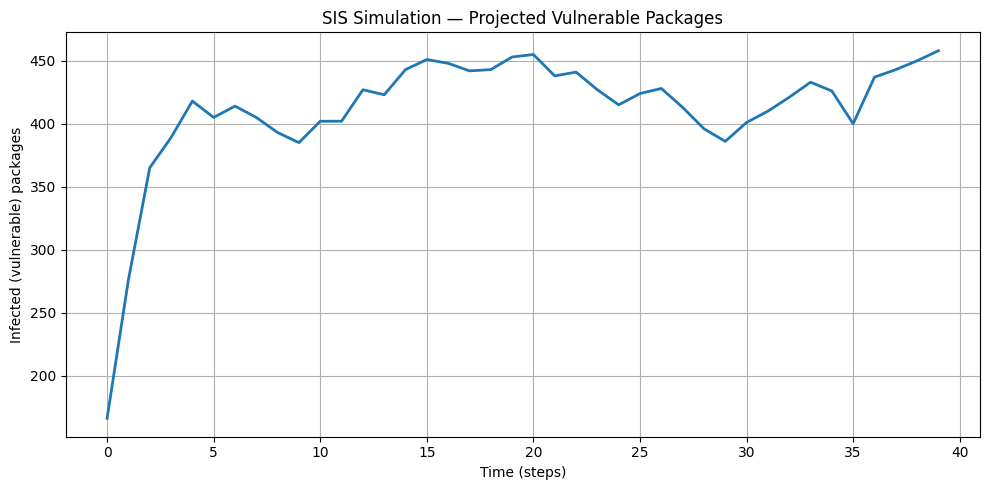

In [25]:
plt.figure(figsize=(10,5))
plt.plot(infected_counts, linewidth=2)
plt.title("SIS Simulation — Projected Vulnerable Packages")
plt.xlabel("Time (steps)")
plt.ylabel("Infected (vulnerable) packages")
plt.grid(True)
plt.tight_layout()
plt.savefig("outputs/plots/sis_projection.png", dpi=300)
plt.show()


# Alinhamento “simulação vs real”

# PREDIÇÃO TEMPORAL (HOTSPOTS)

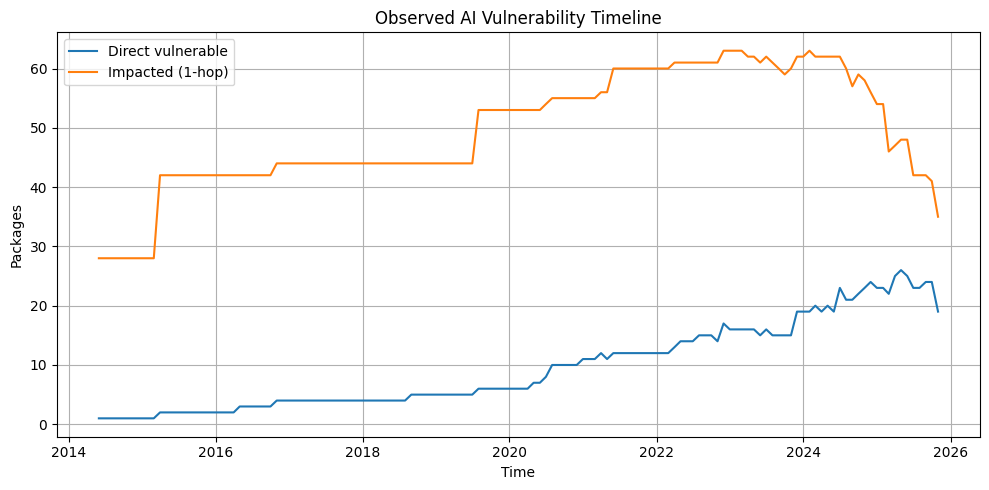

In [26]:
plt.figure(figsize=(10,5))
plt.plot(snap['time'], snap['n_direct'], label='Direct vulnerable')
plt.plot(snap['time'], snap['n_impacted'], label='Impacted (1-hop)')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Packages")
plt.title("Observed AI Vulnerability Timeline")
plt.grid(True)
plt.tight_layout()
plt.savefig("outputs/plots/temporal_ai_snapshots.png", dpi=300)
plt.show()


# HOTSPOT PREDICTOR — quais libs sofrerão vulnerabilidade

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------
# Normalizar eigenvector para usar no risco
# -----------------------------------------
max_eig = metrics["eigenvector"].max()
if max_eig == 0 or np.isnan(max_eig):
    metrics["eigen_norm"] = 0.0
else:
    metrics["eigen_norm"] = metrics["eigenvector"] / max_eig

metrics.head()

# -----------------------------------------
# HOTSPOT PREDICTOR
# -----------------------------------------
def compute_hotspot_scores(G, metrics_df, active_set):
    """
    Calcula uma pontuação de 'próximo infectado' (hotspot) para cada biblioteca.
    """
    deg_in = dict(G.in_degree())
    eigen_norm = dict(zip(metrics_df["package"], metrics_df["eigen_norm"]))

    scores = {}
    for n in G.nodes():
        neighbors = list(G.predecessors(n))  # quem eu importo
        if not neighbors:
            scores[n] = 0.0
            continue

        infected_neighbors = sum(1 for v in neighbors if v in active_set)
        frac_infected = infected_neighbors / len(neighbors)

        scores[n] = (
            0.6 * frac_infected +
            0.4 * eigen_norm.get(n, 0.0)
        )

    hotspot_df = pd.DataFrame({
        "package": list(scores.keys()),
        "hotspot_score": list(scores.values())
    }).sort_values("hotspot_score", ascending=False)

    return hotspot_df

hotspots = compute_hotspot_scores(DG, metrics, active_set)
hotspots_top20 = hotspots.head(20)
hotspots_top20


package  hotspot_score
1254             sagemaker       0.857701
1218                  vllm       0.802615
613            python-jose       0.644120
909                  keras       0.641253
1068       python-socketio       0.636193
1051      restrictedpython       0.634668
1046                  ftfy       0.627314
1410               librosa       0.624903
1017            watchfiles       0.622861
958            apscheduler       0.618450
768                  pydub       0.617142
1040             num2words       0.615926
1420               kernels       0.615894
1434            codecarbon       0.615894
1435          pytest-order       0.615894
1436  onnxconverter-common       0.615894
1437                natten       0.615894
1438           rouge-score       0.615894
1439        tensorflow-cpu       0.615894
1440                   jax       0.615894

# DASHBOARD DE PRIORIDADE — Super-Spreader Analysis

In [32]:
# -----------------------------------------
# Score de risco estrutural (super-spreader)
# -----------------------------------------
max_deg = metrics["in_degree"].max() or 1
max_bet = metrics["betweenness"].max() or 1
max_core = metrics["kcore"].max() or 1

metrics["deg_norm"] = metrics["in_degree"] / max_deg
metrics["bet_norm"] = metrics["betweenness"] / max_bet
metrics["core_norm"] = metrics["kcore"] / max_core

metrics["priority_score"] = (
    0.4 * metrics["deg_norm"] +      # muito dependida
    0.3 * metrics["bet_norm"] +      # ponte crítica
    0.2 * metrics["eigen_norm"] +    # influência global
    0.1 * metrics["core_norm"]       # profundidade estrutural
)

priority = metrics.sort_values("priority_score", ascending=False)
priority_top20 = priority.head(20)
priority_top20.to_csv("outputs/plots/priority_super_spreaders.csv", index=False)

priority_top20


package  in_degree  betweenness  eigenvector  kcore  \
17               pytest         52     0.051284     0.171357     10   
154            requests         41     0.053837     0.151357     10   
318               numpy         43     0.029021     0.136991     10   
163        cryptography         31     0.052565     0.116262     10   
665               feast          1     0.101803     0.243587     10   
57            packaging         33     0.036354     0.115058     10   
40               pyyaml         33     0.031333     0.129902     10   
462        transformers          8     0.075300     0.217697     10   
3     typing-extensions         35     0.030272     0.096998     10   
0                  agno          1     0.102806     0.171612     10   
1254          sagemaker          1     0.105889     0.156932     10   
277              pandas         29     0.026256     0.117312     10   
46             pydantic         28     0.027848     0.114833     10   
39               pillow         22     0.032663     0.131866     10   
128          pytest-cov         30     0.015137     0.109683     10   
301              sphinx         30     0.014718     0.082317     10   
164      apache-airflow          8     0.118742     0.015391      5   
161              jinja2         25     0.018829     0.086458     10   
1043         open-webui          0     0.063739     0.156415     10   
523          setuptools         14     0.036818     0.103815     10   

      predicted_risk  eigen_norm  deg_norm  bet_norm  core_norm  \
17          0.291286    0.703471  1.000000  0.431894        1.0   
154         0.241671    0.621366  0.788462  0.453394        1.0   
318         0.234068    0.562389  0.826923  0.244405        1.0   
163         0.187697    0.477291  0.596154  0.442678        1.0   
665         0.149019    1.000000  0.019231  0.857344        1.0   
57          0.189029    0.472349  0.634615  0.306163        1.0   
40          0.193951    0.533289  0.634615  0.263875        1.0   
462         0.154507    0.893713  0.153846  0.634146        1.0   
3           0.186320    0.398207  0.673077  0.254939        1.0   
0           0.116981    0.704520  0.019231  0.865790        1.0   
1254        0.111454    0.644252  0.019231  0.891754        1.0   
277         0.171414    0.481600  0.557692  0.221120        1.0   
46          0.167082    0.471423  0.538462  0.234527        1.0   
39          0.153791    0.541351  0.423077  0.275070        1.0   
128         0.167863    0.450283  0.576923  0.127481        1.0   
301         0.155402    0.337936  0.576923  0.123950        1.0   
164         0.078675    0.063186  0.153846  1.000000        0.5   
161         0.139836    0.354937  0.480769  0.158571        1.0   
1043        0.092696    0.642133  0.000000  0.536787        1.0   
523         0.112433    0.426190  0.269231  0.310067        1.0   

      priority_score  
17          0.770262  
154         0.675676  
318         0.616569  
163         0.566723  
665         0.564895  
57          0.540165  
40          0.539667  
462         0.530525  
3           0.525354  
0           0.508333  
1254        0.504069  
277         0.485733  
46          0.480027  
39          0.460022  
128         0.459070  
301         0.435542  
164         0.424176  
161         0.410866  
1043        0.389463  
523         0.385950

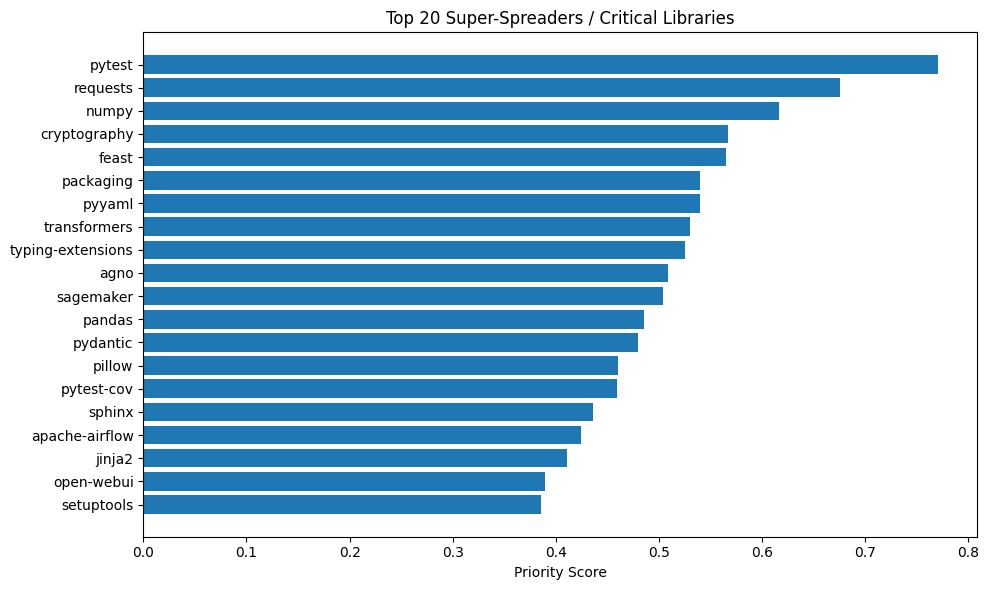

In [33]:
plt.figure(figsize=(10,6))
plt.barh(priority_top20["package"], priority_top20["priority_score"])
plt.gca().invert_yaxis()
plt.xlabel("Priority Score")
plt.title("Top 20 Super-Spreaders / Critical Libraries")
plt.tight_layout()
plt.savefig("outputs/plots/top20_priority_super_spreaders.png", dpi=300)
plt.show()


# ONDE O PATÓGENO SURGE EM SEGUIDA?” — Predição tipo GLEAM

In [34]:
# Combinar hotspot_score + priority_score pra análise estilo GLEAM
risk_next = hotspots.merge(
    priority[["package", "priority_score"]],
    on="package",
    how="left"
)

# Score final de "onde vai surgir próxima vulnerabilidade"
risk_next["next_outbreak_score"] = (
    0.6 * risk_next["hotspot_score"] +
    0.4 * risk_next["priority_score"].fillna(0)
)

risk_next = risk_next.sort_values("next_outbreak_score", ascending=False)
risk_next_top30 = risk_next.head(30)
risk_next.to_csv("outputs/plots/next_outbreak_prediction.csv", index=False)

risk_next_top30


package  hotspot_score  priority_score  next_outbreak_score
0           sagemaker       0.857701        0.504069             0.716248
1                vllm       0.802615        0.301073             0.601998
206            pytest       0.385234        0.770262             0.539246
183      transformers       0.507485        0.530525             0.516701
207          requests       0.380254        0.675676             0.498423
205             numpy       0.392398        0.616569             0.482066
202             feast       0.400000        0.564895             0.465958
182               ray       0.581837        0.276750             0.459802
194            pillow       0.434722        0.460022             0.444842
209            pyyaml       0.376952        0.539667             0.442038
2         python-jose       0.644120        0.105031             0.428485
208            pandas       0.378847        0.485733             0.421601
3               keras       0.641253        0.079528             0.416563
4     python-socketio       0.636193        0.083822             0.415244
187      scikit-learn       0.476700        0.313573             0.411450
283      cryptography       0.307046        0.566723             0.410917
5    restrictedpython       0.634668        0.075237             0.410896
48          fonttools       0.614862        0.089158             0.404580
8          watchfiles       0.622861        0.064732             0.399610
6                ftfy       0.627314        0.049042             0.396005
222          pydantic       0.338569        0.480027             0.395152
7             librosa       0.624903        0.047836             0.394076
9         apscheduler       0.618450        0.044670             0.388938
10              pydub       0.617142        0.044020             0.387893
295         packaging       0.279849        0.540165             0.383975
69         flask-cors       0.609044        0.042265             0.382333
203           fastapi       0.397976        0.358751             0.382286
11          num2words       0.615926        0.028911             0.381120
47        pyctcdecode       0.615894        0.025639             0.379792
46              optax       0.615894        0.025639             0.379792

# GRAFO DE RISCO — cor por probabilidade de “infecção futura”

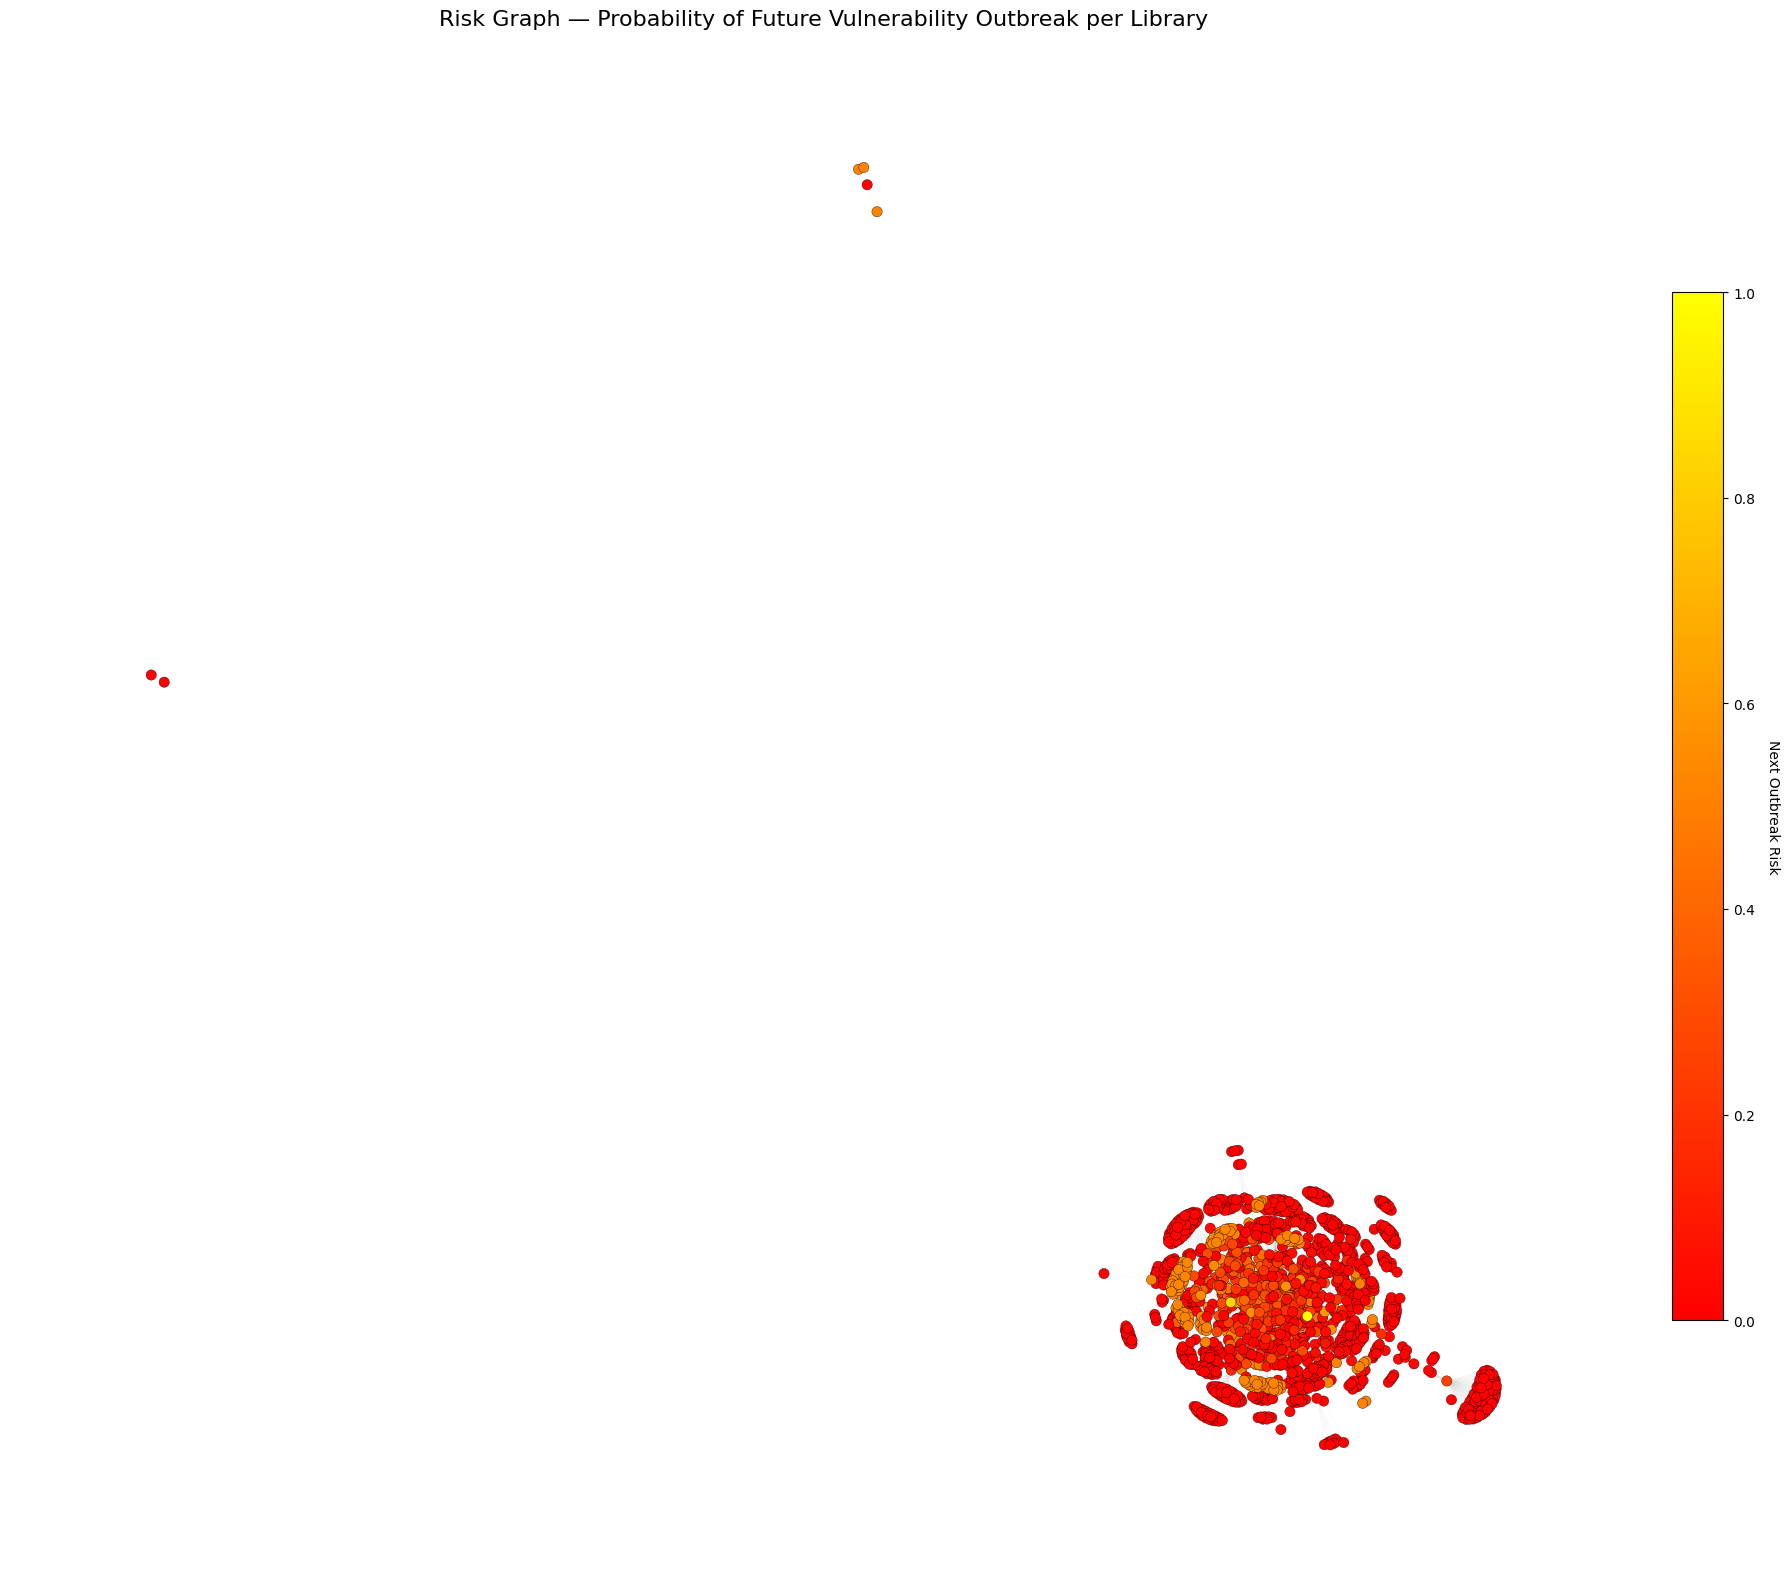

In [36]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Layout (se você já tiver pos calculado, pode reutilizar)
k = 1 / np.sqrt(max(UG.number_of_nodes(), 1))
pos = nx.spring_layout(UG, k=k*3, iterations=300, seed=42)

# mapear risco para cada nó
risk_map = dict(zip(risk_next["package"], risk_next["next_outbreak_score"]))
values = np.array([risk_map.get(n, 0.0) for n in UG.nodes()], dtype=float)

# normalização
if values.max() > 0:
    norm_vals = (values - values.min()) / (values.max() - values.min() + 1e-9)
else:
    norm_vals = values

# cmap atualizado (nova API)
cmap = plt.colormaps.get_cmap("autumn")

fig, ax = plt.subplots(figsize=(18, 16))

# Desenha edges
nx.draw_networkx_edges(
    UG, pos, ax=ax,
    alpha=0.08, edge_color="gray", width=0.3
)

# Desenha nodes com heatmap
nodes = nx.draw_networkx_nodes(
    UG, pos, ax=ax,
    node_color=cmap(norm_vals),
    node_size=55,
    edgecolors="black",
    linewidths=0.25
)

# CORRIGIDO: colorbar com Axes explícito
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Next Outbreak Risk", rotation=270, labelpad=18)

ax.set_title("Risk Graph — Probability of Future Vulnerability Outbreak per Library", fontsize=16)
ax.set_axis_off()

plt.tight_layout()
plt.savefig("outputs/plots/future_risk_graph.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
Centralidades (com correções)

In [27]:
deg = dict(DG.in_degree())

bet = nx.betweenness_centrality(UG, normalized=True)
eig = nx.eigenvector_centrality(UG, max_iter=500)

core = nx.core_number(UG)

metrics = pd.DataFrame({
    "package": list(DG.nodes()),
    "in_degree": [deg.get(n,0) for n in DG.nodes()],
    "betweenness": [bet.get(n,0) for n in DG.nodes()],
    "eigenvector": [eig.get(n,0) for n in DG.nodes()],
    "kcore": [core.get(n,0) for n in DG.nodes()],
})

metrics.to_csv("outputs/plots/centrality_metrics.csv", index=False)

metrics.sort_values("betweenness", ascending=False).head(15)


package  in_degree  betweenness  eigenvector  kcore
164   apache-airflow          8     0.118742     0.015391      5
1254       sagemaker          1     0.105889     0.156932     10
0               agno          1     0.102806     0.171612     10
665            feast          1     0.101803     0.243587     10
462     transformers          8     0.075300     0.217697     10
1043      open-webui          0     0.063739     0.156415     10
1091         prefect          0     0.054040     0.084168     10
154         requests         41     0.053837     0.151357     10
163     cryptography         31     0.052565     0.116262     10
17            pytest         52     0.051284     0.171357     10
1219  red-discordbot          0     0.041217     0.101555     10
1339          sglang          0     0.040953     0.116907     10
776    homeassistant          0     0.037752     0.064548     10
523       setuptools         14     0.036818     0.103815     10
1218            vllm          1     0.036443     0.123386     10

In [ ]:
Identificar “super-spreaders” (hubs de vulnerabilidade)

In [28]:
super_spreaders = metrics.sort_values(
    ["in_degree", "betweenness", "eigenvector"],
    ascending=False
).head(25)

super_spreaders.to_csv("outputs/plots/super_spreaders.csv", index=False)
super_spreaders


package  in_degree  betweenness  eigenvector  kcore
17              pytest         52     0.051284     0.171357     10
318              numpy         43     0.029021     0.136991     10
154           requests         41     0.053837     0.151357     10
3    typing-extensions         35     0.030272     0.096998     10
57           packaging         33     0.036354     0.115058     10
40              pyyaml         33     0.031333     0.129902     10
163       cryptography         31     0.052565     0.116262     10
128         pytest-cov         30     0.015137     0.109683     10
301             sphinx         30     0.014718     0.082317     10
277             pandas         29     0.026256     0.117312     10
46            pydantic         28     0.027848     0.114833     10
161             jinja2         25     0.018829     0.086458     10
355              click         24     0.012287     0.083185     10
300           coverage         24     0.009741     0.070838     10
39              pillow         22     0.032663     0.131866     10
93                rich         22     0.013286     0.081005     10
123              httpx         22     0.013144     0.078450     10
1              aiohttp         20     0.016575     0.078911     10
129            fastapi         20     0.010258     0.096202     10
105               mypy         19     0.012181     0.071515     10
85             uvicorn         19     0.008473     0.092739     10
321              scipy         18     0.011146     0.067112     10
381             psutil         18     0.009299     0.091611     10
363     pytest-timeout         18     0.005632     0.082988     10
324         pre-commit         17     0.004788     0.050025      9

In [ ]:
Prever “onde surgirá a próxima vulnerabilidade”

In [29]:
metrics["predicted_risk"] = (
    0.45 * metrics["eigenvector"] +
    0.35 * metrics["betweenness"] +
    0.20 * (metrics["in_degree"] / (metrics["in_degree"].max() + 1))
)

metrics.sort_values("predicted_risk", ascending=False).head(20)
metrics.sort_values("predicted_risk", ascending=False).to_csv(
    "outputs/plots/predicted_risk_next_vuln.csv", index=False
)


# %% [markdown]
# # Network Epidemics of AI Libraries (SIS, Scale-Free, Immunization & Prediction)
#
# Este notebook aplica a metodologia do Capítulo 10 (Network Epidemics)
# à rede de dependências de bibliotecas de IA (AI_LIBS):
# - Teste de rede scale-free (P(k), α, λ_c)
# - Modelo SIS em mean-field (i(t), estado endêmico)
# - Hubs / super-spreaders (grau, betweenness)
# - Estratégias de vacinação (random x targeted hubs)
# - Padrões bursty das vulnerabilidades (inter-event times)
# - Predição GLEAM-like de próximo surto de vulnerabilidade (risk graph)
#
# Pré-requisitos:
# - DG_all: DiGraph de dependências (A -> B se A depende de B)
# - UG_all: Graph não direcionado das mesmas dependências
# - CSV de vulnerabilidades temporais: top_pypi_snyk_timeline_20221112_20251112.csv

# %%

In [54]:
# %% [markdown]
# # Network Epidemics of AI Libraries (SIS, Scale-Free, Immunization & Prediction)
#
# Este notebook aplica a metodologia do Capítulo 10 (Network Epidemics)
# à rede de dependências de bibliotecas de IA (AI_LIBS):
# - Teste de rede scale-free (P(k), α, λ_c)
# - Modelo SIS em mean-field (i(t), estado endêmico)
# - Hubs / super-spreaders (grau, betweenness)
# - Estratégias de vacinação (random x targeted hubs)
# - Padrões bursty das vulnerabilidades (inter-event times)
# - Predição GLEAM-like de próximo surto de vulnerabilidade (risk graph)
#
# Pré-requisitos:
# - DG_all: DiGraph de dependências (A -> B se A depende de B)
# - UG_all: Graph não direcionado das mesmas dependências
# - CSV de vulnerabilidades temporais: top_pypi_snyk_timeline_20221112_20251112.csv

# %% 
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import powerlaw
from collections import Counter

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

# %% [markdown]
# ## 1. Definição das bibliotecas de IA e subgrafo 1-hop

# %%
AI_LIBS = [
    'torch','tensorflow','keras','pytorch-lightning','lightning',
    'scikit-learn','xgboost','lightgbm','catboost',
    'transformers','sentence-transformers','tokenizers',
    'langchain','langchain-core','langchain-community',
    'llama-index','llama-index-core',
    'vllm','litellm','openai','mlflow','wandb','clearml','sagemaker',
    'gradio','streamlit','opencv-python','pillow'
]

DG_all = DG_clean
UG_all = UG_clean

# Certificar que os grafos existem
print("DG_all nodes:", len(DG_all))
print("UG_all nodes:", len(UG_all))

# Subgrafo de IA + vizinhos (1-hop) no grafo não-direcionado
ai_nodes = {n for n in UG_all.nodes() if n in AI_LIBS}
ai_hop = set(ai_nodes)

for n in ai_nodes:
    ai_hop.update(UG_all.neighbors(n))

H = UG_all.subgraph(ai_hop).copy()
print("AI 1-hop subgraph:", H.number_of_nodes(), "nodes,", H.number_of_edges(), "edges")



# %% [markdown]
# ## 2. Carregar timeline de vulnerabilidades (Snyk) e filtrar AI_LIBS

# %% [markdown]
# ## 2. Carregar timeline de vulnerabilidades (Snyk) e filtrar AI_LIBS

# %%
timeline_path = "outputs/top_pypi_snyk_timeline_20221112_20251112.csv"  # ajuste o path se necessário
timeline = pd.read_csv(timeline_path)

# Normaliza nomes de colunas para minúsculas
timeline.columns = [c.lower() for c in timeline.columns]

# Garante que a coluna de pacote exista com nome "package"
if "package" not in timeline.columns:
    raise ValueError(f"Não encontrei coluna 'package' no CSV. Colunas disponíveis: {timeline.columns}")

# Converte nome dos pacotes para minúsculo
timeline["package"] = timeline["package"].astype(str).str.lower()

# Converte datas conhecidas
# tenta "disclosed_date" ou algo equivalente
date_candidates = ["disclosed_date", "disclosure_date", "published_date"]
disc_col = None
for c in date_candidates:
    if c in timeline.columns:
        disc_col = c
        break

if disc_col is None:
    raise ValueError(f"Não encontrei coluna de data de divulgação. Colunas disponíveis: {timeline.columns}")

timeline["disclosed_date"] = pd.to_datetime(timeline[disc_col])

# Se existir end_date_effective, converte; se não, cria uma coluna sintética
if "end_date_effective" in timeline.columns:
    timeline["end_date_effective"] = pd.to_datetime(timeline["end_date_effective"])
else:
    # suposição simples: janela de 365 dias de "atividade" da vulnerabilidade
    timeline["end_date_effective"] = timeline["disclosed_date"] + pd.Timedelta(days=365)

# Filtra somente bibliotecas de IA
timeline_ai = timeline[timeline["package"].isin([p.lower() for p in AI_LIBS])].copy()
print("Registros para AI libs:", len(timeline_ai))
timeline.head()


print("Registros para AI libs:", len(timeline_ai))

# %% [markdown]
# ## 3. Teste de Scale-Free: distribuição de grau P(k) e ajuste power-law

# %%
degrees = [d for _, d in H.degree()]
k_arr = np.array(degrees)

print("⟨k⟩ =", k_arr.mean())
print("⟨k²⟩ =", (k_arr**2).mean())

fit = powerlaw.Fit(k_arr, discrete=True, verbose=False)
alpha = fit.power_law.alpha
xmin = fit.power_law.xmin
R, p = fit.distribution_compare('power_law', 'lognormal')

print(f"α (exponent) = {alpha:.2f}")
print("xmin =", xmin)
print("Power law vs lognormal: R =", R, "p =", p)

# Plot P(k) em escala log-log com ajuste da lei de potência
fig = fit.plot_pdf(linewidth=2, label="data")
fit.power_law.plot_pdf(ax=fig, linestyle='--', color='black', label='power-law fit')
plt.xlabel("Degree k")
plt.ylabel("P(k)")
plt.title("Degree distribution — AI 1-hop dependency network")
plt.legend()
plt.show()

# %% [markdown]
# **Interpretação rápida:**
# - α ~ [2, 3] e p pequeno → rede com boa aproximação scale-free.
# - Isso implica ⟨k²⟩ grande e, pelo modelo de rede, limiar epidêmico λ_c baixo.

# %% [markdown]
# ## 4. Epidemic Threshold λ_c para SIS no grafo real (Capítulo 10)
#
# Fórmula (Tabela 10.3):
# \lambda_c = ⟨k⟩ / ⟨k²⟩

# %%
lambda_c = k_arr.mean() / ((k_arr**2).mean())
print(f"Epidemic threshold λ_c = {lambda_c:.4f}")

if lambda_c < 0.05:
    print(">> Limiar praticamente zero: típico comportamento de rede scale-free.")
    print(">> Mesmo patógenos fracos (β/μ baixo) podem se tornar endêmicos.")
else:
    print(">> Limiar mais alto: rede mais próxima de aleatória.")

# %% [markdown]
# ## 5. SIS Mean-Field Model (como no livro) para a rede de AI
#
# Equação (10.6) em fração i(t) e assumindo grau médio ⟨k⟩:
#
# i(t+1) = i(t) + β ⟨k⟩ i(t)(1 - i(t)) - μ i(t)
#
# Vamos escolher β e μ tal que:
# - λ = β/μ um pouco acima de λ_c → regime endêmico.
# - Comparar i(t) e o valor teórico i(∞) = 1 - μ / (β⟨k⟩)

# %%
k_mean = k_arr.mean()

# Escolha de parâmetros
beta = 0.25
mu = 0.1
lam = beta / mu
print(f"β={beta}, μ={mu}, λ={lam:.3f}, λ/λ_c ≈ {lam/lambda_c:.2f}")

def SIS_mean_field(beta, mu, k_mean, steps=40, i0=0.01):
    i = i0
    hist = [i0]
    for _ in range(steps):
        i = i + beta * k_mean * i * (1 - i) - mu * i
        i = max(0.0, min(1.0, i))
        hist.append(i)
    return np.array(hist)

sis_curve = SIS_mean_field(beta, mu, k_mean, steps=60, i0=0.01)

i_inf = 1 - mu / (beta * k_mean)
print("i(∞) teórico (SIS) =", max(0, i_inf))

t = np.arange(len(sis_curve))
plt.plot(t, sis_curve, color='green', linewidth=3)
plt.axhline(i_inf, linestyle='--', color='gray', label="i(∞) teórico")
plt.xlabel("t (steps)")
plt.ylabel("i(t) — fraction of vulnerable libraries")
plt.title("SIS mean-field on AI dependency network")
plt.legend()
plt.show()

# %% [markdown]
# ### 5.1 Simulação SIS sobre o grafo real (rede DG_all restrita a H)
#
# Agora, em vez do mean-field, simulamos SIS node-level, usando DG_all
# restringido às libs do subgrafo H.

# %%
DG = DG_all.subgraph(H.nodes()).copy()

def simulate_SIS_graph(G, beta=0.25, mu=0.1, steps=40, initial_infected=None, seed=42):
    rng = np.random.default_rng(seed)
    nodes = list(G.nodes())
    infected = {n: False for n in nodes}
    
    if initial_infected is None:
        # seed: libs de IA com vulnerabilidade ativa recente
        today = timeline['disclosed_date'].max()
        recency_cut = today - pd.Timedelta(days=365)
        active = set(timeline_ai[timeline_ai['disclosed_date'] >= recency_cut]['package'].unique())
        initial_infected = [n for n in nodes if n in active]
    
    for n in initial_infected:
        if n in infected:
            infected[n] = True
    
    history = []
    for _ in range(steps):
        new_state = infected.copy()
        for n in nodes:
            if infected[n]:
                # recuperação
                if rng.random() < mu:
                    new_state[n] = False
            else:
                # infecção vindo dos predecessores (quem depende dele)
                for neigh in G.predecessors(n):
                    if infected[neigh] and rng.random() < beta:
                        new_state[n] = True
                        break
        infected = new_state
        history.append(infected.copy())
    
    return history

sis_hist = simulate_SIS_graph(DG, beta=beta, mu=mu, steps=60)
infected_counts = [sum(1 for v in state.values() if v) for state in sis_hist]
frac_infected = np.array(infected_counts) / DG.number_of_nodes()

plt.plot(frac_infected, linewidth=2)
plt.xlabel("t (steps)")
plt.ylabel("fraction infected")
plt.title("SIS simulation on AI dependency graph")
plt.show()

# %% [markdown]
# ## 6. Super-spreaders: grau, betweenness e single point of failure

# %%
deg = dict(H.degree())
bet = nx.betweenness_centrality(H, normalized=True)

centrality_df = pd.DataFrame({
    "package": list(H.nodes()),
    "degree": [deg[n] for n in H.nodes()],
    "betweenness": [bet[n] for n in H.nodes()],
})

centrality_df["is_ai"] = centrality_df["package"].isin(AI_LIBS)

print("Top hubs (degree):")
display(centrality_df.sort_values("degree", ascending=False).head(15))

print("\nTop bridges (betweenness):")
display(centrality_df.sort_values("betweenness", ascending=False).head(15))

# Scatter grau x betweenness só para AI_LIBS (single point of failure)
ai_cent = centrality_df[centrality_df["is_ai"]].copy()

plt.figure(figsize=(10,6))
plt.scatter(ai_cent["betweenness"], ai_cent["degree"], s=60, alpha=0.7)
for _, row in ai_cent.sort_values("degree", ascending=False).head(12).iterrows():
    plt.text(row["betweenness"], row["degree"], row["package"],
             fontsize=8, bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="red", lw=0.5))

plt.xlabel("Betweenness centrality")
plt.ylabel("Degree")
plt.title("AI libraries — super-spreader & single point of failure")
plt.grid(True)
plt.show()

# %% [markdown]
# ## 7. Vaccination Strategies in Scale-Free Networks (AI libs)
#
# Adaptação direta da seção de imunização:
# - Random immunization: remover um % qualquer de nodes.
# - Targeted immunization: remover os hubs (grau maior).
# - Comparamos o novo λ_c de cada cenário.

# %%
def compute_lambda_c(G):
    k = np.array([d for _, d in G.degree()])
    return k.mean() / ((k**2).mean() + 1e-9)

orig_lambda_c = compute_lambda_c(H)
N = H.number_of_nodes()
cut = max(1, int(N * 0.05))   # 5% dos nodes

# targeted: remover top hubs
top_hubs = centrality_df.sort_values("degree", ascending=False)["package"].head(cut).tolist()
H_target = H.copy()
H_target.remove_nodes_from(top_hubs)
lambda_target = compute_lambda_c(H_target)

# random: remover qualquer nó
rng = np.random.default_rng(42)
rand_nodes = rng.choice(list(H.nodes()), size=cut, replace=False)
H_random = H.copy()
H_random.remove_nodes_from(rand_nodes)
lambda_random = compute_lambda_c(H_random)

print(f"Original λ_c  : {orig_lambda_c:.4f}")
print(f"Targeted λ_c  : {lambda_target:.4f} (removendo hubs)")
print(f"Random   λ_c  : {lambda_random:.4f} (removendo nós aleatórios)")

# Pequeno gráfico estilo livro para comparar
labels = ["Original", "Random immunization", "Targeted hubs"]
vals = [orig_lambda_c, lambda_random, lambda_target]

plt.figure(figsize=(6,4))
plt.bar(labels, vals, color=["gray","green","purple"])
plt.ylabel("λ_c")
plt.title("Effect of immunization strategies on epidemic threshold")
plt.show()

# %% [markdown]
# ## 8. Bursty Contact Patterns (inter-event times das vulnerabilidades)
#
# Vamos olhar para os tempos entre vulnerabilidades de uma lib de IA
# (ex: transformers, torch, litellm), e ver se a distribuição é mais próxima de
# Poisson (exponencial) ou power-law (bursty) como no Capítulo 10.

# %%
def inter_event_times(pkg, df):
    s = df[df["package"] == pkg].sort_values("disclosed_date")["disclosed_date"]
    if len(s) < 3:
        return None
    return s.diff().dt.days.dropna()

def plot_burstiness(pkg):
    tau = inter_event_times(pkg, timeline_ai)
    if tau is None:
        print(f"{pkg}: poucos eventos")
        return
    tau = tau[tau > 0]  # remove zeros
    if len(tau) == 0:
        print(f"{pkg}: intervalos nulos")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    # sequência temporal
    ax1.plot(range(len(tau)), tau.values, linewidth=1)
    ax1.set_title(f"Delay times sequence — {pkg}")
    ax1.set_xlabel("event index")
    ax1.set_ylabel("Δt (days)")
    # distribuição em escala log-log
    ax2.hist(tau.values, bins=20, density=True)
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    ax2.set_title("P(τ)")
    ax2.set_xlabel("τ (days)")
    plt.suptitle(f"Burstiness of vulnerabilities — {pkg}")
    plt.tight_layout()
    plt.show()

for pkg in ["transformers","torch","litellm","pillow"]:
    print("\n====", pkg, "====")
    plot_burstiness(pkg)

# %% [markdown]
# ## 9. GLEAM-like Prediction: próximo surto (risk score por biblioteca)
#
# Ideia:
# - Estrutural: grau + betweenness (potencial de espalhar).
# - Temporal: número de vulnerabilidades recentes (últimos 24 meses).
# - Risk score = combinação linear normalizada.
#
# Resultado:
# - Ranking de libs com maior probabilidade de "próximo surto".
# - Grafo colorido por risco (risk graph).

# %%
# vulnerabilidades recentes (por exemplo, últimos 24 meses)
cut_date = timeline['disclosed_date'].max() - pd.Timedelta(days=730)
recent = timeline[timeline['disclosed_date'] >= cut_date]

recent_counts = recent.groupby('package').size()
centrality_df["recent_vulns"] = centrality_df["package"].map(recent_counts).fillna(0)

# normalizações
centrality_df["deg_norm"] = centrality_df["degree"] / (centrality_df["degree"].max() or 1)
centrality_df["bet_norm"] = centrality_df["betweenness"] / (centrality_df["betweenness"].max() or 1)
centrality_df["rec_norm"] = centrality_df["recent_vulns"] / (centrality_df["recent_vulns"].max() or 1)

# risk score (ajuste pesos se quiser)
centrality_df["risk_score"] = (
    0.4 * centrality_df["deg_norm"] +
    0.4 * centrality_df["bet_norm"] +
    0.2 * centrality_df["rec_norm"]
)

print("Top 15 libs por risco de próximo surto:")
display(centrality_df.sort_values("risk_score", ascending=False).head(15))

# %% [markdown]
# ### 9.1 Risk Graph — grafo de AI colorido por risco

# %%
pos = nx.spring_layout(H, seed=42)

risk_map = centrality_df.set_index("package")["risk_score"]

fig, ax = plt.subplots(figsize=(14,10))
# edges
nx.draw_networkx_edges(H, pos, ax=ax, alpha=0.1, width=0.3, edge_color="lightgray")

# nodes
risk_vals = [risk_map.get(n, 0.0) for n in H.nodes()]
cmap = plt.colormaps.get_cmap("autumn")  # amarelo -> laranja -> vermelho

nodes = nx.draw_networkx_nodes(
    H, pos, ax=ax,
    node_color=risk_vals,
    cmap=cmap,
    node_size=80,
    linewidths=0.5,
    edgecolors="black"
)

# destacar AI_LIBS com borda mais grossa
ai_border_nodes = [n for n in H.nodes() if n in AI_LIBS]
nx.draw_networkx_nodes(
    H, pos, nodelist=ai_border_nodes,
    node_color=[risk_map.get(n, 0.0) for n in ai_border_nodes],
    cmap=cmap,
    node_size=160,
    linewidths=1.5,
    edgecolors="black",
    ax=ax
)

# labels só para top-10 em risco
top_risk = centrality_df.sort_values("risk_score", ascending=False).head(10)["package"].tolist()
labels = {n:n for n in H.nodes() if n in top_risk}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=9, ax=ax)

cbar = fig.colorbar(nodes, ax=ax)
cbar.set_label("Next-outbreak risk score", rotation=270, labelpad=15)

ax.set_title("Risk graph — AI libraries dependency network (GLEAM-like prediction)")
ax.axis("off")
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 10. Relatório final estilo Capítulo 10

# %%
print("===== NETWORK EPIDEMICS REPORT (AI DEPENDENCIES) =====")
print(f"Nodes: {H.number_of_nodes()}  Edges: {H.number_of_edges()}")
print(f"⟨k⟩ = {k_arr.mean():.2f}")
print(f"⟨k²⟩ = {(k_arr**2).mean():.2f}")
print(f"Degree exponent α ≈ {alpha:.2f}")
print(f"Epidemic threshold λ_c = {lambda_c:.4f}")
print(f"Chosen β={beta}, μ={mu}, λ={lam:.3f}")

if lam > lambda_c:
    print(">> SIS regime: λ > λ_c → estado endêmico de vulnerabilidades provável.")
else:
    print(">> SIS regime: λ <= λ_c → vulnerabilidades tenderiam a desaparecer.")

print("\nTop 10 hubs (by degree):")
print(centrality_df.sort_values("degree", ascending=False).head(10)[["package","degree","betweenness"]])

print("\nTop 10 predicted next-outbreak libs:")
print(centrality_df.sort_values("risk_score", ascending=False).head(10)[["package","risk_score","recent_vulns","degree","betweenness"]])


NameError: name 'DG_clean' is not defined

In [43]:
%pip install powerlaw

  Using cached powerlaw-1.5-py3-none-any.whl.metadata (9.3 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached powerlaw-1.5-py3-none-any.whl (24 kB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [powerlaw]━━ 1/2 [powerlaw]
Note: you may need to restart the kernel to use updated packages.


Amostra de arestas:


source                                  target
0   agno                                 aiohttp
1   agno  opentelemetry-exporter-otlp-proto-grpc
2   agno                       typing-extensions
3   agno                                  mem0ai
4   agno                            google-genai

DG_all: 1547 nodes, 3454 edges
UG_clean: 1541 nodes, 3440 edges
AI 1-hop subgraph: 427 nodes, 1272 edges
Registros Snyk para AI_LIBS: 233


package             cve           cwes severity first_affected_version  \
57  pillow  CVE-2023-50447  CWE-94;CWE-95      low                      0   
58  pillow  CVE-2024-28219        CWE-680      low                      0   
59  pillow  CVE-2023-44271        CWE-770     high                      0   
60  pillow   CVE-2023-4863        CWE-787      low                      0   
61  pillow  CVE-2022-45198            NaN     high                      0   

   first_affected_date disclosed_date mitigation_version mitigation_date  \
57                 NaN     2024-01-19             10.2.0      2024-01-02   
58                 NaN     2024-04-03             10.3.0      2024-04-01   
59                 NaN     2023-11-03             10.0.0      2023-07-01   
60                 NaN     2023-09-12             10.0.1      2023-09-15   
61                 NaN     2022-11-14              9.2.0      2022-07-01   

    disclosure_lag_days  time_to_fix_from_first_days  \
57                  NaN                          NaN   
58                  NaN                          NaN   
59                  NaN                          NaN   
60                  NaN                          NaN   
61                  NaN                          NaN   

    time_to_fix_from_disclosure_days fix_semver_type end_date_effective  
57                             -17.0           major         2025-01-18  
58                              -2.0           major         2025-04-03  
59                            -125.0           major         2024-11-02  
60                               3.0           major         2024-09-11  
61                            -136.0           major         2023-11-14

⟨k⟩ = 5.95784543325527
⟨k²⟩ = 155.03981264637002
α (exponent) = 1.60
xmin = 1.0
Power law vs lognormal: R = -15.716405658738706 p = 1.7370737105248793e-09


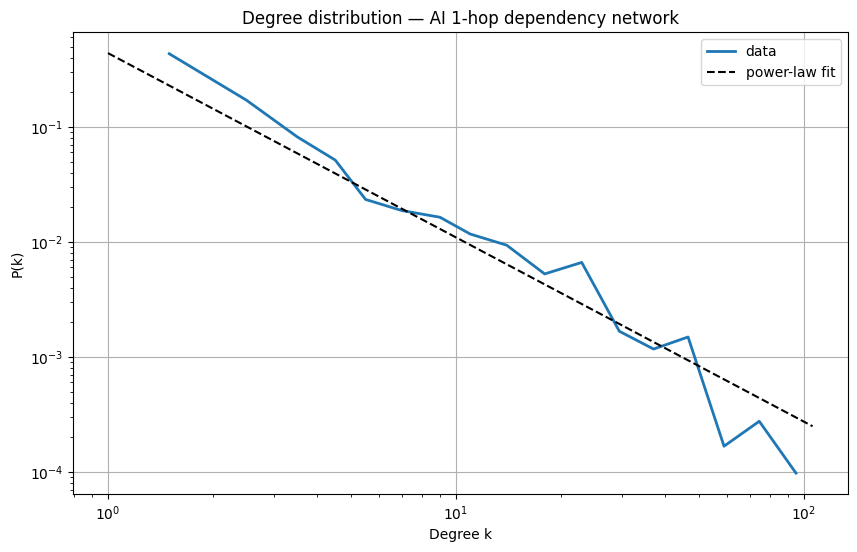


Epidemic threshold λ_c = 0.0384
>> Limiar praticamente zero: típico de rede altamente heterogênea / scale-free.
β=0.25, μ=0.1, λ=2.500, λ/λ_c ≈ 65.06


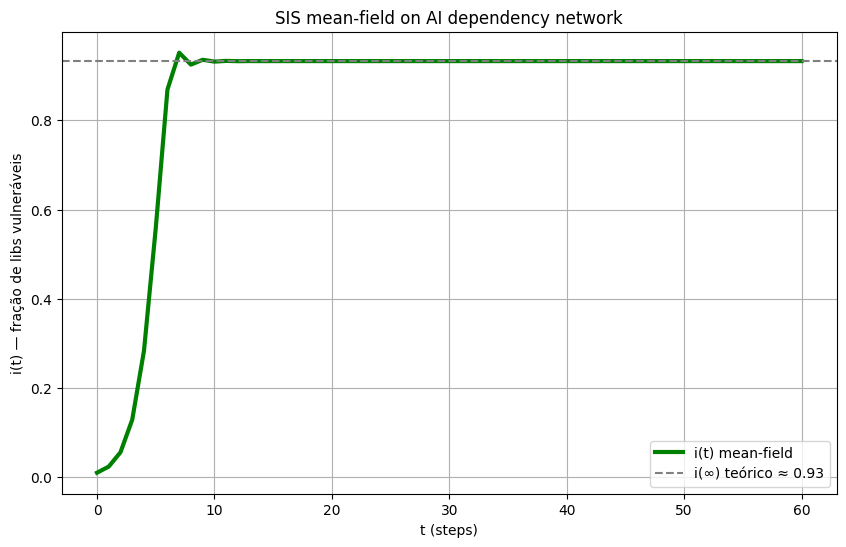

DG_ai: 427 nodes, 1275 edges


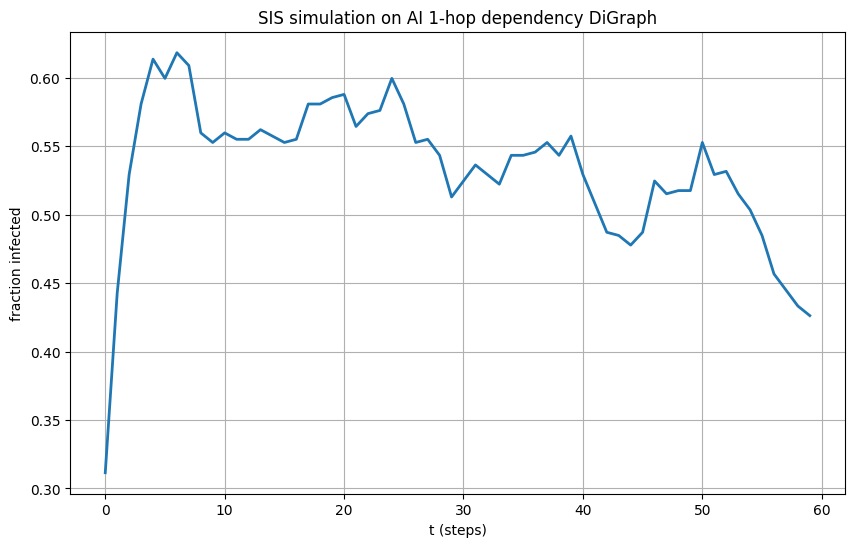

Top hubs (degree):


package  degree  betweenness  is_ai
347       transformers     106     0.263782   True
324          sagemaker      78     0.168927   True
191               vllm      69     0.132432   True
130              feast      59     0.055090  False
381            litellm      49     0.076706   True
323             mlflow      45     0.108352   True
37              pillow      44     0.086185   True
295         open-webui      44     0.047250  False
351       scikit-learn      43     0.085279   True
213               agno      41     0.021743  False
321             sglang      41     0.032497  False
256          lightning      39     0.029817   True
247              torch      37     0.087987   True
265  pytorch-lightning      37     0.024112   True
273             gradio      33     0.037611   True


Top bridges (betweenness):


package  degree  betweenness  is_ai
347      transformers     106     0.263782   True
324         sagemaker      78     0.168927   True
191              vllm      69     0.132432   True
323            mlflow      45     0.108352   True
247             torch      37     0.087987   True
37             pillow      44     0.086185   True
351      scikit-learn      43     0.085279   True
381           litellm      49     0.076706   True
154         langchain      24     0.066556   True
19   llama-index-core      30     0.055096   True
130             feast      59     0.055090  False
402             numpy      32     0.049651  False
295        open-webui      44     0.047250  False
273            gradio      33     0.037611   True
17          streamlit      28     0.035421   True

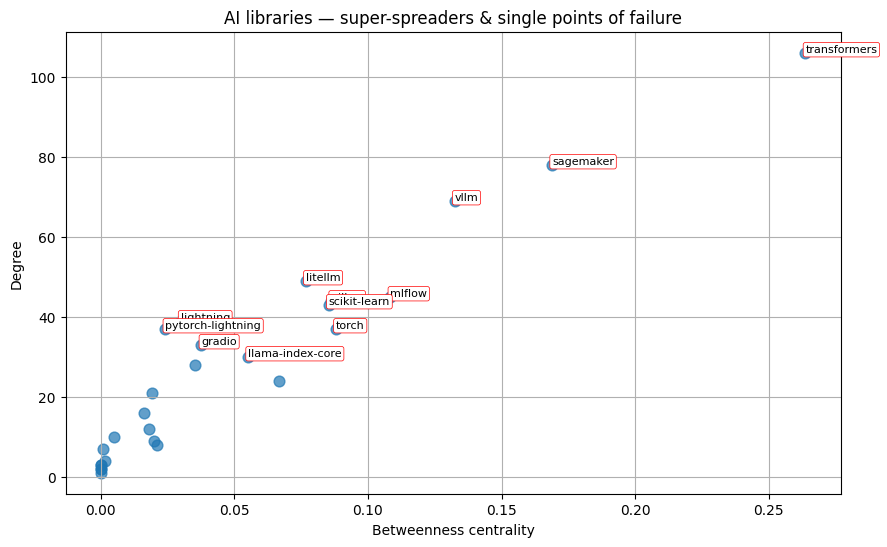

Original λ_c  : 0.0384
Random   λ_c  : 0.0420 (imunização aleatória)
Targeted λ_c  : 0.1035 (imunizando hubs)


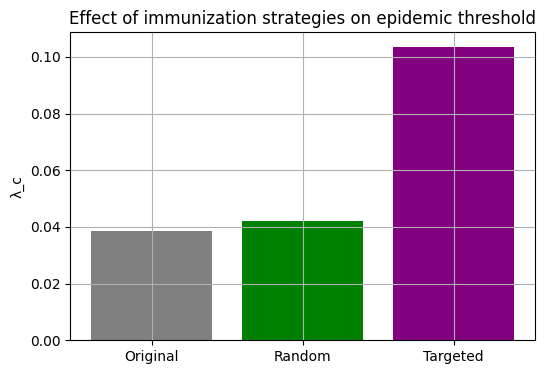


==== transformers ====


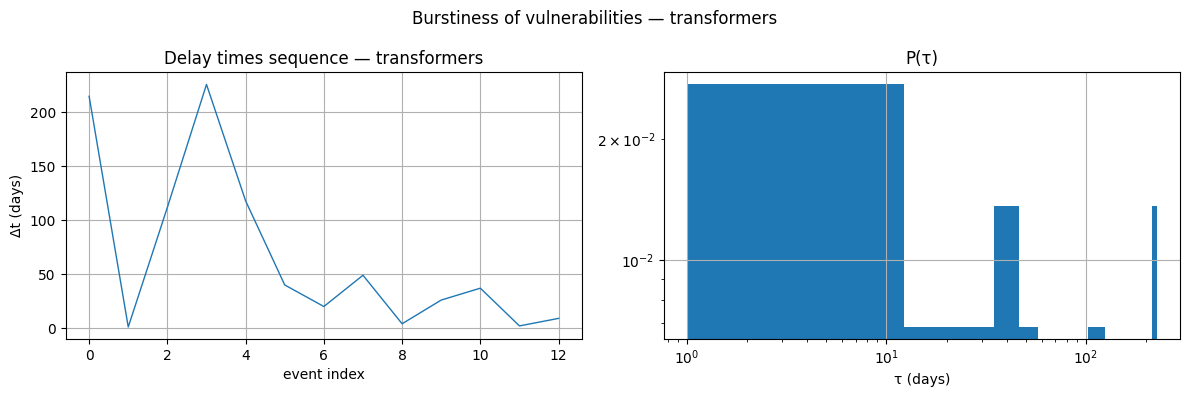


==== torch ====


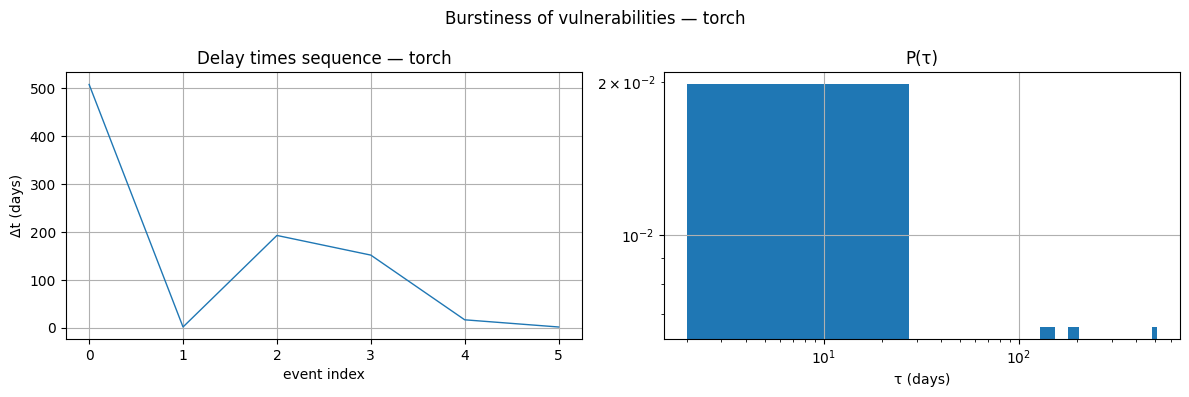


==== litellm ====


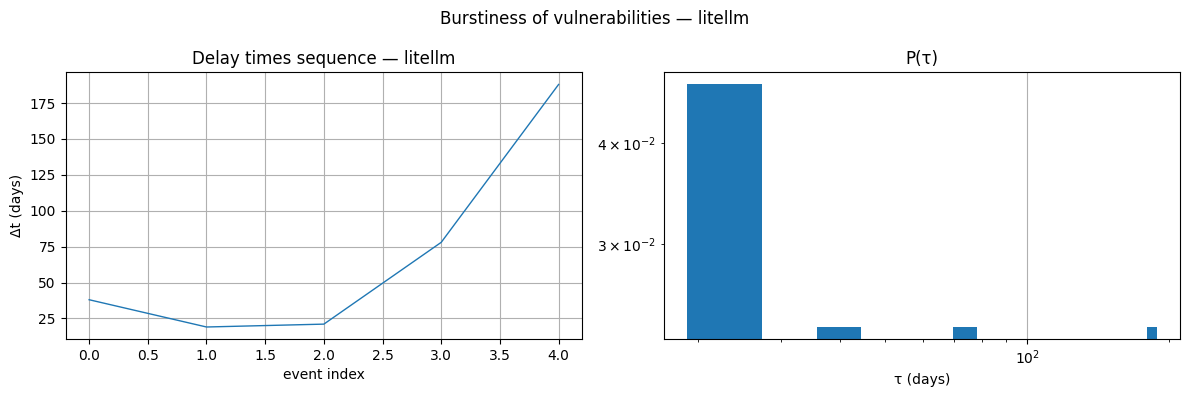


==== pillow ====


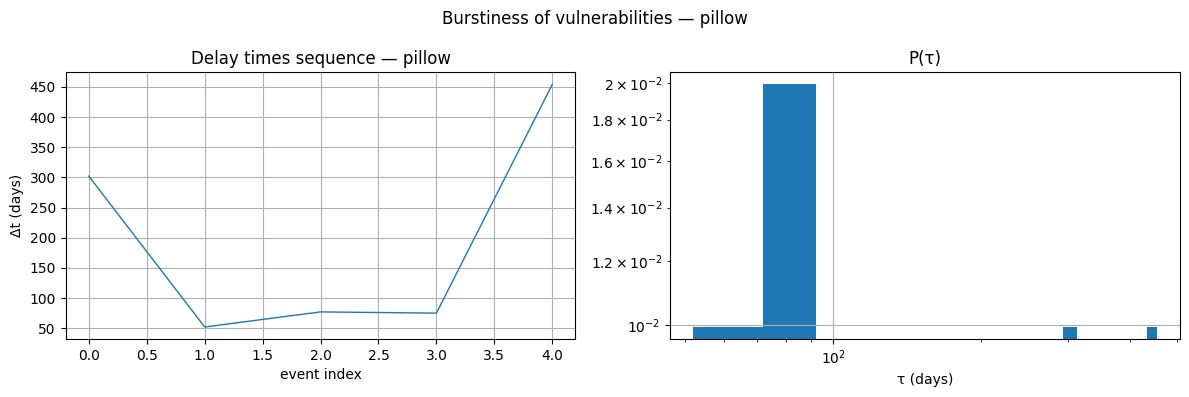

Top 15 libs por risco de próximo surto:


package  degree  betweenness  is_ai  recent_vulns  deg_norm  \
347      transformers     106     0.263782   True          18.0  1.000000   
191              vllm      69     0.132432   True          25.0  0.650943   
324         sagemaker      78     0.168927   True           3.0  0.735849   
323            mlflow      45     0.108352   True          46.0  0.424528   
381           litellm      49     0.076706   True          14.0  0.462264   
273            gradio      33     0.037611   True          37.0  0.311321   
295        open-webui      44     0.047250  False          24.0  0.415094   
130             feast      59     0.055090  False           1.0  0.556604   
37             pillow      44     0.086185   True           3.0  0.415094   
247             torch      37     0.087987   True           7.0  0.349057   
351      scikit-learn      43     0.085279   True           1.0  0.405660   
19   llama-index-core      30     0.055096   True           8.0  0.283019   
321            sglang      41     0.032497  False           1.0  0.386792   
256         lightning      39     0.029817   True           2.0  0.367925   
154         langchain      24     0.066556   True           2.0  0.226415   

     bet_norm  rec_norm  risk_score  
347  1.000000  0.391304    0.878261  
191  0.502050  0.543478    0.569893  
324  0.640402  0.065217    0.563544  
323  0.410762  1.000000    0.534116  
381  0.290795  0.304348    0.362093  
273  0.142582  0.804348    0.342431  
295  0.179125  0.521739    0.342035  
130  0.208848  0.021739    0.310528  
37   0.326727  0.065217    0.309772  
247  0.333559  0.152174    0.303481  
351  0.323295  0.021739    0.295930  
19   0.208869  0.173913    0.231538  
321  0.123196  0.021739    0.208343  
256  0.113038  0.043478    0.201081  
154  0.252313  0.043478    0.200187

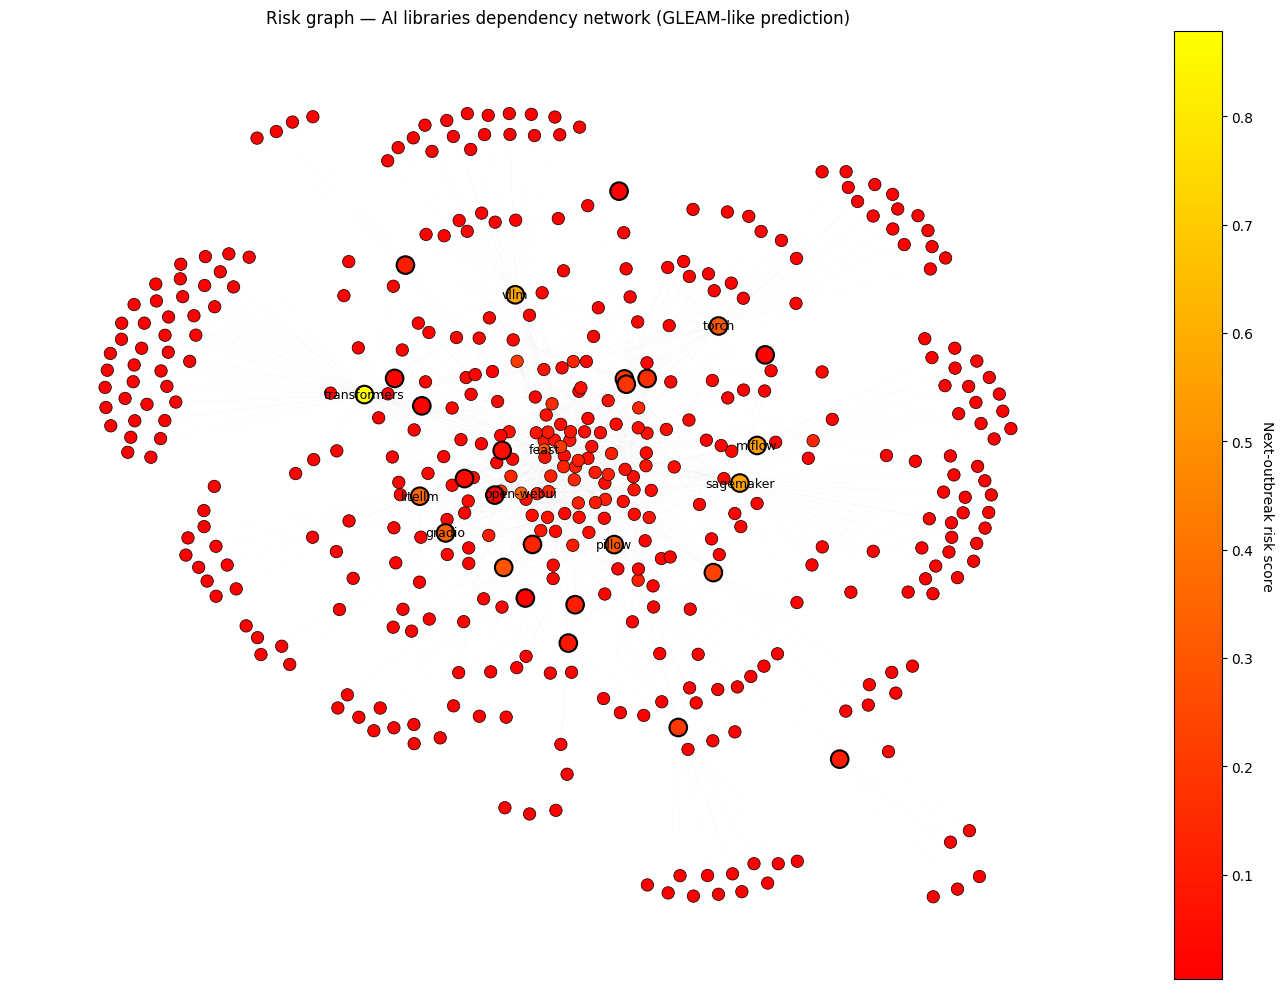

===== NETWORK EPIDEMICS REPORT (AI DEPENDENCIES) =====
Nodes: 427  Edges: 1272
⟨k⟩ = 5.96
⟨k²⟩ = 155.04
Degree exponent α ≈ 1.60
Epidemic threshold λ_c = 0.0384
Chosen β=0.25, μ=0.1, λ=2.500
>> SIS regime: λ > λ_c → estado endêmico de vulnerabilidades provável.

Top 10 hubs (by degree):
          package  degree  betweenness
347  transformers     106     0.263782
324     sagemaker      78     0.168927
191          vllm      69     0.132432
130         feast      59     0.055090
381       litellm      49     0.076706
323        mlflow      45     0.108352
37         pillow      44     0.086185
295    open-webui      44     0.047250
351  scikit-learn      43     0.085279
213          agno      41     0.021743

Top 10 predicted next-outbreak libs:
          package  risk_score  recent_vulns  degree  betweenness
347  transformers    0.878261          18.0     106     0.263782
191          vllm    0.569893          25.0      69     0.132432
324     sagemaker    0.563544           3.0      7

In [57]:
# %% [markdown]
# # Network Epidemics of AI Libraries (SIS, Scale-Free, Immunization & Prediction)
#
# Metodologia inspirada no Cap. 10 (Network Epidemics), aplicada à rede de
# dependências de bibliotecas de IA (AI_LIBS):
#
# - Teste de rede scale-free (P(k), α, λ_c)
# - Modelo SIS em mean-field (i(t), estado endêmico)
# - SIS na rede real das libs de IA
# - Hubs / super-spreaders (grau, betweenness)
# - Estratégias de vacinação (random x targeted hubs)
# - Padrões bursty (inter-event times de vulnerabilidades)
# - Predição GLEAM-like de próximo surto (risk graph)
#
# Pré-requisitos:
# - CSV de arestas: python_dependencies_edges.csv (source, target)
# - CSV Snyk: top_pypi_snyk_timeline_20221112_20251112.csv

# %%
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import powerlaw

from collections import Counter
from IPython.display import display

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

# ==========================
# CONFIGURAÇÃO DE ARQUIVOS
# ==========================
EDGES_PATH = "python_dependencies_edges.csv"
TIMELINE_PATH = "outputs/top_pypi_snyk_timeline_20221112_20251112.csv"

# %% [markdown]
# ## 1. Construir DG_all / UG_all a partir do CSV de dependências

# %%
# Lê CSV de arestas: colunas esperadas: source, target
edges = pd.read_csv(EDGES_PATH)

# sanity check básico
expected_cols = {"source", "target"}
if not expected_cols.issubset(set(edges.columns)):
    raise ValueError(f"CSV de arestas precisa ter colunas {expected_cols}, mas tem: {edges.columns}")

print("Amostra de arestas:")
display(edges.head())

# normaliza para str
edges["source"] = edges["source"].astype(str)
edges["target"] = edges["target"].astype(str)

# grafo dirigido A -> B se A depende de B
DG_all = nx.DiGraph()
DG_all.add_edges_from(edges[["source", "target"]].itertuples(index=False, name=None))

# remove self-loops
DG_all.remove_edges_from(list(nx.selfloop_edges(DG_all)))

# grafo não-direcionado correspondente
UG_all = DG_all.to_undirected()
UG_all.remove_edges_from(list(nx.selfloop_edges(UG_all)))

# opcional: maior componente conexa (para evitar “ilhas” soltas)
if not nx.is_connected(UG_all):
    largest_cc = max(nx.connected_components(UG_all), key=len)
    UG_clean = UG_all.subgraph(largest_cc).copy()
else:
    UG_clean = UG_all.copy()

print(f"DG_all: {DG_all.number_of_nodes()} nodes, {DG_all.number_of_edges()} edges")
print(f"UG_clean: {UG_clean.number_of_nodes()} nodes, {UG_clean.number_of_edges()} edges")

# %% [markdown]
# ## 2. Definir AI_LIBS e extrair subgrafo 1-hop

# %%
AI_LIBS = [
    'torch','tensorflow','keras','pytorch-lightning','lightning',
    'scikit-learn','xgboost','lightgbm','catboost',
    'transformers','sentence-transformers','tokenizers',
    'langchain','langchain-core','langchain-community',
    'llama-index','llama-index-core',
    'vllm','litellm','openai','mlflow','wandb','clearml','sagemaker',
    'gradio','streamlit','opencv-python','pillow'
]
AI_SET = {p.lower() for p in AI_LIBS}

# nós de IA no grafo limpo (match por lower)
ai_nodes = {n for n in UG_clean.nodes() if n.lower() in AI_SET}
ai_hop = set(ai_nodes)
for n in ai_nodes:
    ai_hop.update(UG_clean.neighbors(n))

H = UG_clean.subgraph(ai_hop).copy()
print("AI 1-hop subgraph:", H.number_of_nodes(), "nodes,", H.number_of_edges(), "edges")

# %% [markdown]
# ## 3. Carregar timeline Snyk e filtrar AI_LIBS

# %%
timeline = pd.read_csv(TIMELINE_PATH)

# normaliza nomes de colunas
timeline.columns = [c.lower() for c in timeline.columns]

if "package" not in timeline.columns:
    raise ValueError(f"CSV Snyk precisa ter coluna 'package'. Colunas: {timeline.columns}")

timeline["package"] = timeline["package"].astype(str).str.lower()

# data de divulgação (ou equivalente)
date_candidates = ["disclosed_date", "disclosure_date", "published_date"]
disc_col = None
for c in date_candidates:
    if c in timeline.columns:
        disc_col = c
        break
if disc_col is None:
    raise ValueError(f"Não encontrei coluna de data de divulgação. Colunas: {timeline.columns}")

timeline["disclosed_date"] = pd.to_datetime(timeline[disc_col])

# se não houver end_date_effective, cria janela de 365 dias
if "end_date_effective" in timeline.columns:
    timeline["end_date_effective"] = pd.to_datetime(timeline["end_date_effective"])
else:
    timeline["end_date_effective"] = timeline["disclosed_date"] + pd.Timedelta(days=365)

timeline_ai = timeline[timeline["package"].isin(AI_SET)].copy()
print("Registros Snyk para AI_LIBS:", len(timeline_ai))
display(timeline_ai.head())

# %% [markdown]
# ## 4. Teste de Scale-Free (P(k), α) e limiar epidêmico λ_c

# %%
degrees = [d for _, d in H.degree()]
k_arr = np.array(degrees)

print("⟨k⟩ =", k_arr.mean())
print("⟨k²⟩ =", (k_arr**2).mean())

# ajuste power-law só em k >= 1
k_nonzero = k_arr[k_arr > 0]
fit = powerlaw.Fit(k_nonzero, discrete=True, verbose=False)
alpha = fit.power_law.alpha
xmin = fit.power_law.xmin
R, p = fit.distribution_compare('power_law', 'lognormal')

print(f"α (exponent) = {alpha:.2f}")
print("xmin =", xmin)
print("Power law vs lognormal: R =", R, "p =", p)

# gráfico P(k)
fig = fit.plot_pdf(linewidth=2, label="data")
fit.power_law.plot_pdf(ax=fig, linestyle='--', color='black', label='power-law fit')
plt.xlabel("Degree k")
plt.ylabel("P(k)")
plt.title("Degree distribution — AI 1-hop dependency network")
plt.legend()
plt.show()

# limiar epidêmico SIS na rede (λ_c = ⟨k⟩ / ⟨k²⟩)
lambda_c = k_arr.mean() / ((k_arr**2).mean() + 1e-9)
print(f"\nEpidemic threshold λ_c = {lambda_c:.4f}")
if lambda_c < 0.05:
    print(">> Limiar praticamente zero: típico de rede altamente heterogênea / scale-free.")
else:
    print(">> Limiar mais alto: rede mais próxima de aleatória.")

# %% [markdown]
# ## 5. Modelo SIS mean-field (Cap. 10) para a rede de IA

# %%
k_mean = k_arr.mean()

# escolhe β, μ com λ > λ_c (regime endêmico)
beta = 0.25
mu = 0.10
lam = beta / mu
print(f"β={beta}, μ={mu}, λ={lam:.3f}, λ/λ_c ≈ {lam/lambda_c:.2f}")

def SIS_mean_field(beta, mu, k_mean, steps=40, i0=0.01):
    i = i0
    hist = [i0]
    for _ in range(steps):
        i = i + beta * k_mean * i * (1 - i) - mu * i
        i = max(0.0, min(1.0, i))
        hist.append(i)
    return np.array(hist)

sis_curve = SIS_mean_field(beta, mu, k_mean, steps=60, i0=0.01)
i_inf = max(0.0, 1 - mu / (beta * k_mean))

t = np.arange(len(sis_curve))
plt.plot(t, sis_curve, color='green', linewidth=3, label="i(t) mean-field")
plt.axhline(i_inf, linestyle='--', color='gray', label=f"i(∞) teórico ≈ {i_inf:.2f}")
plt.xlabel("t (steps)")
plt.ylabel("i(t) — fração de libs vulneráveis")
plt.title("SIS mean-field on AI dependency network")
plt.legend()
plt.show()

# %% [markdown]
# ### 5.1 SIS na rede real (DG_all restrito às libs de IA 1-hop)

# %%
# subgrafo dirigido correspondente ao H (mesmo conjunto de nós)
DG_ai = DG_all.subgraph(H.nodes()).copy()
print("DG_ai:", DG_ai.number_of_nodes(), "nodes,", DG_ai.number_of_edges(), "edges")

def simulate_SIS_graph(G: nx.DiGraph, beta=0.25, mu=0.1, steps=40,
                       initial_infected=None, seed=42):
    rng = np.random.default_rng(seed)
    nodes = list(G.nodes())
    infected = {n: False for n in nodes}
    
    # semente: libs de IA com vulnerabilidade divulgada no último ano
    if initial_infected is None:
        today = timeline["disclosed_date"].max()
        recency_cut = today - pd.Timedelta(days=365)
        active_pkgs = set(
            timeline_ai[timeline_ai["disclosed_date"] >= recency_cut]["package"].unique()
        )
        initial_infected = [n for n in nodes if n.lower() in active_pkgs]
    
    # se mesmo assim não tiver semente, escolhe 1 nó aleatório
    if not initial_infected:
        initial_infected = [rng.choice(nodes)]
    
    for n in initial_infected:
        if n in infected:
            infected[n] = True
    
    history = []
    for _ in range(steps):
        new_state = infected.copy()
        for n in nodes:
            if infected[n]:
                # recuperação
                if rng.random() < mu:
                    new_state[n] = False
            else:
                # infecção a partir de predecessores (quem depende de n)
                for neigh in G.predecessors(n):
                    if infected[neigh] and rng.random() < beta:
                        new_state[n] = True
                        break
        infected = new_state
        history.append(infected.copy())
    
    return history

sis_hist = simulate_SIS_graph(DG_ai, beta=beta, mu=mu, steps=60)
infected_counts = [sum(1 for v in state.values() if v) for state in sis_hist]
frac_infected = np.array(infected_counts) / DG_ai.number_of_nodes()

plt.plot(frac_infected, linewidth=2)
plt.xlabel("t (steps)")
plt.ylabel("fraction infected")
plt.title("SIS simulation on AI 1-hop dependency DiGraph")
plt.show()

# %% [markdown]
# ## 6. Super-spreaders: grau, betweenness e single point of failure

# %%
deg_dict = dict(H.degree())
bet_dict = nx.betweenness_centrality(H, normalized=True)

centrality_df = pd.DataFrame({
    "package": list(H.nodes()),
    "degree": [deg_dict[n] for n in H.nodes()],
    "betweenness": [bet_dict[n] for n in H.nodes()],
})
centrality_df["is_ai"] = centrality_df["package"].str.lower().isin(AI_SET)

print("Top hubs (degree):")
display(centrality_df.sort_values("degree", ascending=False).head(15))

print("\nTop bridges (betweenness):")
display(centrality_df.sort_values("betweenness", ascending=False).head(15))

# scatter grau x betweenness só para AI_LIBS (SPOF de IA)
ai_cent = centrality_df[centrality_df["is_ai"]].copy()

plt.figure(figsize=(10, 6))
plt.scatter(ai_cent["betweenness"], ai_cent["degree"], s=60, alpha=0.7)
for _, row in ai_cent.sort_values("degree", ascending=False).head(12).iterrows():
    plt.text(
        row["betweenness"], row["degree"], row["package"],
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="red", lw=0.5)
    )

plt.xlabel("Betweenness centrality")
plt.ylabel("Degree")
plt.title("AI libraries — super-spreaders & single points of failure")
plt.grid(True)
plt.show()

# %% [markdown]
# ## 7. Vaccination Strategies in Scale-Free Networks (AI libs)

# %%
def compute_lambda_c(G):
    k = np.array([d for _, d in G.degree()])
    return k.mean() / ((k**2).mean() + 1e-9)

orig_lambda_c = compute_lambda_c(H)
N = H.number_of_nodes()
cut = max(1, int(N * 0.05))   # 5% dos nós

# targeted: remove top hubs
top_hubs = centrality_df.sort_values("degree", ascending=False)["package"].head(cut).tolist()
H_target = H.copy()
H_target.remove_nodes_from(top_hubs)
lambda_target = compute_lambda_c(H_target)

# random: remove nós aleatórios
rng = np.random.default_rng(42)
rand_nodes = rng.choice(list(H.nodes()), size=cut, replace=False)
H_random = H.copy()
H_random.remove_nodes_from(rand_nodes)
lambda_random = compute_lambda_c(H_random)

print(f"Original λ_c  : {orig_lambda_c:.4f}")
print(f"Random   λ_c  : {lambda_random:.4f} (imunização aleatória)")
print(f"Targeted λ_c  : {lambda_target:.4f} (imunizando hubs)")

labels = ["Original", "Random", "Targeted"]
vals = [orig_lambda_c, lambda_random, lambda_target]

plt.figure(figsize=(6,4))
plt.bar(labels, vals, color=["gray", "green", "purple"])
plt.ylabel("λ_c")
plt.title("Effect of immunization strategies on epidemic threshold")
plt.show()

# %% [markdown]
# ## 8. Bursty Contact Patterns (inter-event times de vulnerabilidades)

# %%
def inter_event_times(pkg, df):
    s = df[df["package"] == pkg].sort_values("disclosed_date")["disclosed_date"]
    if len(s) < 3:
        return None
    return s.diff().dt.days.dropna()

def plot_burstiness(pkg):
    tau = inter_event_times(pkg, timeline_ai)
    print(f"\n==== {pkg} ====")
    if tau is None or len(tau) == 0:
        print("Poucos eventos para analisar.")
        return
    tau = tau[tau > 0]
    if len(tau) == 0:
        print("Intervalos nulos.")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1.plot(range(len(tau)), tau.values, linewidth=1)
    ax1.set_title(f"Delay times sequence — {pkg}")
    ax1.set_xlabel("event index")
    ax1.set_ylabel("Δt (days)")
    
    ax2.hist(tau.values, bins=20, density=True)
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    ax2.set_title("P(τ)")
    ax2.set_xlabel("τ (days)")
    plt.suptitle(f"Burstiness of vulnerabilities — {pkg}")
    plt.tight_layout()
    plt.show()

for pkg in ["transformers", "torch", "litellm", "pillow"]:
    plot_burstiness(pkg)

# %% [markdown]
# ## 9. GLEAM-like Prediction: próximo surto (risk score por biblioteca)

# %%
# vulnerabilidades recentes (últimos 24 meses)
cut_date = timeline["disclosed_date"].max() - pd.Timedelta(days=730)
recent = timeline[timeline["disclosed_date"] >= cut_date]

recent_counts = recent.groupby("package").size()
centrality_df["recent_vulns"] = centrality_df["package"].str.lower().map(recent_counts).fillna(0)

# normalizações
centrality_df["deg_norm"] = centrality_df["degree"] / (centrality_df["degree"].max() or 1)
centrality_df["bet_norm"] = centrality_df["betweenness"] / (centrality_df["betweenness"].max() or 1)
centrality_df["rec_norm"] = centrality_df["recent_vulns"] / (centrality_df["recent_vulns"].max() or 1)

# risk score
centrality_df["risk_score"] = (
    0.4 * centrality_df["deg_norm"] +
    0.4 * centrality_df["bet_norm"] +
    0.2 * centrality_df["rec_norm"]
)

print("Top 15 libs por risco de próximo surto:")
display(centrality_df.sort_values("risk_score", ascending=False).head(15))

# %% [markdown]
# ### 9.1 Risk Graph — grafo colorido por risco (bibliotecas de IA)

# %%
pos = nx.spring_layout(H, seed=42)

risk_map = centrality_df.set_index("package")["risk_score"]

fig, ax = plt.subplots(figsize=(14,10))

# arestas
nx.draw_networkx_edges(H, pos, ax=ax, alpha=0.1, width=0.3, edge_color="lightgray")

# nós
risk_vals = [risk_map.get(n, 0.0) for n in H.nodes()]
cmap = plt.colormaps.get_cmap("autumn")  # amarelo -> laranja -> vermelho

nodes = nx.draw_networkx_nodes(
    H, pos, ax=ax,
    node_color=risk_vals,
    cmap=cmap,
    node_size=80,
    linewidths=0.5,
    edgecolors="black"
)

# destacar AI_LIBS com borda maior
ai_border_nodes = [n for n in H.nodes() if n.lower() in AI_SET]
nx.draw_networkx_nodes(
    H, pos, nodelist=ai_border_nodes,
    node_color=[risk_map.get(n, 0.0) for n in ai_border_nodes],
    cmap=cmap,
    node_size=160,
    linewidths=1.5,
    edgecolors="black",
    ax=ax
)

# labels só top-10 risco
top_risk = centrality_df.sort_values("risk_score", ascending=False).head(10)["package"].tolist()
labels = {n: n for n in H.nodes() if n in top_risk}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=9, ax=ax)

cbar = fig.colorbar(nodes, ax=ax)
cbar.set_label("Next-outbreak risk score", rotation=270, labelpad=15)

ax.set_title("Risk graph — AI libraries dependency network (GLEAM-like prediction)")
ax.axis("off")
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 10. Relatório final estilo Capítulo 10

# %%
print("===== NETWORK EPIDEMICS REPORT (AI DEPENDENCIES) =====")
print(f"Nodes: {H.number_of_nodes()}  Edges: {H.number_of_edges()}")
print(f"⟨k⟩ = {k_arr.mean():.2f}")
print(f"⟨k²⟩ = {(k_arr**2).mean():.2f}")
print(f"Degree exponent α ≈ {alpha:.2f}")
print(f"Epidemic threshold λ_c = {lambda_c:.4f}")
print(f"Chosen β={beta}, μ={mu}, λ={lam:.3f}")

if lam > lambda_c:
    print(">> SIS regime: λ > λ_c → estado endêmico de vulnerabilidades provável.")
else:
    print(">> SIS regime: λ <= λ_c → vulnerabilidades tenderiam a desaparecer.")

print("\nTop 10 hubs (by degree):")
print(centrality_df.sort_values("degree", ascending=False)
      .head(10)[["package", "degree", "betweenness"]])

print("\nTop 10 predicted next-outbreak libs:")
print(centrality_df.sort_values("risk_score", ascending=False)
      .head(10)[["package", "risk_score", "recent_vulns", "degree", "betweenness"]])


Amostra de arestas:


source                                  target
0   agno                                 aiohttp
1   agno  opentelemetry-exporter-otlp-proto-grpc
2   agno                       typing-extensions
3   agno                                  mem0ai
4   agno                            google-genai

DG_all: 1547 nodes, 3454 edges
UG_clean: 1541 nodes, 3440 edges
AI 1-hop subgraph: 427 nodes, 1272 edges
Registros Snyk para AI_LIBS: 233


package             cve           cwes severity first_affected_version  \
57  pillow  CVE-2023-50447  CWE-94;CWE-95      low                      0   
58  pillow  CVE-2024-28219        CWE-680      low                      0   
59  pillow  CVE-2023-44271        CWE-770     high                      0   
60  pillow   CVE-2023-4863        CWE-787      low                      0   
61  pillow  CVE-2022-45198            NaN     high                      0   

   first_affected_date disclosed_date mitigation_version mitigation_date  \
57                 NaN     2024-01-19             10.2.0      2024-01-02   
58                 NaN     2024-04-03             10.3.0      2024-04-01   
59                 NaN     2023-11-03             10.0.0      2023-07-01   
60                 NaN     2023-09-12             10.0.1      2023-09-15   
61                 NaN     2022-11-14              9.2.0      2022-07-01   

    disclosure_lag_days  time_to_fix_from_first_days  \
57                  NaN                          NaN   
58                  NaN                          NaN   
59                  NaN                          NaN   
60                  NaN                          NaN   
61                  NaN                          NaN   

    time_to_fix_from_disclosure_days fix_semver_type end_date_effective  
57                             -17.0           major         2025-01-18  
58                              -2.0           major         2025-04-03  
59                            -125.0           major         2024-11-02  
60                               3.0           major         2024-09-11  
61                            -136.0           major         2023-11-14

⟨k⟩ = 5.95784543325527
⟨k²⟩ = 155.03981264637002
α (exponent) = 1.60
xmin = 1.0
Power law vs lognormal: R = -15.716405658738706 p = 1.7370737105248793e-09


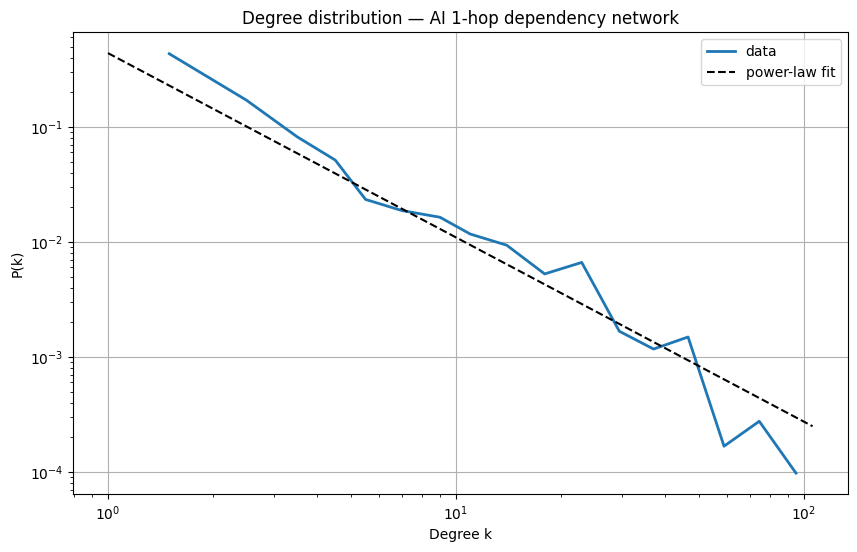


Epidemic threshold λ_c = 0.0384
>> Limiar praticamente zero: típico de rede altamente heterogênea / scale-free.
β=0.25, μ=0.1, λ=2.500, λ/λ_c ≈ 65.06


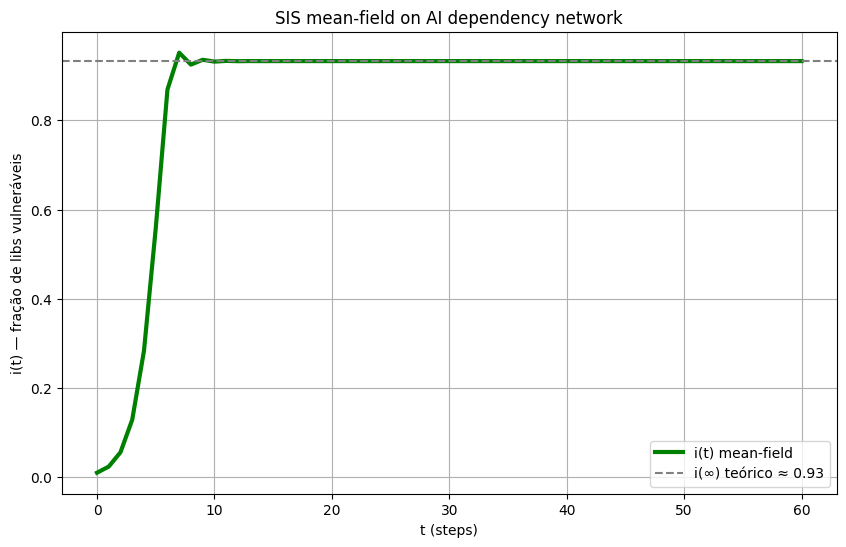

DG_ai: 427 nodes, 1275 edges


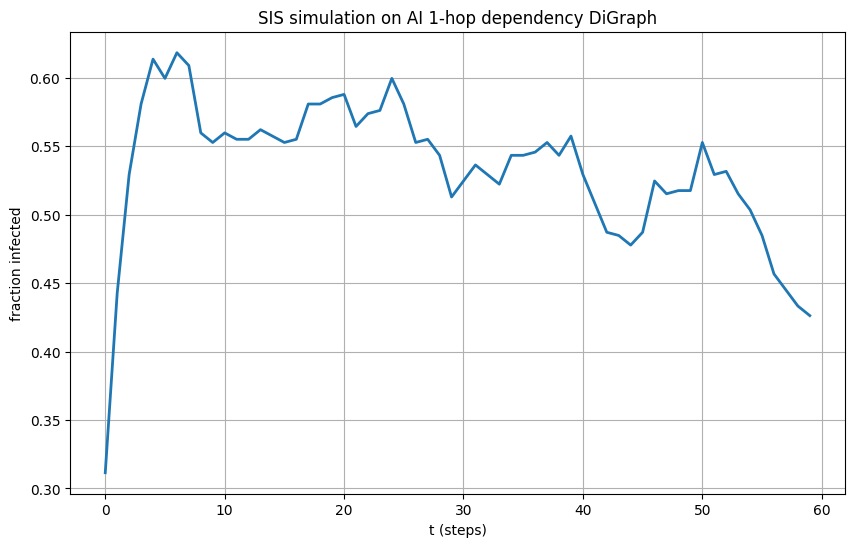

Top hubs (degree):


package  degree  betweenness  in_degree  out_degree  is_ai
347       transformers     106     0.263782          8          99   True
324          sagemaker      78     0.168927          1          77   True
191               vllm      69     0.132432          1          69   True
130              feast      59     0.055090          0          59  False
381            litellm      49     0.076706          3          46   True
323             mlflow      45     0.108352          2          43   True
37              pillow      44     0.086185         22          22   True
295         open-webui      44     0.047250          0          44  False
351       scikit-learn      43     0.085279         10          33   True
213               agno      41     0.021743          0          41  False
321             sglang      41     0.032497          0          41  False
256          lightning      39     0.029817          0          39   True
247              torch      37     0.087987         11          26   True
265  pytorch-lightning      37     0.024112          1          36   True
273             gradio      33     0.037611          1          32   True


Top bridges (betweenness):


package  degree  betweenness  in_degree  out_degree  is_ai
347      transformers     106     0.263782          8          99   True
324         sagemaker      78     0.168927          1          77   True
191              vllm      69     0.132432          1          69   True
323            mlflow      45     0.108352          2          43   True
247             torch      37     0.087987         11          26   True
37             pillow      44     0.086185         22          22   True
351      scikit-learn      43     0.085279         10          33   True
381           litellm      49     0.076706          3          46   True
154         langchain      24     0.066556          4          20   True
19   llama-index-core      30     0.055096          2          28   True
130             feast      59     0.055090          0          59  False
402             numpy      32     0.049651         32           0  False
295        open-webui      44     0.047250          0          44  False
273            gradio      33     0.037611          1          32   True
17          streamlit      28     0.035421          0          28   True

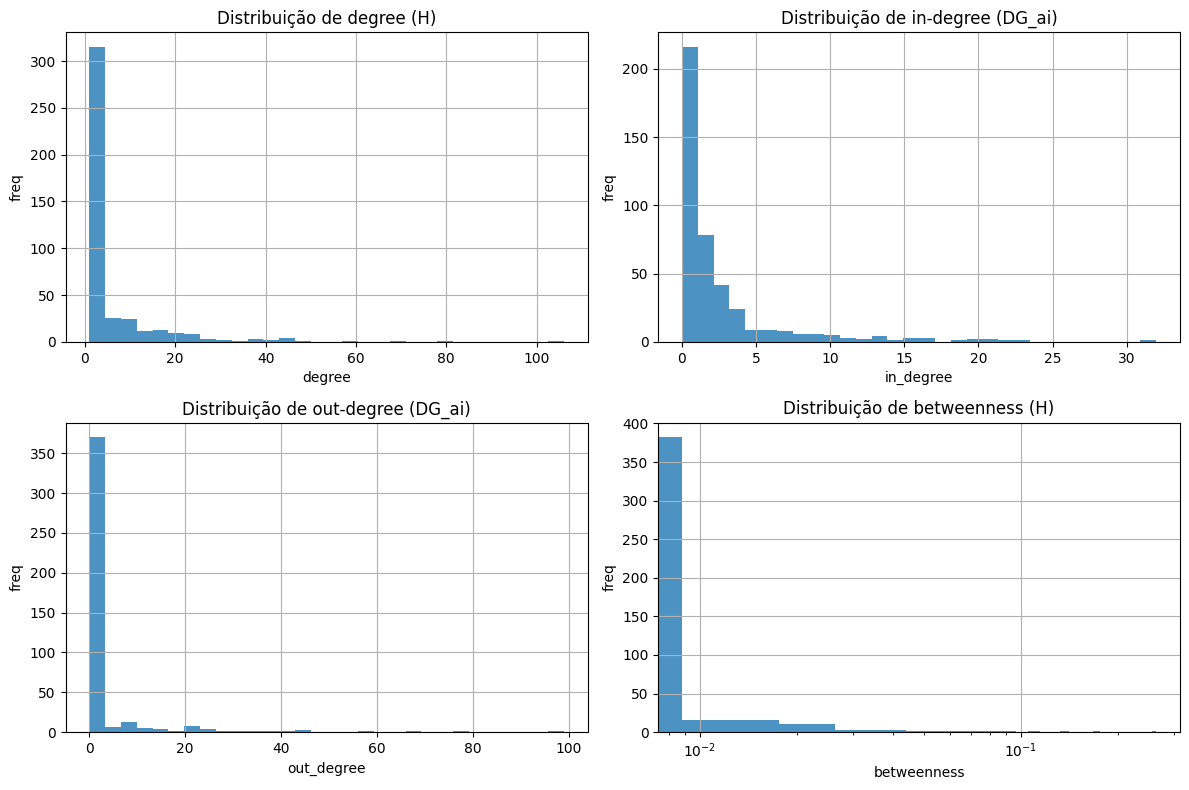

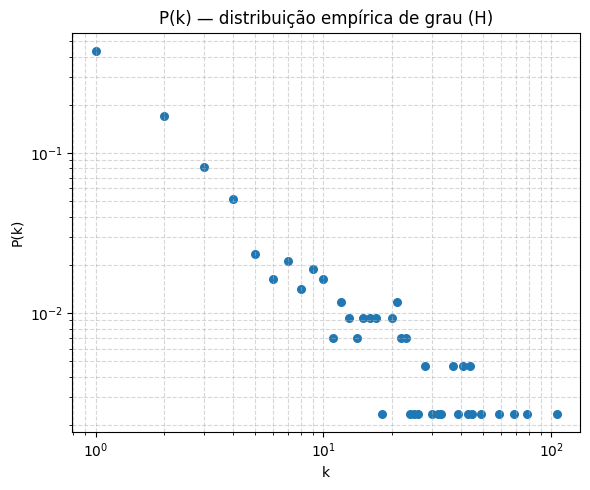

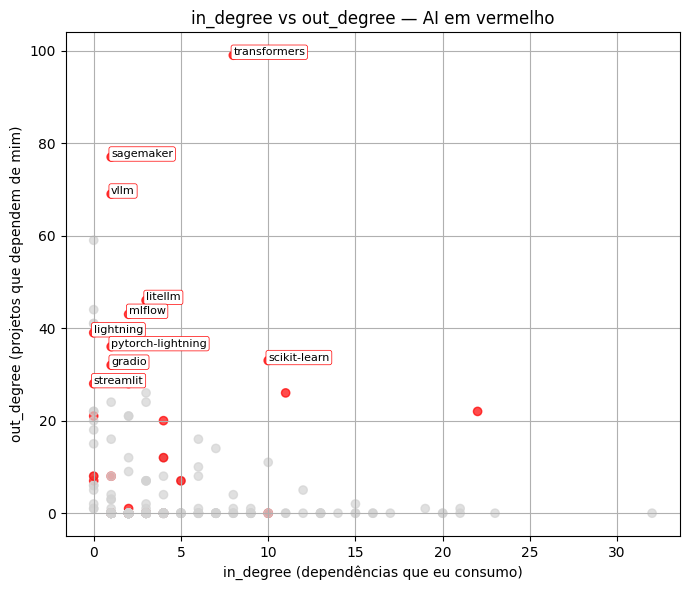

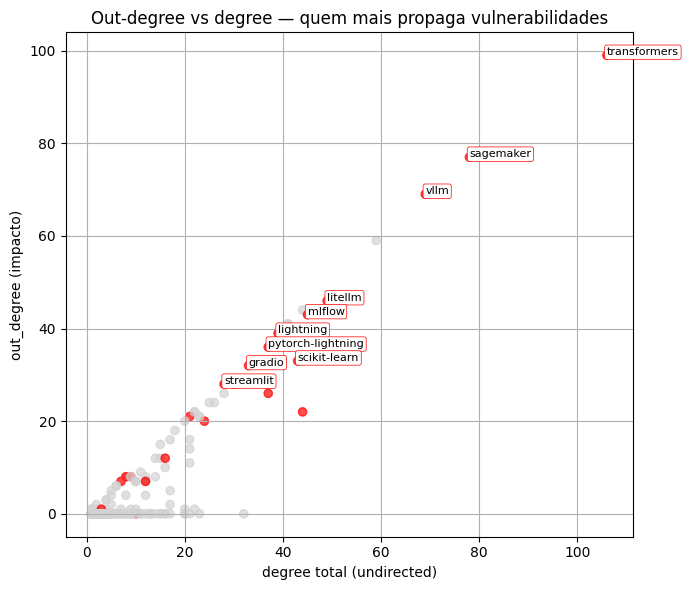

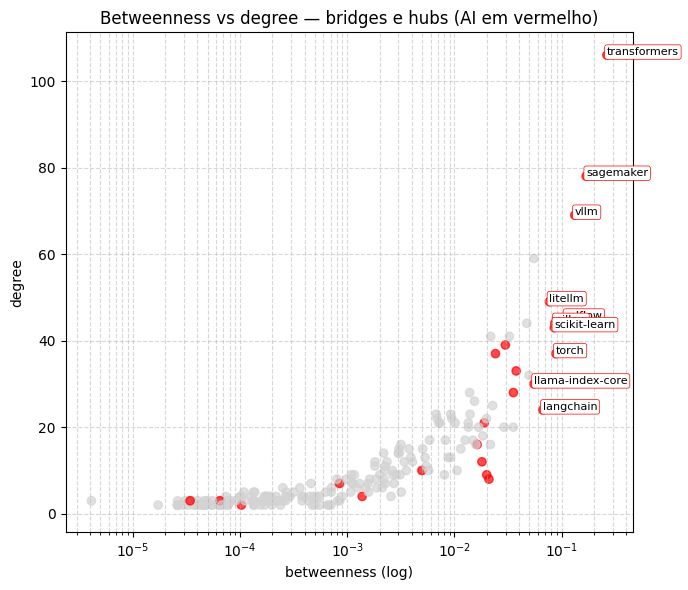

Original λ_c  : 0.0384
Random   λ_c  : 0.0420 (imunização aleatória)
Targeted λ_c  : 0.1035 (imunizando hubs)


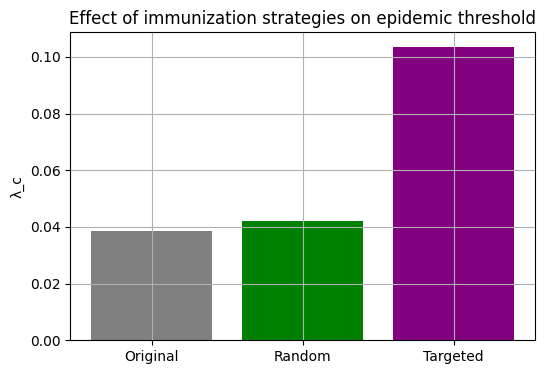


==== transformers ====


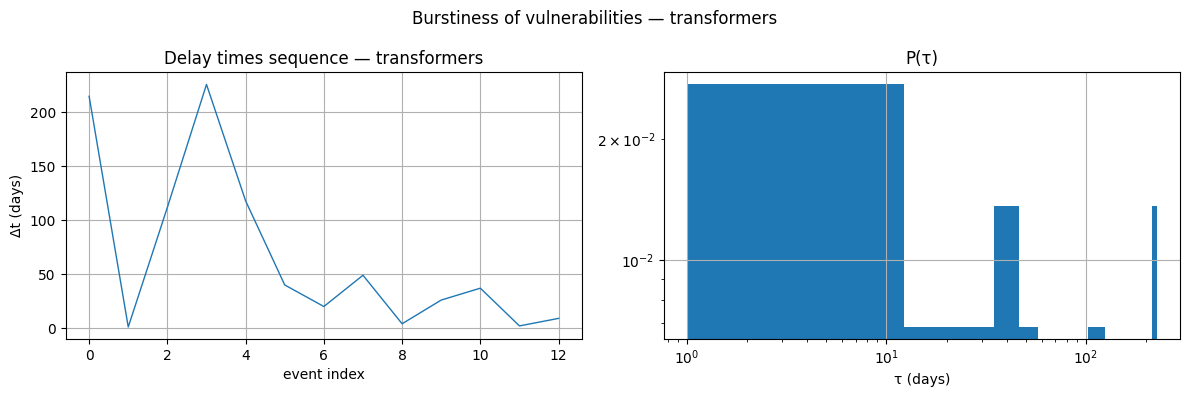


==== torch ====


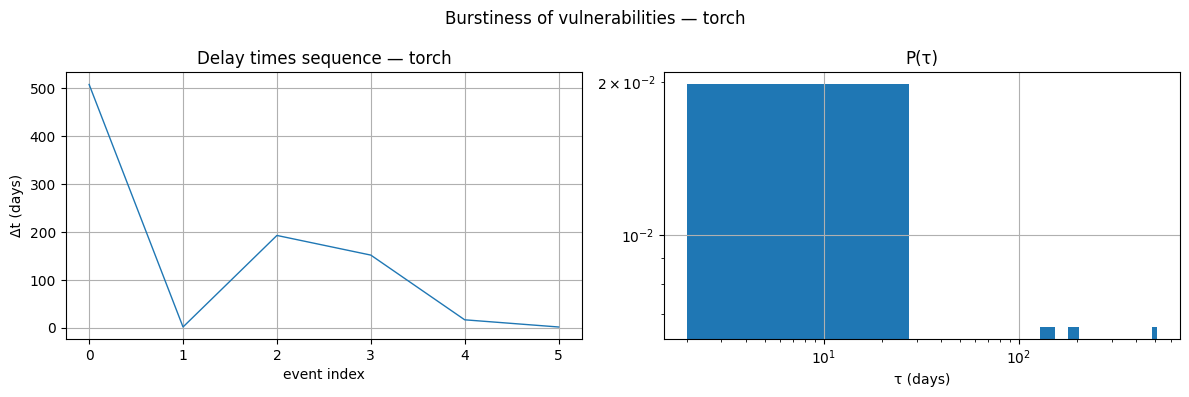


==== litellm ====


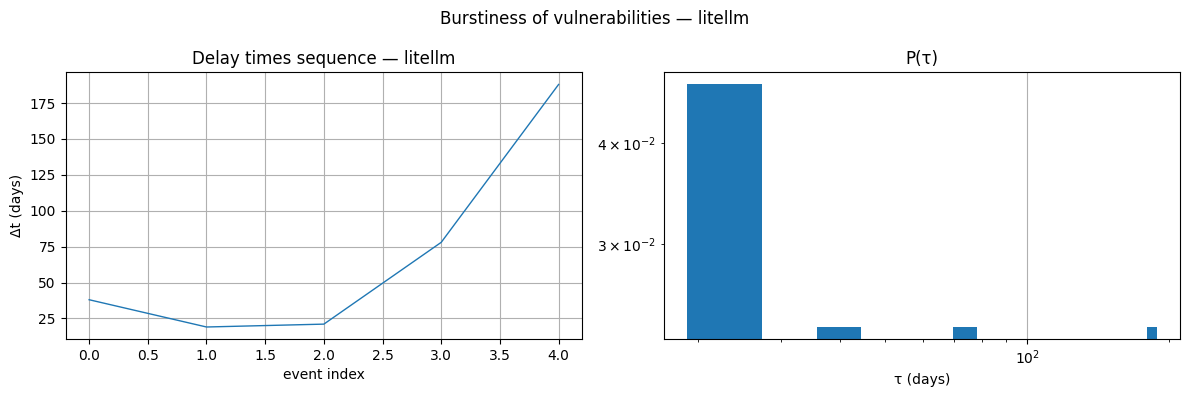


==== pillow ====


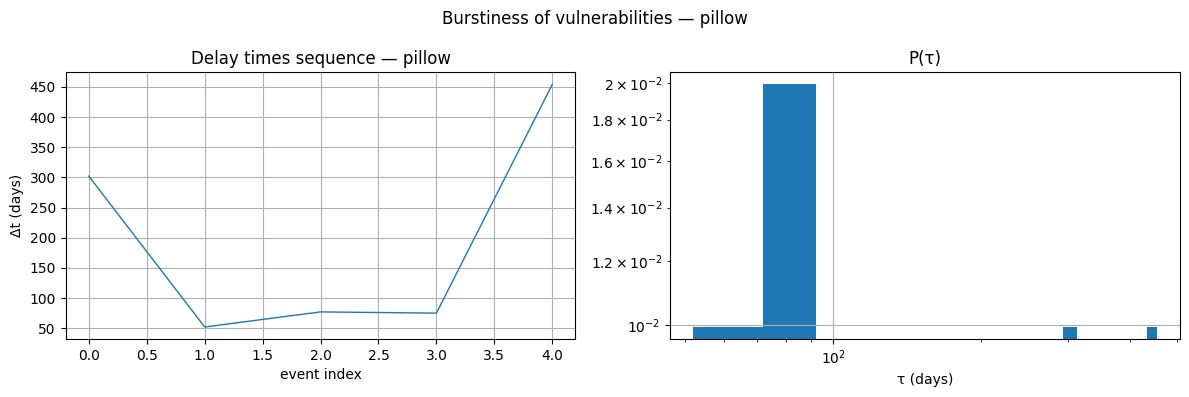

Top 15 libs por risco de próximo surto:


package  degree  betweenness  in_degree  out_degree  is_ai  \
347      transformers     106     0.263782          8          99   True   
191              vllm      69     0.132432          1          69   True   
324         sagemaker      78     0.168927          1          77   True   
323            mlflow      45     0.108352          2          43   True   
381           litellm      49     0.076706          3          46   True   
273            gradio      33     0.037611          1          32   True   
295        open-webui      44     0.047250          0          44  False   
130             feast      59     0.055090          0          59  False   
37             pillow      44     0.086185         22          22   True   
247             torch      37     0.087987         11          26   True   
351      scikit-learn      43     0.085279         10          33   True   
19   llama-index-core      30     0.055096          2          28   True   
321            sglang      41     0.032497          0          41  False   
256         lightning      39     0.029817          0          39   True   
154         langchain      24     0.066556          4          20   True   

         color  recent_vulns  deg_norm  bet_norm  rec_norm  risk_score  
347        red          18.0  1.000000  1.000000  0.391304    0.878261  
191        red          25.0  0.650943  0.502050  0.543478    0.569893  
324        red           3.0  0.735849  0.640402  0.065217    0.563544  
323        red          46.0  0.424528  0.410762  1.000000    0.534116  
381        red          14.0  0.462264  0.290795  0.304348    0.362093  
273        red          37.0  0.311321  0.142582  0.804348    0.342431  
295  lightgray          24.0  0.415094  0.179125  0.521739    0.342035  
130  lightgray           1.0  0.556604  0.208848  0.021739    0.310528  
37         red           3.0  0.415094  0.326727  0.065217    0.309772  
247        red           7.0  0.349057  0.333559  0.152174    0.303481  
351        red           1.0  0.405660  0.323295  0.021739    0.295930  
19         red           8.0  0.283019  0.208869  0.173913    0.231538  
321  lightgray           1.0  0.386792  0.123196  0.021739    0.208343  
256        red           2.0  0.367925  0.113038  0.043478    0.201081  
154        red           2.0  0.226415  0.252313  0.043478    0.200187

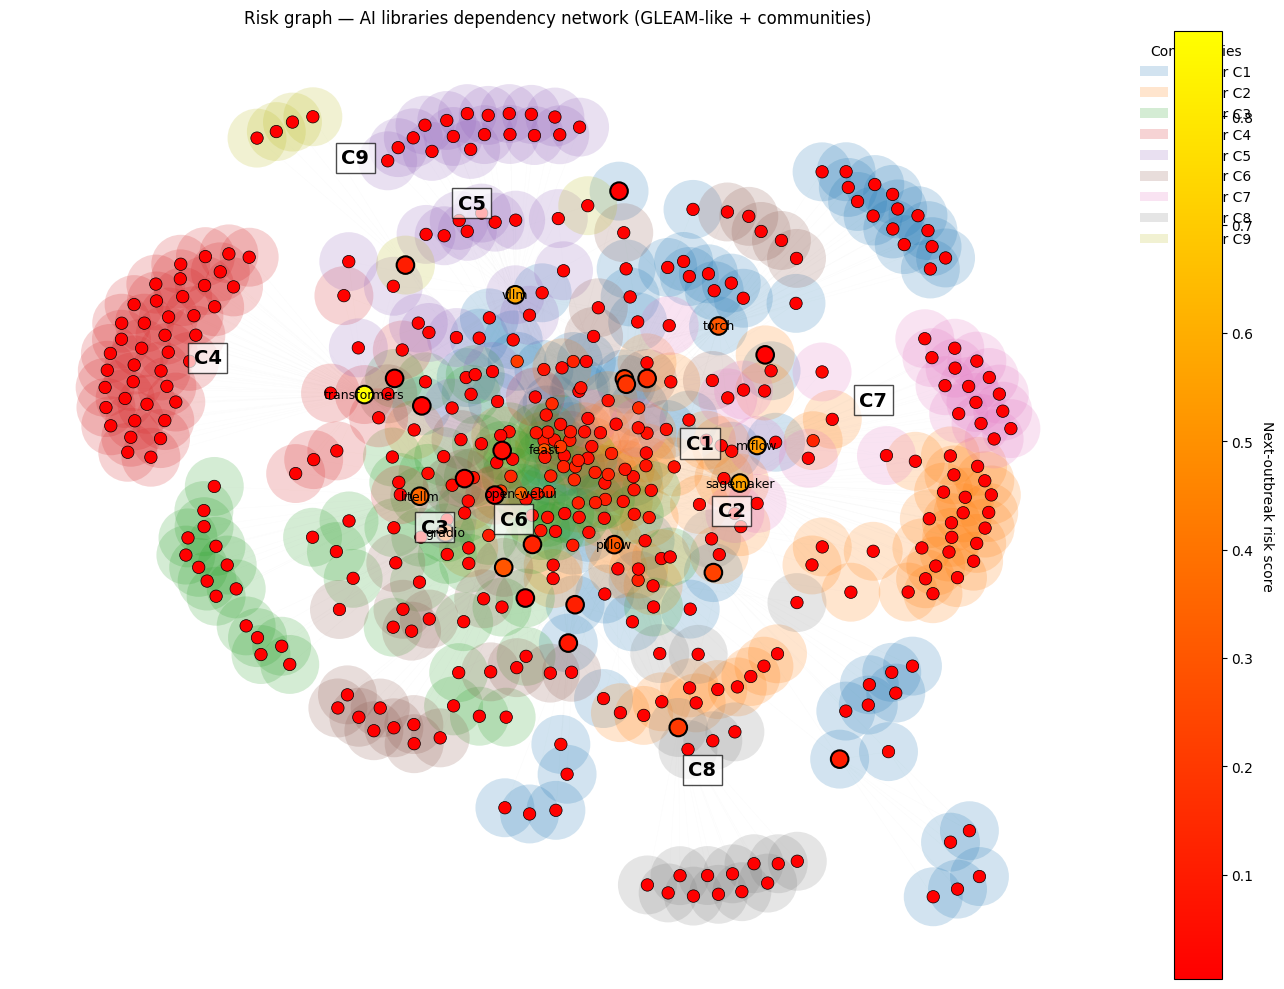

===== NETWORK EPIDEMICS REPORT (AI DEPENDENCIES) =====
Nodes: 427  Edges: 1272
⟨k⟩ = 5.96
⟨k²⟩ = 155.04
Degree exponent α ≈ 1.60
Epidemic threshold λ_c = 0.0384
Chosen β=0.25, μ=0.1, λ=2.500
>> SIS regime: λ > λ_c → estado endêmico de vulnerabilidades provável.

Top 10 hubs (by degree):
          package  degree  in_degree  out_degree  betweenness
347  transformers     106          8          99     0.263782
324     sagemaker      78          1          77     0.168927
191          vllm      69          1          69     0.132432
130         feast      59          0          59     0.055090
381       litellm      49          3          46     0.076706
323        mlflow      45          2          43     0.108352
37         pillow      44         22          22     0.086185
295    open-webui      44          0          44     0.047250
351  scikit-learn      43         10          33     0.085279
213          agno      41          0          41     0.021743

Top 10 predicted next-outbrea

In [58]:
# %% [markdown]
# # Network Epidemics of AI Libraries (SIS, Scale-Free, Immunization & Prediction)
#
# Metodologia inspirada no Cap. 10 (Network Epidemics), aplicada à rede de
# dependências de bibliotecas de IA (AI_LIBS):
#
# - Teste de rede scale-free (P(k), α, λ_c)
# - Modelo SIS em mean-field (i(t), estado endêmico)
# - SIS na rede real das libs de IA
# - Hubs / super-spreaders (grau, betweenness, in_degree, out_degree)
# - Estratégias de vacinação (random x targeted hubs)
# - Padrões bursty (inter-event times de vulnerabilidades)
# - Predição GLEAM-like de próximo surto (risk graph + clusters)
#
# Pré-requisitos:
# - CSV de arestas: python_dependencies_edges.csv (source, target)
# - CSV Snyk: top_pypi_snyk_timeline_20221112_20251112.csv

# %%
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import powerlaw

from collections import Counter
from IPython.display import display

from networkx.algorithms import community
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

EDGES_PATH = "python_dependencies_edges.csv"
TIMELINE_PATH = "outputs/top_pypi_snyk_timeline_20221112_20251112.csv"

# %% [markdown]
# ## 1. Construir DG_all / UG_all a partir do CSV de dependências

# %%
edges = pd.read_csv(EDGES_PATH)

expected_cols = {"source", "target"}
if not expected_cols.issubset(set(edges.columns)):
    raise ValueError(f"CSV de arestas precisa ter colunas {expected_cols}, mas tem: {edges.columns}")

print("Amostra de arestas:")
display(edges.head())

edges["source"] = edges["source"].astype(str)
edges["target"] = edges["target"].astype(str)

# A -> B se A depende de B
DG_all = nx.DiGraph()
DG_all.add_edges_from(edges[["source", "target"]].itertuples(index=False, name=None))
DG_all.remove_edges_from(list(nx.selfloop_edges(DG_all)))

UG_all = DG_all.to_undirected()
UG_all.remove_edges_from(list(nx.selfloop_edges(UG_all)))

if not nx.is_connected(UG_all):
    largest_cc = max(nx.connected_components(UG_all), key=len)
    UG_clean = UG_all.subgraph(largest_cc).copy()
else:
    UG_clean = UG_all.copy()

print(f"DG_all: {DG_all.number_of_nodes()} nodes, {DG_all.number_of_edges()} edges")
print(f"UG_clean: {UG_clean.number_of_nodes()} nodes, {UG_clean.number_of_edges()} edges")

# %% [markdown]
# ## 2. Definir AI_LIBS e extrair subgrafo 1-hop

# %%
AI_LIBS = [
    'torch','tensorflow','keras','pytorch-lightning','lightning',
    'scikit-learn','xgboost','lightgbm','catboost',
    'transformers','sentence-transformers','tokenizers',
    'langchain','langchain-core','langchain-community',
    'llama-index','llama-index-core',
    'vllm','litellm','openai','mlflow','wandb','clearml','sagemaker',
    'gradio','streamlit','opencv-python','pillow'
]
AI_SET = {p.lower() for p in AI_LIBS}

ai_nodes = {n for n in UG_clean.nodes() if n.lower() in AI_SET}
ai_hop = set(ai_nodes)
for n in ai_nodes:
    ai_hop.update(UG_clean.neighbors(n))

H = UG_clean.subgraph(ai_hop).copy()
print("AI 1-hop subgraph:", H.number_of_nodes(), "nodes,", H.number_of_edges(), "edges")

# %% [markdown]
# ## 3. Carregar timeline Snyk e filtrar AI_LIBS

# %%
timeline = pd.read_csv(TIMELINE_PATH)

timeline.columns = [c.lower() for c in timeline.columns]

if "package" not in timeline.columns:
    raise ValueError(f"CSV Snyk precisa ter coluna 'package'. Colunas: {timeline.columns}")

timeline["package"] = timeline["package"].astype(str).str.lower()

date_candidates = ["disclosed_date", "disclosure_date", "published_date"]
disc_col = None
for c in date_candidates:
    if c in timeline.columns:
        disc_col = c
        break
if disc_col is None:
    raise ValueError(f"Não encontrei coluna de data de divulgação. Colunas: {timeline.columns}")

timeline["disclosed_date"] = pd.to_datetime(timeline[disc_col])

if "end_date_effective" in timeline.columns:
    timeline["end_date_effective"] = pd.to_datetime(timeline["end_date_effective"])
else:
    timeline["end_date_effective"] = timeline["disclosed_date"] + pd.Timedelta(days=365)

timeline_ai = timeline[timeline["package"].isin(AI_SET)].copy()
print("Registros Snyk para AI_LIBS:", len(timeline_ai))
display(timeline_ai.head())

# %% [markdown]
# ## 4. Teste de Scale-Free (P(k), α) e limiar epidêmico λ_c

# %%
degrees = [d for _, d in H.degree()]
k_arr = np.array(degrees)

print("⟨k⟩ =", k_arr.mean())
print("⟨k²⟩ =", (k_arr**2).mean())

k_nonzero = k_arr[k_arr > 0]
fit = powerlaw.Fit(k_nonzero, discrete=True, verbose=False)
alpha = fit.power_law.alpha
xmin = fit.power_law.xmin
R, p = fit.distribution_compare('power_law', 'lognormal')

print(f"α (exponent) = {alpha:.2f}")
print("xmin =", xmin)
print("Power law vs lognormal: R =", R, "p =", p)

fig = fit.plot_pdf(linewidth=2, label="data")
fit.power_law.plot_pdf(ax=fig, linestyle='--', color='black', label='power-law fit')
plt.xlabel("Degree k")
plt.ylabel("P(k)")
plt.title("Degree distribution — AI 1-hop dependency network")
plt.legend()
plt.show()

lambda_c = k_arr.mean() / ((k_arr**2).mean() + 1e-9)
print(f"\nEpidemic threshold λ_c = {lambda_c:.4f}")
if lambda_c < 0.05:
    print(">> Limiar praticamente zero: típico de rede altamente heterogênea / scale-free.")
else:
    print(">> Limiar mais alto: rede mais próxima de aleatória.")

# %% [markdown]
# ## 5. Modelo SIS mean-field (Cap. 10) para a rede de IA

# %%
k_mean = k_arr.mean()

beta = 0.25
mu = 0.10
lam = beta / mu
print(f"β={beta}, μ={mu}, λ={lam:.3f}, λ/λ_c ≈ {lam/lambda_c:.2f}")

def SIS_mean_field(beta, mu, k_mean, steps=40, i0=0.01):
    i = i0
    hist = [i0]
    for _ in range(steps):
        i = i + beta * k_mean * i * (1 - i) - mu * i
        i = max(0.0, min(1.0, i))
        hist.append(i)
    return np.array(hist)

sis_curve = SIS_mean_field(beta, mu, k_mean, steps=60, i0=0.01)
i_inf = max(0.0, 1 - mu / (beta * k_mean))

t = np.arange(len(sis_curve))
plt.plot(t, sis_curve, color='green', linewidth=3, label="i(t) mean-field")
plt.axhline(i_inf, linestyle='--', color='gray', label=f"i(∞) teórico ≈ {i_inf:.2f}")
plt.xlabel("t (steps)")
plt.ylabel("i(t) — fração de libs vulneráveis")
plt.title("SIS mean-field on AI dependency network")
plt.legend()
plt.show()

# %% [markdown]
# ### 5.1 SIS na rede real (DG_all restrito às libs de IA 1-hop)

# %%
DG_ai = DG_all.subgraph(H.nodes()).copy()
print("DG_ai:", DG_ai.number_of_nodes(), "nodes,", DG_ai.number_of_edges(), "edges")

def simulate_SIS_graph(G: nx.DiGraph, beta=0.25, mu=0.1, steps=40,
                       initial_infected=None, seed=42):
    rng = np.random.default_rng(seed)
    nodes = list(G.nodes())
    infected = {n: False for n in nodes}
    
    if initial_infected is None:
        today = timeline["disclosed_date"].max()
        recency_cut = today - pd.Timedelta(days=365)
        active_pkgs = set(
            timeline_ai[timeline_ai["disclosed_date"] >= recency_cut]["package"].unique()
        )
        initial_infected = [n for n in nodes if n.lower() in active_pkgs]
    
    if not initial_infected:
        initial_infected = [rng.choice(nodes)]
    
    for n in initial_infected:
        if n in infected:
            infected[n] = True
    
    history = []
    for _ in range(steps):
        new_state = infected.copy()
        for n in nodes:
            if infected[n]:
                if rng.random() < mu:
                    new_state[n] = False
            else:
                for neigh in G.predecessors(n):
                    if infected[neigh] and rng.random() < beta:
                        new_state[n] = True
                        break
        infected = new_state
        history.append(infected.copy())
    
    return history

sis_hist = simulate_SIS_graph(DG_ai, beta=beta, mu=mu, steps=60)
infected_counts = [sum(1 for v in state.values() if v) for state in sis_hist]
frac_infected = np.array(infected_counts) / DG_ai.number_of_nodes()

plt.plot(frac_infected, linewidth=2)
plt.xlabel("t (steps)")
plt.ylabel("fraction infected")
plt.title("SIS simulation on AI 1-hop dependency DiGraph")
plt.show()

# %% [markdown]
# ## 6. Super-spreaders: grau, betweenness, in_degree, out_degree

# %%
deg_dict  = dict(H.degree())
bet_dict  = nx.betweenness_centrality(H, normalized=True)
in_dict   = dict(DG_ai.in_degree(H.nodes()))
out_dict  = dict(DG_ai.out_degree(H.nodes()))

centrality_df = pd.DataFrame({
    "package":    list(H.nodes()),
    "degree":     [deg_dict[n] for n in H.nodes()],
    "betweenness":[bet_dict[n] for n in H.nodes()],
    "in_degree":  [in_dict.get(n, 0) for n in H.nodes()],
    "out_degree": [out_dict.get(n, 0) for n in H.nodes()],
})
centrality_df["is_ai"] = centrality_df["package"].str.lower().isin(AI_SET)

print("Top hubs (degree):")
display(centrality_df.sort_values("degree", ascending=False).head(15))

print("\nTop bridges (betweenness):")
display(centrality_df.sort_values("betweenness", ascending=False).head(15))

# %% [markdown]
# ### 6.1 Distribuições das métricas (degree, in_degree, out_degree, betweenness)

# %%
deg_vals  = centrality_df["degree"].values
in_vals   = centrality_df["in_degree"].values
out_vals  = centrality_df["out_degree"].values
bet_vals  = centrality_df["betweenness"].values

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].hist(deg_vals, bins=30, alpha=0.8)
axes[0, 0].set_xlabel("degree")
axes[0, 0].set_ylabel("freq")
axes[0, 0].set_title("Distribuição de degree (H)")

axes[0, 1].hist(in_vals, bins=30, alpha=0.8)
axes[0, 1].set_xlabel("in_degree")
axes[0, 1].set_ylabel("freq")
axes[0, 1].set_title("Distribuição de in-degree (DG_ai)")

axes[1, 0].hist(out_vals, bins=30, alpha=0.8)
axes[1, 0].set_xlabel("out_degree")
axes[1, 0].set_ylabel("freq")
axes[1, 0].set_title("Distribuição de out-degree (DG_ai)")

axes[1, 1].hist(bet_vals, bins=30, alpha=0.8)
axes[1, 1].set_xlabel("betweenness")
axes[1, 1].set_ylabel("freq")
axes[1, 1].set_title("Distribuição de betweenness (H)")
axes[1, 1].set_xscale("log")

plt.tight_layout()
plt.show()

# P(k) empírico em log-log
deg_counts = Counter(deg_vals)
k_vals  = np.array(sorted(deg_counts.keys()))
pk_vals = np.array([deg_counts[k] for k in k_vals]) / len(deg_vals)

plt.figure(figsize=(6, 5))
plt.scatter(k_vals, pk_vals, s=30)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("k")
plt.ylabel("P(k)")
plt.title("P(k) — distribuição empírica de grau (H)")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# %% [markdown]
# ### 6.2 Scatter plots: quem é mais exposto x quem mais impacta

# %%
centrality_df["color"] = np.where(centrality_df["is_ai"], "red", "lightgray")

# in_degree vs out_degree → exposto x impacto
plt.figure(figsize=(7, 6))
plt.scatter(
    centrality_df["in_degree"], centrality_df["out_degree"],
    c=centrality_df["color"], alpha=0.7
)
plt.xlabel("in_degree (dependências que eu consumo)")
plt.ylabel("out_degree (projetos que dependem de mim)")
plt.title("in_degree vs out_degree — AI em vermelho")
plt.grid(True)

for _, row in (centrality_df[centrality_df["is_ai"]]
               .sort_values("out_degree", ascending=False)
               .head(10)).iterrows():
    plt.text(
        row["in_degree"], row["out_degree"], row["package"],
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="red", lw=0.5)
    )

plt.tight_layout()
plt.show()

# out_degree vs degree total
plt.figure(figsize=(7, 6))
plt.scatter(
    centrality_df["degree"], centrality_df["out_degree"],
    c=centrality_df["color"], alpha=0.7
)
plt.xlabel("degree total (undirected)")
plt.ylabel("out_degree (impacto)")
plt.title("Out-degree vs degree — quem mais propaga vulnerabilidades")
plt.grid(True)

for _, row in (centrality_df[centrality_df["is_ai"]]
               .sort_values("out_degree", ascending=False)
               .head(10)).iterrows():
    plt.text(
        row["degree"], row["out_degree"], row["package"],
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="red", lw=0.5)
    )

plt.tight_layout()
plt.show()

# betweenness vs degree (continua como SPOF/hub)
plt.figure(figsize=(7, 6))
plt.scatter(
    centrality_df["betweenness"], centrality_df["degree"],
    c=centrality_df["color"], alpha=0.7
)
plt.xscale("log")
plt.xlabel("betweenness (log)")
plt.ylabel("degree")
plt.title("Betweenness vs degree — bridges e hubs (AI em vermelho)")
plt.grid(True, which="both", ls="--", alpha=0.5)

for _, row in (centrality_df[centrality_df["is_ai"]]
               .sort_values("betweenness", ascending=False)
               .head(10)).iterrows():
    plt.text(
        row["betweenness"], row["degree"], row["package"],
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="red", lw=0.5)
    )

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 7. Vaccination Strategies in Scale-Free Networks (AI libs)

# %%
def compute_lambda_c(G):
    k = np.array([d for _, d in G.degree()])
    return k.mean() / ((k**2).mean() + 1e-9)

orig_lambda_c = compute_lambda_c(H)
N = H.number_of_nodes()
cut = max(1, int(N * 0.05))   # 5% dos nós

top_hubs = centrality_df.sort_values("degree", ascending=False)["package"].head(cut).tolist()
H_target = H.copy()
H_target.remove_nodes_from(top_hubs)
lambda_target = compute_lambda_c(H_target)

rng = np.random.default_rng(42)
rand_nodes = rng.choice(list(H.nodes()), size=cut, replace=False)
H_random = H.copy()
H_random.remove_nodes_from(rand_nodes)
lambda_random = compute_lambda_c(H_random)

print(f"Original λ_c  : {orig_lambda_c:.4f}")
print(f"Random   λ_c  : {lambda_random:.4f} (imunização aleatória)")
print(f"Targeted λ_c  : {lambda_target:.4f} (imunizando hubs)")

labels = ["Original", "Random", "Targeted"]
vals = [orig_lambda_c, lambda_random, lambda_target]

plt.figure(figsize=(6,4))
plt.bar(labels, vals, color=["gray", "green", "purple"])
plt.ylabel("λ_c")
plt.title("Effect of immunization strategies on epidemic threshold")
plt.show()

# %% [markdown]
# ## 8. Bursty Contact Patterns (inter-event times de vulnerabilidades)

# %%
def inter_event_times(pkg, df):
    s = df[df["package"] == pkg].sort_values("disclosed_date")["disclosed_date"]
    if len(s) < 3:
        return None
    return s.diff().dt.days.dropna()

def plot_burstiness(pkg):
    tau = inter_event_times(pkg, timeline_ai)
    print(f"\n==== {pkg} ====")
    if tau is None or len(tau) == 0:
        print("Poucos eventos para analisar.")
        return
    tau = tau[tau > 0]
    if len(tau) == 0:
        print("Intervalos nulos.")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1.plot(range(len(tau)), tau.values, linewidth=1)
    ax1.set_title(f"Delay times sequence — {pkg}")
    ax1.set_xlabel("event index")
    ax1.set_ylabel("Δt (days)")
    
    ax2.hist(tau.values, bins=20, density=True)
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    ax2.set_title("P(τ)")
    ax2.set_xlabel("τ (days)")
    plt.suptitle(f"Burstiness of vulnerabilities — {pkg}")
    plt.tight_layout()
    plt.show()

for pkg in ["transformers", "torch", "litellm", "pillow"]:
    plot_burstiness(pkg)

# %% [markdown]
# ## 9. GLEAM-like Prediction: próximo surto (risk score por biblioteca)

# %%
cut_date = timeline["disclosed_date"].max() - pd.Timedelta(days=730)
recent = timeline[timeline["disclosed_date"] >= cut_date]

recent_counts = recent.groupby("package").size()
centrality_df["recent_vulns"] = centrality_df["package"].str.lower().map(recent_counts).fillna(0)

centrality_df["deg_norm"] = centrality_df["degree"] / (centrality_df["degree"].max() or 1)
centrality_df["bet_norm"] = centrality_df["betweenness"] / (centrality_df["betweenness"].max() or 1)
centrality_df["rec_norm"] = centrality_df["recent_vulns"] / (centrality_df["recent_vulns"].max() or 1)

centrality_df["risk_score"] = (
    0.4 * centrality_df["deg_norm"] +
    0.4 * centrality_df["bet_norm"] +
    0.2 * centrality_df["rec_norm"]
)

print("Top 15 libs por risco de próximo surto:")
display(centrality_df.sort_values("risk_score", ascending=False).head(15))

# %% [markdown]
# ### 9.1 Risk Graph — grafo colorido por risco + clusters (halos)

# %%
pos = nx.spring_layout(H, seed=42)

risk_map = centrality_df.set_index("package")["risk_score"]

fig, ax = plt.subplots(figsize=(14,10))

# comunidades para halos
try:
    comms = list(community.greedy_modularity_communities(H))
except Exception:
    comms = [set(H.nodes())]

palette_comm = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())

for i, cset in enumerate(sorted(comms, key=len, reverse=True)):
    ccol = mcolors.to_rgba(palette_comm[i % len(palette_comm)], alpha=0.20)
    nx.draw_networkx_nodes(
        H, pos,
        nodelist=list(cset),
        node_size=1800,
        node_color=[ccol],
        edgecolors='none',
        ax=ax
    )
    cx = np.mean([pos[n][0] for n in cset])
    cy = np.mean([pos[n][1] for n in cset])
    ax.text(
        cx, cy, f"C{i+1}",
        bbox=dict(facecolor='white', alpha=0.7),
        ha='center', fontsize=14, fontweight='bold'
    )

nx.draw_networkx_edges(H, pos, ax=ax, alpha=0.1, width=0.3, edge_color="lightgray")

risk_vals = [risk_map.get(n, 0.0) for n in H.nodes()]
cmap = plt.colormaps.get_cmap("autumn")

nodes = nx.draw_networkx_nodes(
    H, pos, ax=ax,
    node_color=risk_vals,
    cmap=cmap,
    node_size=80,
    linewidths=0.5,
    edgecolors="black"
)

ai_border_nodes = [n for n in H.nodes() if n.lower() in AI_SET]
nx.draw_networkx_nodes(
    H, pos, nodelist=ai_border_nodes,
    node_color=[risk_map.get(n, 0.0) for n in ai_border_nodes],
    cmap=cmap,
    node_size=160,
    linewidths=1.5,
    edgecolors="black",
    ax=ax
)

top_risk = centrality_df.sort_values("risk_score", ascending=False).head(10)["package"].tolist()
labels = {n: n for n in H.nodes() if n in top_risk}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=9, ax=ax)

cbar = fig.colorbar(nodes, ax=ax)
cbar.set_label("Next-outbreak risk score", rotation=270, labelpad=15)

comm_handles = [
    Patch(
        facecolor=mcolors.to_rgba(palette_comm[i % len(palette_comm)], alpha=0.20),
        edgecolor='none',
        label=f"Cluster C{i+1}"
    )
    for i, _ in enumerate(sorted(comms, key=len, reverse=True))
]

ax.legend(
    handles=comm_handles,
    title="Communities",
    frameon=False,
    loc='upper left',
    bbox_to_anchor=(1.02, 1.0)
)

ax.set_title("Risk graph — AI libraries dependency network (GLEAM-like + communities)")
ax.axis("off")
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 10. Relatório final estilo Capítulo 10

# %%
print("===== NETWORK EPIDEMICS REPORT (AI DEPENDENCIES) =====")
print(f"Nodes: {H.number_of_nodes()}  Edges: {H.number_of_edges()}")
print(f"⟨k⟩ = {k_arr.mean():.2f}")
print(f"⟨k²⟩ = {(k_arr**2).mean():.2f}")
print(f"Degree exponent α ≈ {alpha:.2f}")
print(f"Epidemic threshold λ_c = {lambda_c:.4f}")
print(f"Chosen β={beta}, μ={mu}, λ={lam:.3f}")

if lam > lambda_c:
    print(">> SIS regime: λ > λ_c → estado endêmico de vulnerabilidades provável.")
else:
    print(">> SIS regime: λ <= λ_c → vulnerabilidades tenderiam a desaparecer.")

print("\nTop 10 hubs (by degree):")
print(centrality_df.sort_values("degree", ascending=False)
      .head(10)[["package", "degree", "in_degree", "out_degree", "betweenness"]])

print("\nTop 10 predicted next-outbreak libs:")
print(centrality_df.sort_values("risk_score", ascending=False)
      .head(10)[["package", "risk_score", "recent_vulns", "degree", "in_degree", "out_degree", "betweenness"]])


Amostra de arestas:


source                                  target
0   agno                                 aiohttp
1   agno  opentelemetry-exporter-otlp-proto-grpc
2   agno                       typing-extensions
3   agno                                  mem0ai
4   agno                            google-genai

DG_all: 1547 nodes, 3454 edges
UG_clean: 1541 nodes, 3440 edges
AI 1-hop subgraph: 427 nodes, 1272 edges
Registros Snyk para AI_LIBS: 233


package             cve           cwes severity first_affected_version  \
57  pillow  CVE-2023-50447  CWE-94;CWE-95      low                      0   
58  pillow  CVE-2024-28219        CWE-680      low                      0   
59  pillow  CVE-2023-44271        CWE-770     high                      0   
60  pillow   CVE-2023-4863        CWE-787      low                      0   
61  pillow  CVE-2022-45198            NaN     high                      0   

   first_affected_date disclosed_date mitigation_version mitigation_date  \
57                 NaN     2024-01-19             10.2.0      2024-01-02   
58                 NaN     2024-04-03             10.3.0      2024-04-01   
59                 NaN     2023-11-03             10.0.0      2023-07-01   
60                 NaN     2023-09-12             10.0.1      2023-09-15   
61                 NaN     2022-11-14              9.2.0      2022-07-01   

    disclosure_lag_days  time_to_fix_from_first_days  \
57                  NaN                          NaN   
58                  NaN                          NaN   
59                  NaN                          NaN   
60                  NaN                          NaN   
61                  NaN                          NaN   

    time_to_fix_from_disclosure_days fix_semver_type end_date_effective  
57                             -17.0           major         2025-01-18  
58                              -2.0           major         2025-04-03  
59                            -125.0           major         2024-11-02  
60                               3.0           major         2024-09-11  
61                            -136.0           major         2023-11-14

(k)  = 5.95784543325527
(k²) = 155.03981264637002
α (exponent) = 1.60
xmin = 1.0
Power law vs lognormal: R = -15.716405658738706 p = 1.7370737105248793e-09


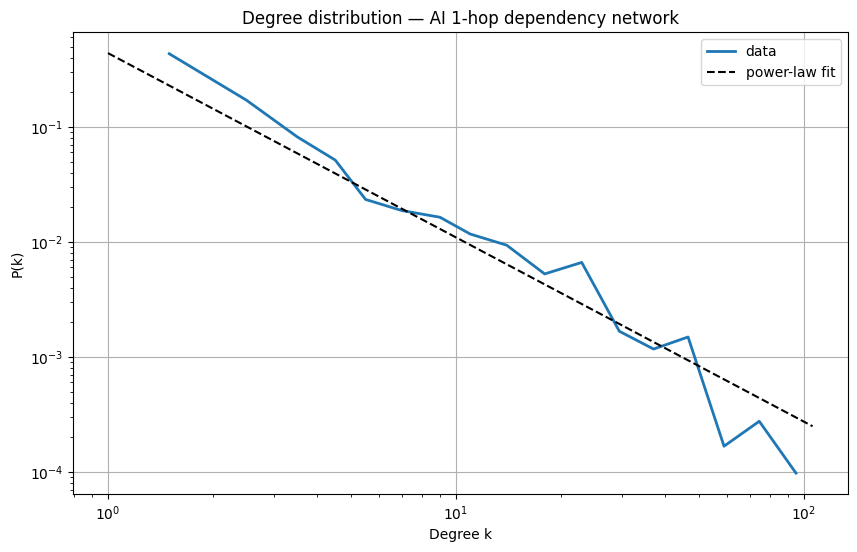

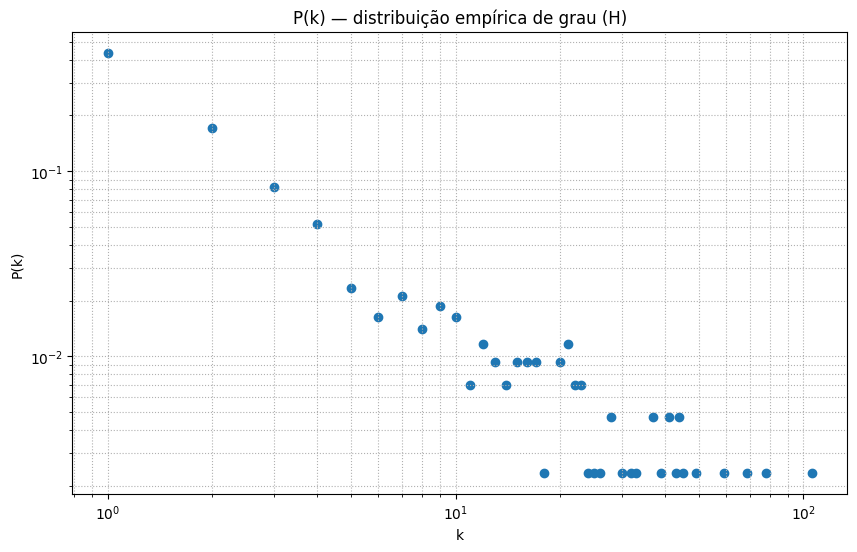


Epidemic threshold λ_c = 0.0384
>> Limiar praticamente zero: típico de rede altamente heterogênea / scale-free.
β=0.25, μ=0.1, λ=2.500, λ/λ_c ≈ 65.06


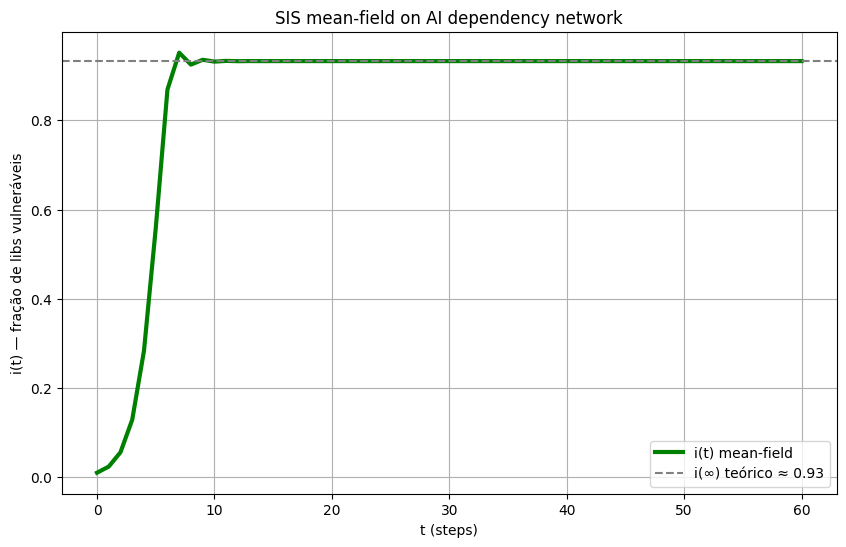

DG_ai: 427 nodes, 1275 edges


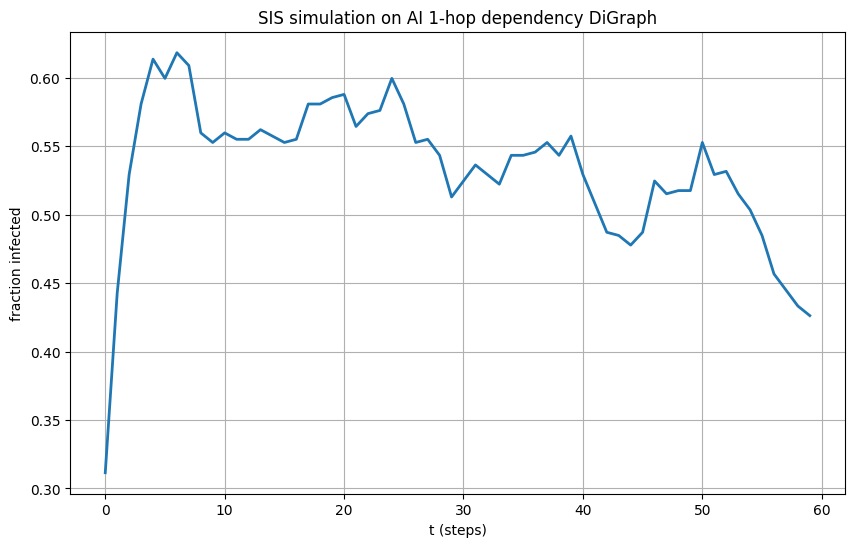

Top hubs (degree):


package  degree  in_degree  out_degree  betweenness  is_ai
347       transformers     106          8          99     0.263782   True
324          sagemaker      78          1          77     0.168927   True
191               vllm      69          1          69     0.132432   True
130              feast      59          0          59     0.055090  False
381            litellm      49          3          46     0.076706   True
323             mlflow      45          2          43     0.108352   True
37              pillow      44         22          22     0.086185   True
295         open-webui      44          0          44     0.047250  False
351       scikit-learn      43         10          33     0.085279   True
213               agno      41          0          41     0.021743  False
321             sglang      41          0          41     0.032497  False
256          lightning      39          0          39     0.029817   True
247              torch      37         11          26     0.087987   True
265  pytorch-lightning      37          1          36     0.024112   True
273             gradio      33          1          32     0.037611   True


Top bridges (betweenness):


package  degree  in_degree  out_degree  betweenness  is_ai
347      transformers     106          8          99     0.263782   True
324         sagemaker      78          1          77     0.168927   True
191              vllm      69          1          69     0.132432   True
323            mlflow      45          2          43     0.108352   True
247             torch      37         11          26     0.087987   True
37             pillow      44         22          22     0.086185   True
351      scikit-learn      43         10          33     0.085279   True
381           litellm      49          3          46     0.076706   True
154         langchain      24          4          20     0.066556   True
19   llama-index-core      30          2          28     0.055096   True
130             feast      59          0          59     0.055090  False
402             numpy      32         32           0     0.049651  False
295        open-webui      44          0          44     0.047250  False
273            gradio      33          1          32     0.037611   True
17          streamlit      28          0          28     0.035421   True

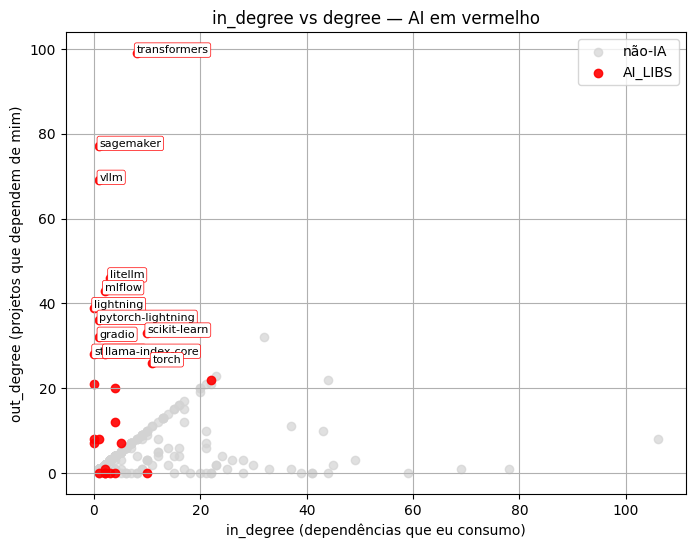

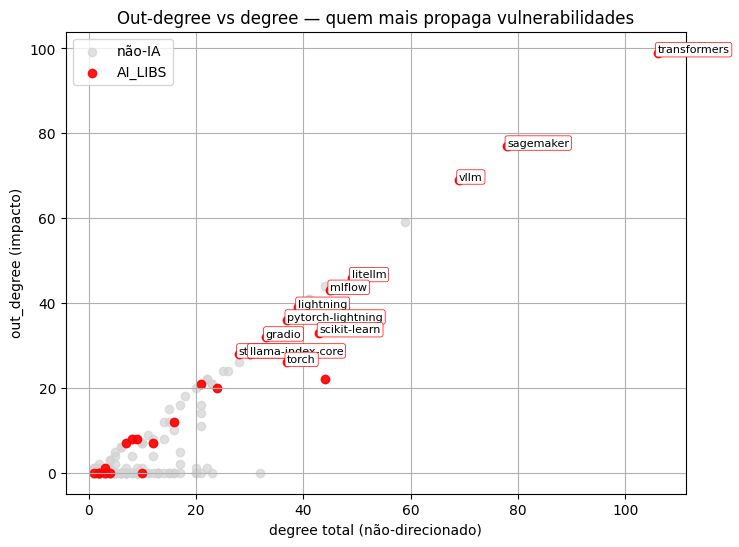

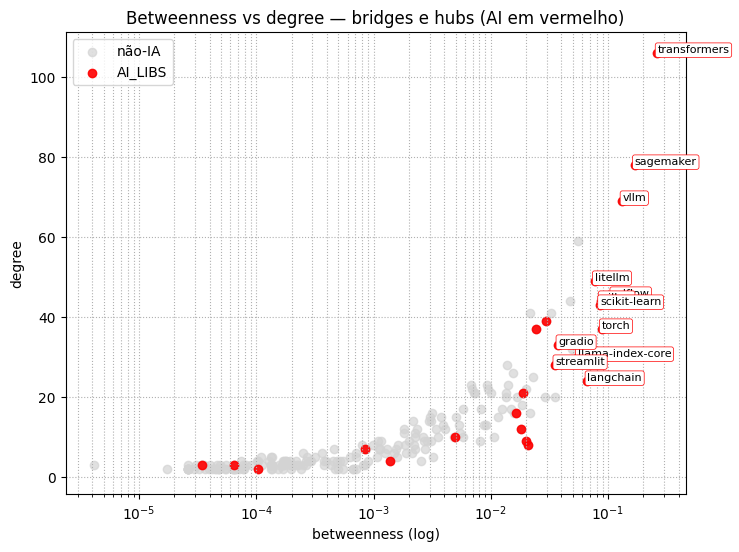

Original λ_c  : 0.0384
Random   λ_c  : 0.0420 (imunização aleatória)
Targeted λ_c  : 0.1035 (imunizando hubs)


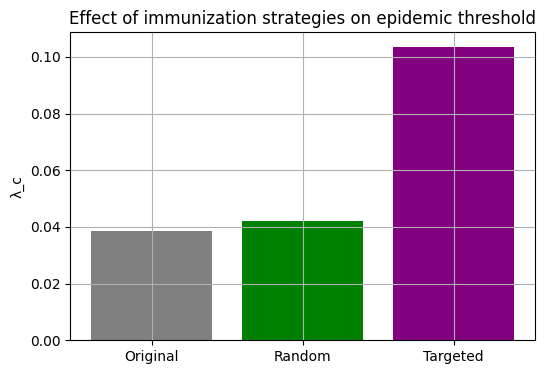


==== transformers ====


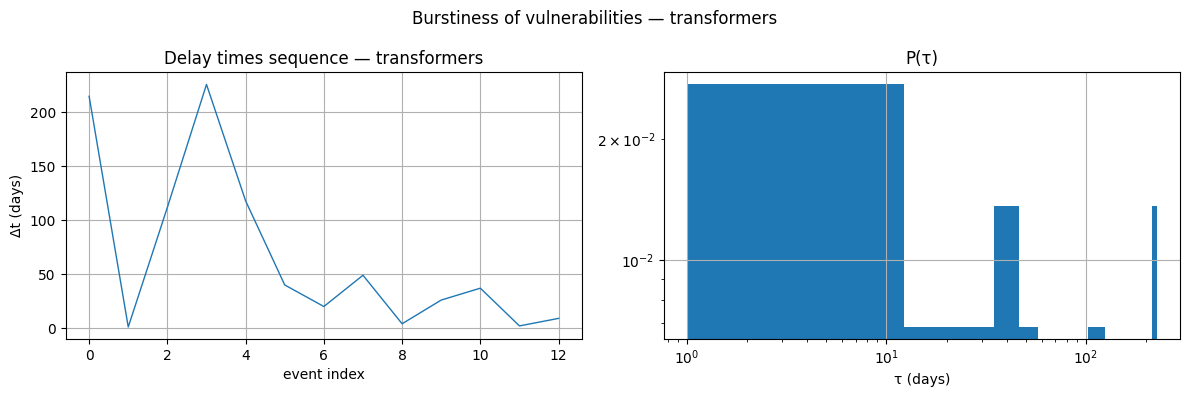


==== torch ====


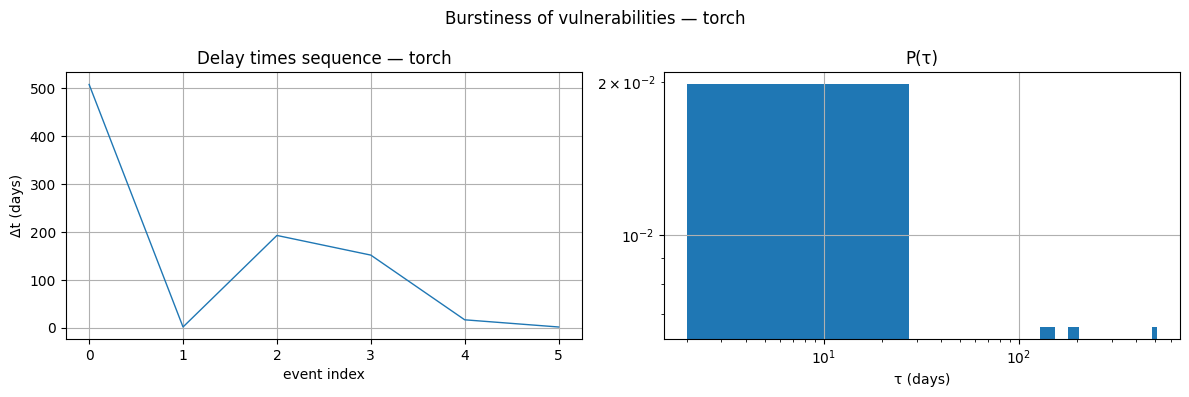


==== litellm ====


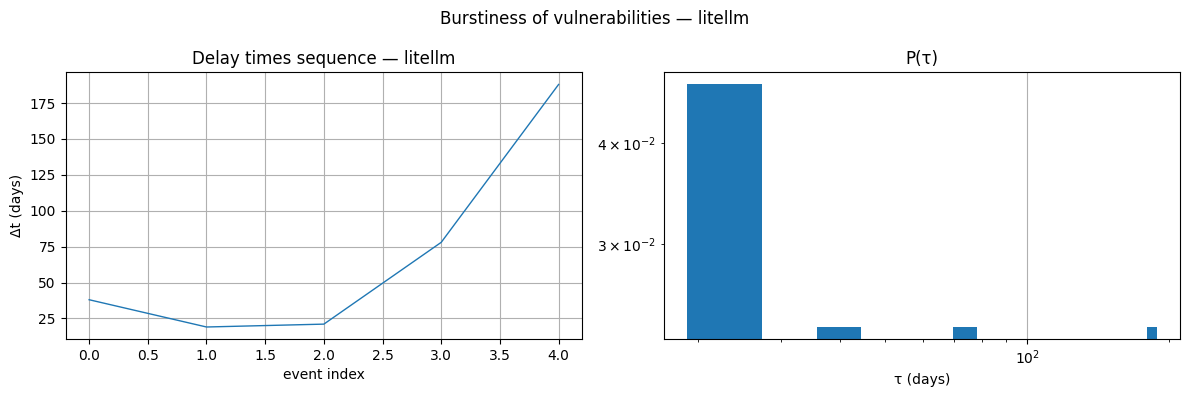


==== pillow ====


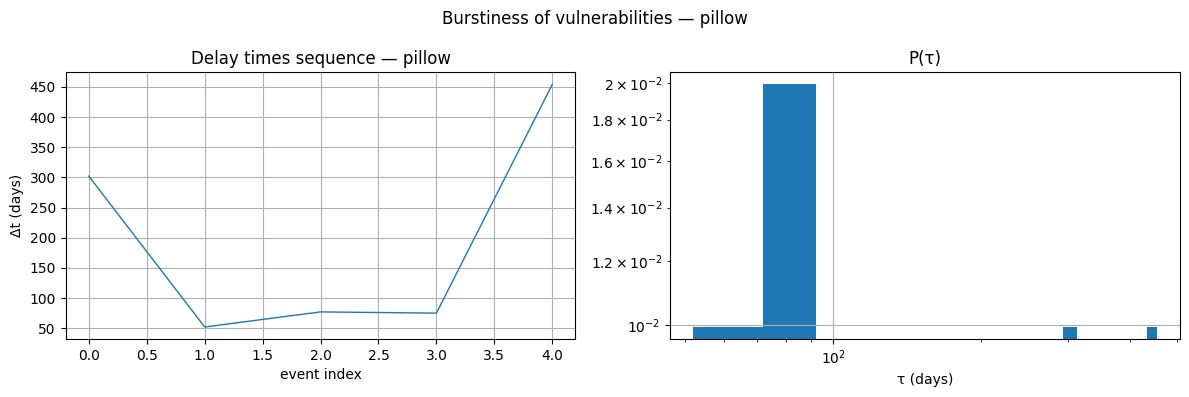

Exemplo de métricas avançadas (top 15 por degree):


package  degree  in_degree  out_degree  betweenness  k_core  \
347       transformers     106          8          99     0.263782       9   
324          sagemaker      78          1          77     0.168927       9   
191               vllm      69          1          69     0.132432       9   
130              feast      59          0          59     0.055090       9   
381            litellm      49          3          46     0.076706       9   
323             mlflow      45          2          43     0.108352       9   
37              pillow      44         22          22     0.086185       9   
295         open-webui      44          0          44     0.047250       9   
351       scikit-learn      43         10          33     0.085279       9   
213               agno      41          0          41     0.021743       9   
321             sglang      41          0          41     0.032497       9   
256          lightning      39          0          39     0.029817       9   
247              torch      37         11          26     0.087987       9   
265  pytorch-lightning      37          1          36     0.024112       9   
273             gradio      33          1          32     0.037611       9   

     community  R0_pkg  hazard_rate  is_ai  
347          4   24.75     0.520548   True  
324          2   19.25     0.082192   True  
191          5   17.25     0.684932   True  
130          2   14.75     0.027397  False  
381          3   11.50     0.383562   True  
323          7   10.75     1.452055   True  
37           2    5.50     0.191781   True  
295          3   11.00     0.657534  False  
351          6    8.25     0.027397   True  
213          2   10.25     0.027397  False  
321          1   10.25     0.027397  False  
256          1    9.75     0.054795   True  
247          1    6.50     0.219178   True  
265          1    9.00     0.054795   True  
273          3    8.00     1.095890   True

Top 15 libs por risco de próximo surto (risk_score):


package  degree  in_degree  out_degree  betweenness  is_ai  \
347      transformers     106          8          99     0.263782   True   
324         sagemaker      78          1          77     0.168927   True   
191              vllm      69          1          69     0.132432   True   
323            mlflow      45          2          43     0.108352   True   
130             feast      59          0          59     0.055090  False   
381           litellm      49          3          46     0.076706   True   
295        open-webui      44          0          44     0.047250  False   
273            gradio      33          1          32     0.037611   True   
351      scikit-learn      43         10          33     0.085279   True   
247             torch      37         11          26     0.087987   True   
37             pillow      44         22          22     0.086185   True   
321            sglang      41          0          41     0.032497  False   
213              agno      41          0          41     0.021743  False   
256         lightning      39          0          39     0.029817   True   
19   llama-index-core      30          2          28     0.055096   True   

     community  k_core  R0_pkg  hazard_rate  deg_norm  out_norm  bet_norm  \
347          4       9   24.75     0.520548  1.000000  1.000000  1.000000   
324          2       9   19.25     0.082192  0.735849  0.777778  0.640402   
191          5       9   17.25     0.684932  0.650943  0.696970  0.502050   
323          7       9   10.75     1.452055  0.424528  0.434343  0.410762   
130          2       9   14.75     0.027397  0.556604  0.595960  0.208848   
381          3       9   11.50     0.383562  0.462264  0.464646  0.290795   
295          3       9   11.00     0.657534  0.415094  0.444444  0.179125   
273          3       9    8.00     1.095890  0.311321  0.323232  0.142582   
351          6       9    8.25     0.027397  0.405660  0.333333  0.323295   
247          1       9    6.50     0.219178  0.349057  0.262626  0.333559   
37           2       9    5.50     0.191781  0.415094  0.222222  0.326727   
321          1       9   10.25     0.027397  0.386792  0.414141  0.123196   
213          2       9   10.25     0.027397  0.386792  0.414141  0.082427   
256          1       9    9.75     0.054795  0.367925  0.393939  0.113038   
19           1       9    7.00     0.219178  0.283019  0.282828  0.208869   

     core_norm  haz_norm   R0_norm  risk_score  
347        1.0  0.345455  1.000000    0.901818  
324        1.0  0.054545  0.777778    0.666765  
191        1.0  0.454545  0.696970    0.657871  
323        1.0  0.963636  0.434343    0.591907  
130        1.0  0.018182  0.595960    0.484605  
381        1.0  0.254545  0.464646    0.478188  
295        1.0  0.436364  0.444444    0.467632  
273        1.0  0.727273  0.323232    0.446841  
351        1.0  0.018182  0.333333    0.398518  
247        1.0  0.145455  0.262626    0.387129  
37         1.0  0.127273  0.222222    0.384122  
321        1.0  0.018182  0.414141    0.378967  
213        1.0  0.018182  0.414141    0.370814  
256        1.0  0.036364  0.393939    0.369829  
19         1.0  0.145455  0.282828    0.355044

/var/folders/_4/2p4mc4754kdgm56rznlqw1w40000gn/T/ipykernel_59307/153573008.py:599: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


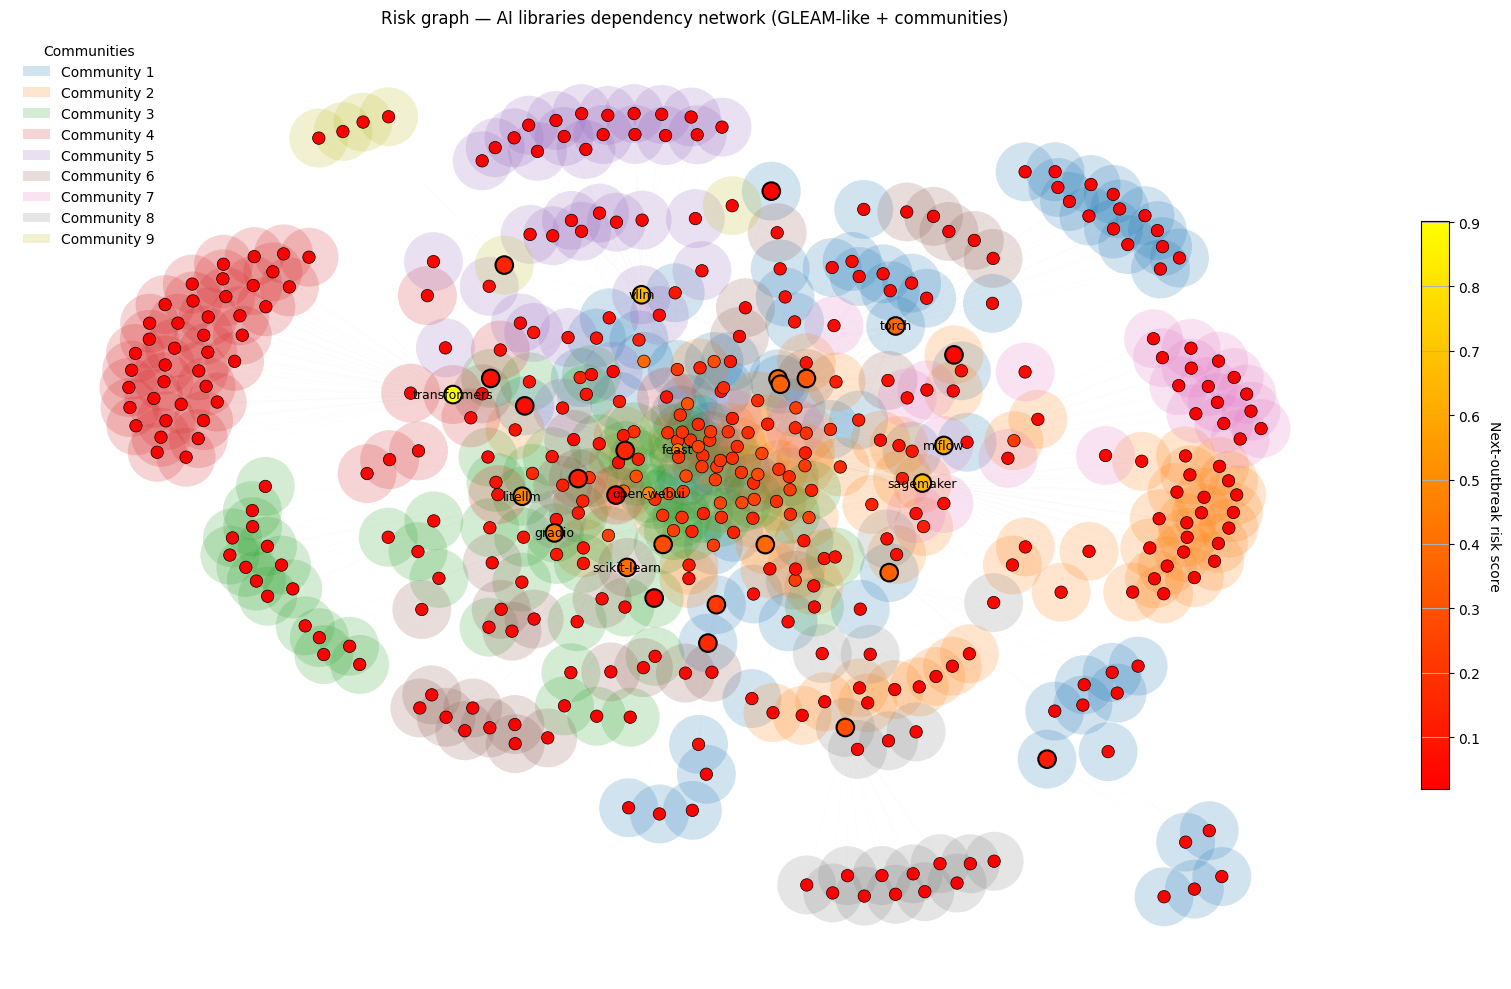

/var/folders/_4/2p4mc4754kdgm56rznlqw1w40000gn/T/ipykernel_59307/153573008.py:611: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_clusters = plt.cm.get_cmap("tab10", n_clusters + 1)


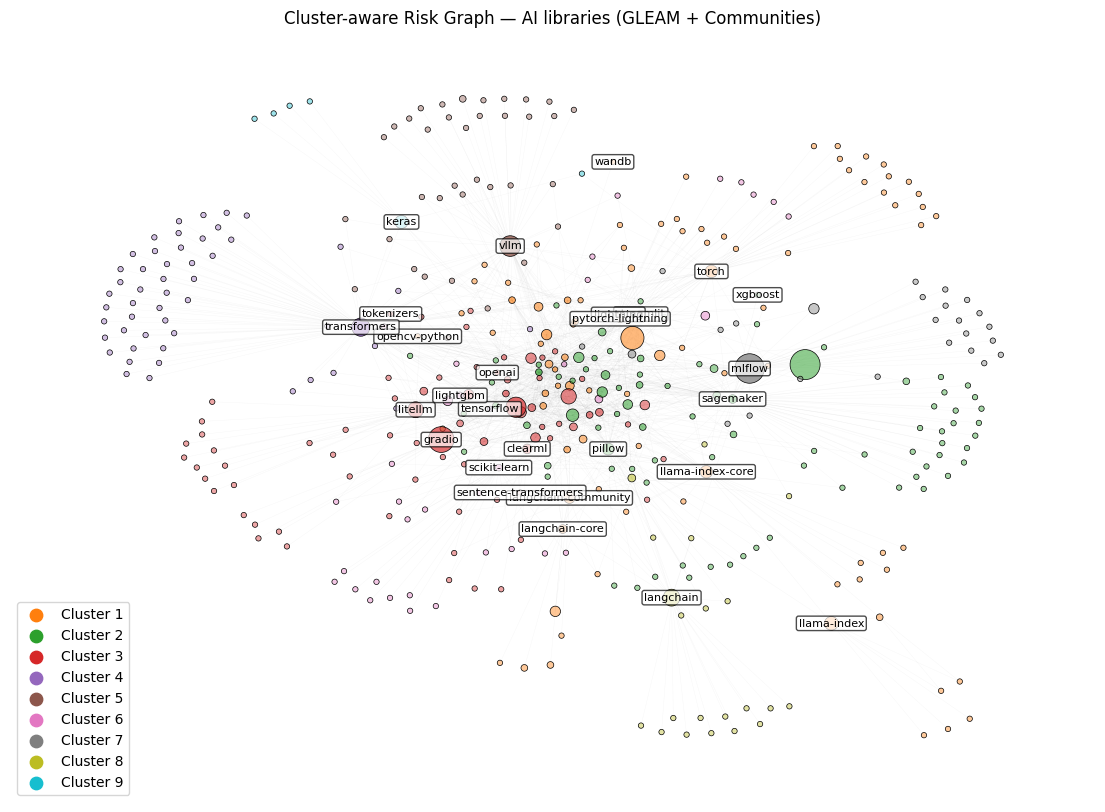

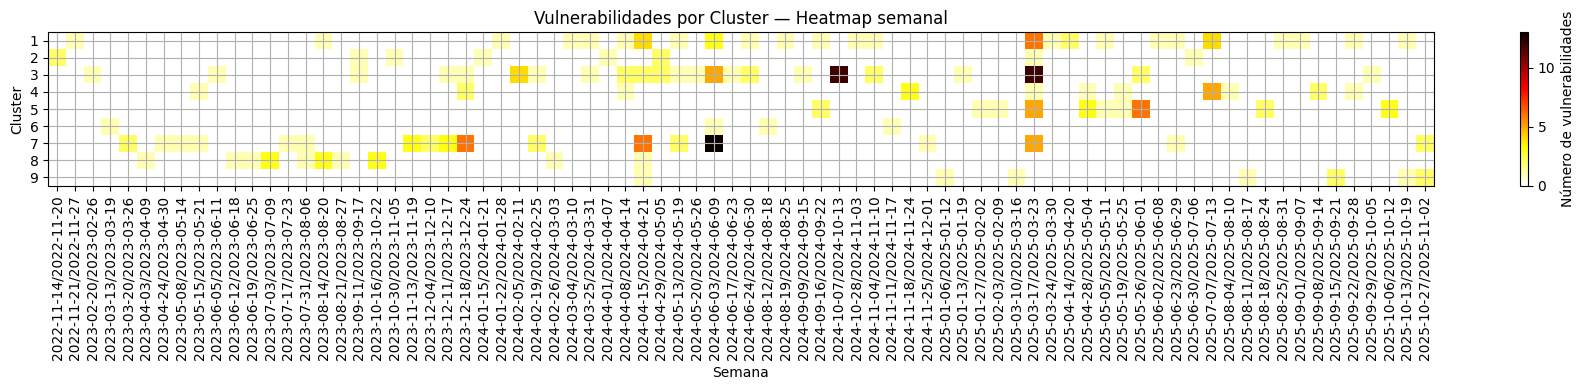

===== NETWORK EPIDEMICS REPORT (AI DEPENDENCIES) =====
Nodes: 427  Edges: 1272
⟨k⟩ = 5.96
⟨k²⟩ = 155.04
Degree exponent α ≈ 1.60
Epidemic threshold λ_c = 0.0384
Chosen β=0.25, μ=0.1, λ=2.500

>> λ/λ_c alto e rede heterogênea → regime endêmico provável.

Top 10 hubs (degree):
          package  degree  in_degree  out_degree  betweenness  k_core  \
347  transformers     106          8          99     0.263782       9   
324     sagemaker      78          1          77     0.168927       9   
191          vllm      69          1          69     0.132432       9   
130         feast      59          0          59     0.055090       9   
381       litellm      49          3          46     0.076706       9   
323        mlflow      45          2          43     0.108352       9   
37         pillow      44         22          22     0.086185       9   
295    open-webui      44          0          44     0.047250       9   
351  scikit-learn      43         10          33     0.085279      

NameError: name 'AI_NODES_H' is not defined

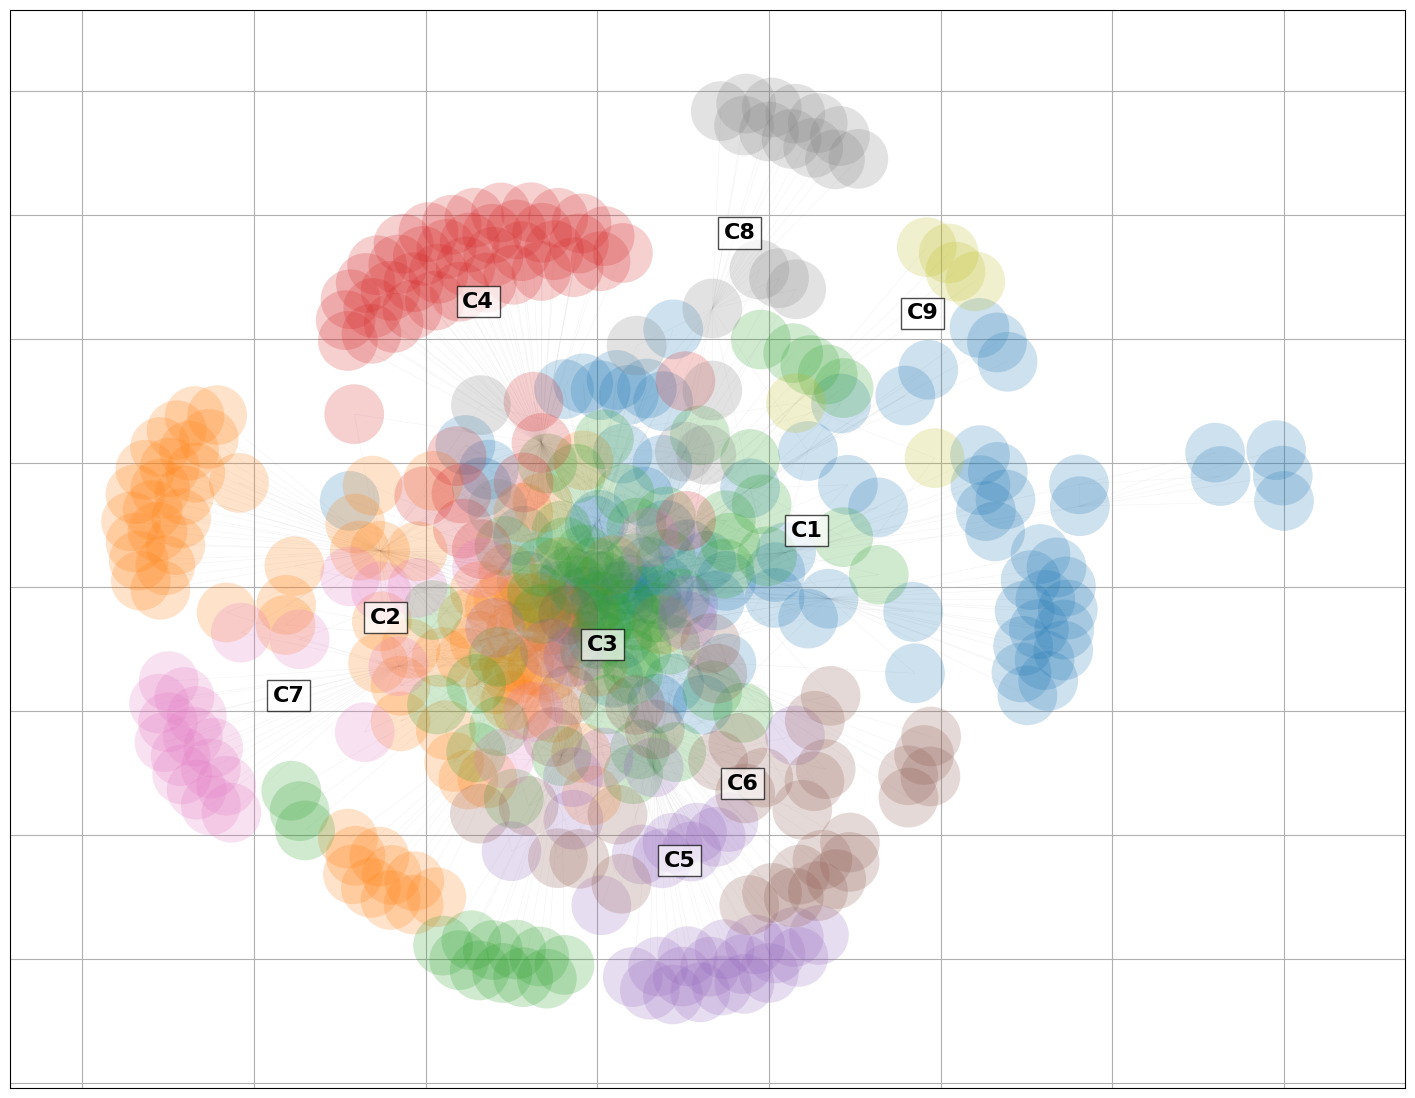

In [66]:
 # %% [markdown]
# # Network Epidemics of AI Libraries (SIS, Scale-Free, Immunization & Prediction)
#
# Metodologia inspirada no Cap. 10 (Network Epidemics), aplicada à rede de
# dependências de bibliotecas de IA (AI_LIBS):
#
# - Teste de rede scale-free (P(k), α, λ_c)
# - Modelo SIS em mean-field (i(t), estado endêmico)
# - SIS na rede real das libs de IA
# - Hubs / super-spreaders (grau, in_degree, out_degree)
# - Bridges entre clusters (betweenness + comunidades)
# - Núcleo estrutural (k-core)
# - Estratégias de vacinação (random x targeted hubs)
# - Padrões bursty (inter-event times de vulnerabilidades)
# - R₀ por pacote e hazard temporal (taxa de novos CVEs)
# - Predição GLEAM-like de próximo surto (risk graph)
#
# Pré-requisitos:
# - CSV de arestas: python_dependencies_edges.csv (source, target)
# - CSV Snyk: outputs/top_pypi_snyk_timeline_20221112_20251112.csv

# %%
import os
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import powerlaw

from collections import Counter
from IPython.display import display
from networkx.algorithms import community
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True


# ==========================
# CONFIGURAÇÃO DE ARQUIVOS
# ==========================
EDGES_PATH = "python_dependencies_edges.csv"
TIMELINE_PATH = "outputs/top_pypi_snyk_timeline_20221112_20251112.csv"

# %% [markdown]
# ## 1. Construir DG_all / UG_all a partir do CSV de dependências

# %%
edges = pd.read_csv(EDGES_PATH)

expected_cols = {"source", "target"}
if not expected_cols.issubset(set(edges.columns)):
    raise ValueError(f"CSV de arestas precisa ter colunas {expected_cols}, mas tem: {edges.columns}")

print("Amostra de arestas:")
display(edges.head())

edges["source"] = edges["source"].astype(str)
edges["target"] = edges["target"].astype(str)

# A -> B se A depende de B
DG_all = nx.DiGraph()
DG_all.add_edges_from(edges[["source", "target"]].itertuples(index=False, name=None))
DG_all.remove_edges_from(list(nx.selfloop_edges(DG_all)))

UG_all = DG_all.to_undirected()
UG_all.remove_edges_from(list(nx.selfloop_edges(UG_all)))

if not nx.is_connected(UG_all):
    largest_cc = max(nx.connected_components(UG_all), key=len)
    UG_clean = UG_all.subgraph(largest_cc).copy()
else:
    UG_clean = UG_all.copy()

print(f"DG_all: {DG_all.number_of_nodes()} nodes, {DG_all.number_of_edges()} edges")
print(f"UG_clean: {UG_clean.number_of_nodes()} nodes, {UG_clean.number_of_edges()} edges")

# %% [markdown]
# ## 2. Definir AI_LIBS e extrair subgrafo 1-hop

# %%
AI_LIBS = [
    'torch','tensorflow','keras','pytorch-lightning','lightning',
    'scikit-learn','xgboost','lightgbm','catboost',
    'transformers','sentence-transformers','tokenizers',
    'langchain','langchain-core','langchain-community',
    'llama-index','llama-index-core',
    'vllm','litellm','openai','mlflow','wandb','clearml','sagemaker',
    'gradio','streamlit','opencv-python','pillow'
]
AI_SET = {p.lower() for p in AI_LIBS}

ai_nodes = {n for n in UG_clean.nodes() if n.lower() in AI_SET}
ai_hop = set(ai_nodes)
for n in ai_nodes:
    ai_hop.update(UG_clean.neighbors(n))

H = UG_clean.subgraph(ai_hop).copy()
print("AI 1-hop subgraph:", H.number_of_nodes(), "nodes,", H.number_of_edges(), "edges")

# %% [markdown]
# ## 3. Carregar timeline Snyk e filtrar AI_LIBS

# %%
timeline = pd.read_csv(TIMELINE_PATH)
timeline.columns = [c.lower() for c in timeline.columns]

if "package" not in timeline.columns:
    raise ValueError(f"CSV Snyk precisa ter coluna 'package'. Colunas: {timeline.columns}")

timeline["package"] = timeline["package"].astype(str).str.lower()

date_candidates = ["disclosed_date", "disclosure_date", "published_date"]
disc_col = None
for c in date_candidates:
    if c in timeline.columns:
        disc_col = c
        break
if disc_col is None:
    raise ValueError(f"Não encontrei coluna de data de divulgação. Colunas: {timeline.columns}")

timeline["disclosed_date"] = pd.to_datetime(timeline[disc_col])

if "end_date_effective" in timeline.columns:
    timeline["end_date_effective"] = pd.to_datetime(timeline["end_date_effective"])
else:
    timeline["end_date_effective"] = timeline["disclosed_date"] + pd.Timedelta(days=365)

timeline_ai = timeline[timeline["package"].isin(AI_SET)].copy()
print("Registros Snyk para AI_LIBS:", len(timeline_ai))
display(timeline_ai.head())

# %% [markdown]
# ## 4. Teste de Scale-Free (P(k), α) e limiar epidêmico λ_c

# %%
degrees = [d for _, d in H.degree()]
k_arr = np.array(degrees)

print("(k)  =", k_arr.mean())
print("(k²) =", (k_arr**2).mean())

k_nonzero = k_arr[k_arr > 0]
fit = powerlaw.Fit(k_nonzero, discrete=True, verbose=False)
alpha = fit.power_law.alpha
xmin = fit.power_law.xmin
R, p = fit.distribution_compare('power_law', 'lognormal')

print(f"α (exponent) = {alpha:.2f}")
print("xmin =", xmin)
print("Power law vs lognormal: R =", R, "p =", p)

fig = fit.plot_pdf(linewidth=2, label="data")
fit.power_law.plot_pdf(ax=fig, linestyle='--', color='black', label='power-law fit')
plt.xlabel("Degree k")
plt.ylabel("P(k)")
plt.title("Degree distribution — AI 1-hop dependency network")
plt.legend()
plt.show()

# P(k) empírico (pontos em log-log)
cnt = Counter(degrees)
k_vals = np.array(sorted(cnt.keys()))
pk_vals = np.array([cnt[k]/len(degrees) for k in k_vals])
plt.figure()
plt.scatter(k_vals, pk_vals)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("k"); plt.ylabel("P(k)")
plt.title("P(k) — distribuição empírica de grau (H)")
plt.grid(True, which="both", ls=":")
plt.show()

lambda_c = k_arr.mean() / ((k_arr**2).mean() + 1e-9)
print(f"\nEpidemic threshold λ_c = {lambda_c:.4f}")
if lambda_c < 0.05:
    print(">> Limiar praticamente zero: típico de rede altamente heterogênea / scale-free.")
else:
    print(">> Limiar mais alto: rede mais próxima de aleatória.")

# %% [markdown]
# ## 5. Modelo SIS mean-field (Cap. 10) para a rede de IA

# %%
k_mean = k_arr.mean()

beta = 0.25
mu = 0.10
lam = beta / mu
print(f"β={beta}, μ={mu}, λ={lam:.3f}, λ/λ_c ≈ {lam/lambda_c:.2f}")

def SIS_mean_field(beta, mu, k_mean, steps=40, i0=0.01):
    i = i0
    hist = [i0]
    for _ in range(steps):
        i = i + beta * k_mean * i * (1 - i) - mu * i
        i = max(0.0, min(1.0, i))
        hist.append(i)
    return np.array(hist)

sis_curve = SIS_mean_field(beta, mu, k_mean, steps=60, i0=0.01)
i_inf = max(0.0, 1 - mu / (beta * k_mean))

t = np.arange(len(sis_curve))
plt.plot(t, sis_curve, color='green', linewidth=3, label="i(t) mean-field")
plt.axhline(i_inf, linestyle='--', color='gray', label=f"i(∞) teórico ≈ {i_inf:.2f}")
plt.xlabel("t (steps)")
plt.ylabel("i(t) — fração de libs vulneráveis")
plt.title("SIS mean-field on AI dependency network")
plt.legend()
plt.show()

# %% [markdown]
# ### 5.1 SIS na rede real (DG_all restrito às libs de IA 1-hop)

# %%
DG_ai = DG_all.subgraph(H.nodes()).copy()
print("DG_ai:", DG_ai.number_of_nodes(), "nodes,", DG_ai.number_of_edges(), "edges")

def simulate_SIS_graph(G: nx.DiGraph, beta=0.25, mu=0.1, steps=40,
                       initial_infected=None, seed=42):
    rng = np.random.default_rng(seed)
    nodes = list(G.nodes())
    infected = {n: False for n in nodes}
    
    if initial_infected is None:
        today = timeline["disclosed_date"].max()
        recency_cut = today - pd.Timedelta(days=365)
        active_pkgs = set(
            timeline_ai[timeline_ai["disclosed_date"] >= recency_cut]["package"].unique()
        )
        initial_infected = [n for n in nodes if n.lower() in active_pkgs]
    if not initial_infected:
        initial_infected = [rng.choice(nodes)]
    
    for n in initial_infected:
        if n in infected:
            infected[n] = True
    
    history = []
    for _ in range(steps):
        new_state = infected.copy()
        for n in nodes:
            if infected[n]:
                if rng.random() < mu:
                    new_state[n] = False
            else:
                for neigh in G.predecessors(n):
                    if infected[neigh] and rng.random() < beta:
                        new_state[n] = True
                        break
        infected = new_state
        history.append(infected.copy())
    
    return history

sis_hist = simulate_SIS_graph(DG_ai, beta=beta, mu=mu, steps=60)
infected_counts = [sum(1 for v in state.values() if v) for state in sis_hist]
frac_infected = np.array(infected_counts) / DG_ai.number_of_nodes()

plt.plot(frac_infected, linewidth=2)
plt.xlabel("t (steps)")
plt.ylabel("fraction infected")
plt.title("SIS simulation on AI 1-hop dependency DiGraph")
plt.show()

# %% [markdown]
# ## 6. Super-spreaders: grau, in_degree, out_degree, betweenness

# %%
deg_dict  = dict(H.degree())
in_dict   = dict(DG_ai.in_degree(H.nodes()))
out_dict  = dict(DG_ai.out_degree(H.nodes()))
bet_dict  = nx.betweenness_centrality(H, normalized=True)

centrality_df = pd.DataFrame({
    "package":   list(H.nodes()),
    "degree":    [deg_dict[n] for n in H.nodes()],
    "in_degree": [in_dict.get(n, 0) for n in H.nodes()],
    "out_degree":[out_dict.get(n, 0) for n in H.nodes()],
    "betweenness":[bet_dict[n] for n in H.nodes()],
})
centrality_df["is_ai"] = centrality_df["package"].str.lower().isin(AI_SET)

print("Top hubs (degree):")
display(centrality_df.sort_values("degree", ascending=False).head(15))

print("\nTop bridges (betweenness):")
display(centrality_df.sort_values("betweenness", ascending=False).head(15))

# %% [markdown]
# ### 6.1 Gráficos: in_degree vs out_degree / out_degree vs degree / betweenness vs degree

# %%
# in_degree vs degree (quem tem muita superfície de ataque vs impacto)
plt.figure(figsize=(8,6))
plt.scatter(centrality_df["degree"], centrality_df["in_degree"],
            color="lightgray", alpha=0.7, label="não-IA")

ai_cent = centrality_df[centrality_df["is_ai"]]
plt.scatter(ai_cent["in_degree"], ai_cent["out_degree"],
            color="red", alpha=0.9, label="AI_LIBS")

for _, row in ai_cent.sort_values("out_degree", ascending=False).head(12).iterrows():
    plt.text(row["in_degree"], row["out_degree"], row["package"],
             fontsize=8, bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="red", lw=0.5))

plt.xlabel("in_degree (dependências que eu consumo)")
plt.ylabel("out_degree (projetos que dependem de mim)")
plt.title("in_degree vs degree — AI em vermelho")
plt.legend()
plt.grid(True)
plt.show()

# out_degree vs degree (quem mais propaga vulnerabilidades)
plt.figure(figsize=(8,6))
plt.scatter(centrality_df["degree"], centrality_df["out_degree"],
            color="lightgray", alpha=0.7, label="não-IA")
plt.scatter(ai_cent["degree"], ai_cent["out_degree"],
            color="red", alpha=0.9, label="AI_LIBS")

for _, row in ai_cent.sort_values("out_degree", ascending=False).head(12).iterrows():
    plt.text(row["degree"], row["out_degree"], row["package"],
             fontsize=8, bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="red", lw=0.5))

plt.xlabel("degree total (não-direcionado)")
plt.ylabel("out_degree (impacto)")
plt.title("Out-degree vs degree — quem mais propaga vulnerabilidades")
plt.legend()
plt.grid(True)
plt.show()

# betweenness vs degree (bridges e hubs)
plt.figure(figsize=(8,6))
plt.scatter(centrality_df["betweenness"], centrality_df["degree"],
            color="lightgray", alpha=0.7, label="não-IA")
plt.scatter(ai_cent["betweenness"], ai_cent["degree"],
            color="red", alpha=0.9, label="AI_LIBS")

for _, row in ai_cent.sort_values("betweenness", ascending=False).head(12).iterrows():
    plt.text(row["betweenness"], row["degree"], row["package"],
             fontsize=8, bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="red", lw=0.5))

plt.xscale("log")
plt.xlabel("betweenness (log)")
plt.ylabel("degree")
plt.title("Betweenness vs degree — bridges e hubs (AI em vermelho)")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.show()

# %% [markdown]
# ## 7. Vaccination Strategies in Scale-Free Networks (AI libs)

# %%
def compute_lambda_c(G):
    k = np.array([d for _, d in G.degree()])
    return k.mean() / ((k**2).mean() + 1e-9)

orig_lambda_c = compute_lambda_c(H)
N = H.number_of_nodes()
cut = max(1, int(N * 0.05))   # 5% dos nós

top_hubs = centrality_df.sort_values("degree", ascending=False)["package"].head(cut).tolist()
H_target = H.copy()
H_target.remove_nodes_from(top_hubs)
lambda_target = compute_lambda_c(H_target)

rng = np.random.default_rng(42)
rand_nodes = rng.choice(list(H.nodes()), size=cut, replace=False)
H_random = H.copy()
H_random.remove_nodes_from(rand_nodes)
lambda_random = compute_lambda_c(H_random)

print(f"Original λ_c  : {orig_lambda_c:.4f}")
print(f"Random   λ_c  : {lambda_random:.4f} (imunização aleatória)")
print(f"Targeted λ_c  : {lambda_target:.4f} (imunizando hubs)")

labels = ["Original", "Random", "Targeted"]
vals = [orig_lambda_c, lambda_random, lambda_target]

plt.figure(figsize=(6,4))
plt.bar(labels, vals, color=["gray", "green", "purple"])
plt.ylabel("λ_c")
plt.title("Effect of immunization strategies on epidemic threshold")
plt.show()

# %% [markdown]
# ## 8. Bursty Contact Patterns (inter-event times de vulnerabilidades)

# %%
def inter_event_times(pkg, df):
    s = df[df["package"] == pkg].sort_values("disclosed_date")["disclosed_date"]
    if len(s) < 3:
        return None
    return s.diff().dt.days.dropna()

def plot_burstiness(pkg):
    tau = inter_event_times(pkg, timeline_ai)
    print(f"\n==== {pkg} ====")
    if tau is None or len(tau) == 0:
        print("Poucos eventos para analisar.")
        return
    tau = tau[tau > 0]
    if len(tau) == 0:
        print("Intervalos nulos.")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1.plot(range(len(tau)), tau.values, linewidth=1)
    ax1.set_title(f"Delay times sequence — {pkg}")
    ax1.set_xlabel("event index")
    ax1.set_ylabel("Δt (days)")
    
    ax2.hist(tau.values, bins=20, density=True)
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    ax2.set_title("P(τ)")
    ax2.set_xlabel("τ (days)")
    plt.suptitle(f"Burstiness of vulnerabilities — {pkg}")
    plt.tight_layout()
    plt.show()

for pkg in ["transformers", "torch", "litellm", "pillow"]:
    plot_burstiness(pkg)

# %% [markdown]
# ## 9. Comunidades, k-core e métricas epidemiológicas (R₀, hazard)

# %%
# Comunidades (no H não-direcionado)
try:
    comms = list(community.greedy_modularity_communities(H))
except Exception:
    comms = [set(H.nodes())]

comm_id = {}
for i, cset in enumerate(comms):
    for n in cset:
        comm_id[n] = i + 1   # Cluster C1, C2, ...

centrality_df["community"] = centrality_df["package"].map(comm_id).fillna(0).astype(int)

# k-core (núcleo estrutural)
core_num = nx.core_number(H)
centrality_df["k_core"] = centrality_df["package"].map(core_num).fillna(0).astype(int)

# R0 por pacote (aprox: β * out_degree)
centrality_df["R0_pkg"] = beta * centrality_df["out_degree"]

# Hazard temporal: taxa de novos CVEs nos últimos 3 anos
max_date = timeline["disclosed_date"].max()
window_days = 365 * 3
start_window = max_date - pd.Timedelta(days=window_days)
recent = timeline[timeline["disclosed_date"] >= start_window]

haz_counts = recent.groupby("package").size()
hazard_map = (haz_counts / (window_days / 30.0))  # eventos por ~mês
centrality_df["hazard_rate"] = centrality_df["package"].str.lower().map(hazard_map).fillna(0.0)

print("Exemplo de métricas avançadas (top 15 por degree):")
display(centrality_df.sort_values("degree", ascending=False)
        .head(15)[["package","degree","in_degree","out_degree","betweenness",
                   "k_core","community","R0_pkg","hazard_rate","is_ai"]])

# %% [markdown]
# ## 10. GLEAM-like Prediction: risk score final (estrutural + temporal)

# %%
# normalizações
centrality_df["deg_norm"]   = centrality_df["degree"]     / (centrality_df["degree"].max() or 1)
centrality_df["out_norm"]   = centrality_df["out_degree"] / (centrality_df["out_degree"].max() or 1)
centrality_df["bet_norm"]   = centrality_df["betweenness"]/ (centrality_df["betweenness"].max() or 1)
centrality_df["core_norm"]  = centrality_df["k_core"]     / (centrality_df["k_core"].max() or 1)
centrality_df["haz_norm"]   = centrality_df["hazard_rate"]/ (centrality_df["hazard_rate"].max() or 1 if centrality_df["hazard_rate"].max()>0 else 1)
centrality_df["R0_norm"]    = centrality_df["R0_pkg"]     / (centrality_df["R0_pkg"].max() or 1)

# combinação (ajuste pesos se quiser)
centrality_df["risk_score"] = (
    0.20 * centrality_df["deg_norm"]   +
    0.20 * centrality_df["out_norm"]   +
    0.20 * centrality_df["bet_norm"]   +
    0.15 * centrality_df["core_norm"]  +
    0.15 * centrality_df["haz_norm"]   +
    0.10 * centrality_df["R0_norm"]
)

print("Top 15 libs por risco de próximo surto (risk_score):")
display(centrality_df.sort_values("risk_score", ascending=False).head(15))

# %% [markdown]
# ### 10.1 Risk Graph — grafo colorido por risco (bibliotecas de IA)

# %%
# %% [markdown]
# ### 10.1 Risk Graph — grafo colorido por risco + clusters (halos, sem rótulo C1/C2)

# %%

pos = nx.spring_layout(H, seed=42)

risk_map = centrality_df.set_index("package")["risk_score"]

fig, ax = plt.subplots(figsize=(14, 10))

# comunidades para halos
try:
    comms = list(community.greedy_modularity_communities(H))
except Exception:
    comms = [set(H.nodes())]

palette_comm = list(mcolors.TABLEAU_COLORS.values())

# halos por comunidade (SEM escrever C1, C2... dentro do grafo)
for i, cset in enumerate(sorted(comms, key=len, reverse=True)):
    ccol = mcolors.to_rgba(palette_comm[i % len(palette_comm)], alpha=0.20)
    nx.draw_networkx_nodes(
        H, pos,
        nodelist=list(cset),
        node_size=1800,
        node_color=[ccol],
        edgecolors="none",
        ax=ax
    )

# arestas
nx.draw_networkx_edges(
    H, pos, ax=ax,
    alpha=0.10, width=0.3, edge_color="lightgray"
)

# nós coloridos por risk_score
risk_vals = [risk_map.get(n, 0.0) for n in H.nodes()]
cmap = plt.colormaps.get_cmap("autumn")

nodes = nx.draw_networkx_nodes(
    H, pos, ax=ax,
    node_color=risk_vals,
    cmap=cmap,
    node_size=80,
    linewidths=0.5,
    edgecolors="black"
)

# destaque para AI_LIBS (nó maior + borda mais grossa)
ai_border_nodes = [n for n in H.nodes() if n.lower() in AI_SET]
nx.draw_networkx_nodes(
    H, pos, nodelist=ai_border_nodes,
    node_color=[risk_map.get(n, 0.0) for n in ai_border_nodes],
    cmap=cmap,
    node_size=160,
    linewidths=1.5,
    edgecolors="black",
    ax=ax
)

# rótulos só para top 10 risk_score
top_risk = (
    centrality_df.sort_values("risk_score", ascending=False)
    .head(10)["package"].tolist()
)
labels = {n: n for n in H.nodes() if n in top_risk}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=9, ax=ax)

# colorbar do risco em um eixo separado, à direita
cax = inset_axes(
    ax,
    width="2%",       # largura relativa
    height="60%",     # altura relativa
    loc="center right",
    bbox_to_anchor=(0.05, 0., 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0.0
)
cbar = fig.colorbar(nodes, cax=cax)
cbar.set_label("Next-outbreak risk score", rotation=270, labelpad=15)

# legenda de comunidades, AGORA dentro do gráfico (canto superior esquerdo)
comm_handles = [
    Patch(
        facecolor=mcolors.to_rgba(palette_comm[i % len(palette_comm)], alpha=0.20),
        edgecolor='none',
        label=f"Community {i+1}"
    )
    for i, _ in enumerate(sorted(comms, key=len, reverse=True))
]

leg1 = ax.legend(
    handles=comm_handles,
    title="Communities",
    frameon=False,
    loc='upper left'  # longe da colorbar
)

ax.set_title("Risk graph — AI libraries dependency network (GLEAM-like + communities)")
ax.axis("off")
plt.tight_layout()
plt.show()



# === 10.x Clustered Risk Graph (AI dependencies) ===

# usamos as comunidades já calculadas:
cluster_map = centrality_df.set_index("package")["community"]

# paleta de cores por comunidade
n_clusters = cluster_map.max()
cmap_clusters = plt.cm.get_cmap("tab10", n_clusters + 1)

# coordenadas do layout já existentes
pos = nx.spring_layout(H, seed=42)

fig, ax = plt.subplots(figsize=(14, 10))

# desenhar arestas
nx.draw_networkx_edges(
    H, pos, ax=ax, alpha=0.07, width=0.3, edge_color="gray"
)

# cor = cluster, tamanho = hazard, transparência = idade média das vulnerabilidades
haz = centrality_df.set_index("package")["hazard_rate"]
risk = centrality_df.set_index("package")["risk_score"]

node_colors = [cmap_clusters(cluster_map.get(n, 0)) for n in H.nodes()]
node_sizes = [300 * (haz.get(n, 0) + 0.05) for n in H.nodes()]
node_alpha = [0.4 + 0.6 * risk.get(n, 0) for n in H.nodes()]

nodes = nx.draw_networkx_nodes(
    H, pos,
    node_color=node_colors,
    node_size=node_sizes,
    alpha=node_alpha,
    edgecolors="black",
    linewidths=0.5
)

# rotular apenas AI
labels = {n: n for n in H.nodes() if n.lower() in AI_SET}
# labels = {n: n for n in H.nodes()}  # rótulo em todos

nx.draw_networkx_labels(
    H, pos, labels=labels,
    font_size=8, font_color="black",
    bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7)
)

ax.set_title("Cluster-aware Risk Graph — AI libraries (GLEAM + Communities)")
ax.axis("off")

# legenda dos clusters
for c_id in range(1, n_clusters + 1):
    ax.scatter([], [], color=cmap_clusters(c_id), label=f"Cluster {c_id}", s=80)
ax.legend(loc="lower left")

plt.show()


# === 10.y Timeline heatmap (Cluster vs Weeks) ===

timeline_ai["week"] = timeline_ai["disclosed_date"].dt.to_period("W").astype(str)
timeline_ai["cluster"] = timeline_ai["package"].map(cluster_map)

cluster_week = (
    timeline_ai.groupby(["cluster", "week"]).size().unstack(fill_value=0)
)

plt.figure(figsize=(18, 4))
plt.imshow(cluster_week, aspect="auto", cmap="hot_r")
plt.colorbar(label="Número de vulnerabilidades")
plt.yticks(range(len(cluster_week.index)), cluster_week.index)
plt.xticks(range(len(cluster_week.columns)), cluster_week.columns, rotation=90)
plt.title("Vulnerabilidades por Cluster — Heatmap semanal")
plt.xlabel("Semana")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


# %% [markdown]
# ## 11. Relatório final estilo Capítulo 10

# %%
print("===== NETWORK EPIDEMICS REPORT (AI DEPENDENCIES) =====")
print(f"Nodes: {H.number_of_nodes()}  Edges: {H.number_of_edges()}")
print(f"⟨k⟩ = {k_arr.mean():.2f}")
print(f"⟨k²⟩ = {(k_arr**2).mean():.2f}")
print(f"Degree exponent α ≈ {alpha:.2f}")
print(f"Epidemic threshold λ_c = {lambda_c:.4f}")
print(f"Chosen β={beta}, μ={mu}, λ={lam:.3f}")
print("\n>> λ/λ_c alto e rede heterogênea → regime endêmico provável.")

print("\nTop 10 hubs (degree):")
print(centrality_df.sort_values("degree", ascending=False)
      .head(10)[["package", "degree", "in_degree", "out_degree", "betweenness",
                 "k_core","community"]])

print("\nTop 10 predicted next-outbreak libs (risk_score):")
print(centrality_df.sort_values("risk_score", ascending=False)
      .head(10)[["package", "risk_score","degree","out_degree",
                 "betweenness","k_core","R0_pkg","hazard_rate","community","is_ai"]])


# %% [markdown]
# ## 12. Snapshots pré-GLEAM — clusters de IA com severidade por ano (2023–2025)

# %%
# Garantir datas extras para severidade
for c in ["first_affected_date", "mitigation_date"]:
    if c in timeline.columns:
        timeline[c] = pd.to_datetime(timeline[c], errors="coerce")

# função de severidade por ano (pacote está "ativo" se vulnerabilidade atinge aquele ano)
sev_rank = {"low": 1, "medium": 2, "moderate": 2, "high": 3, "critical": 4}
sev_label = {1: "low", 2: "medium", 3: "high", 4: "critical"}

def pkg_severity_for_year(y: int):
    start_y = pd.Timestamp(f"{y}-01-01")
    end_y   = pd.Timestamp(f"{y}-12-31")

    start = timeline.get("first_affected_date", timeline["disclosed_date"])
    end   = timeline.get("mitigation_date", timeline["end_date_effective"])

    start = pd.to_datetime(start, errors="coerce")
    end   = pd.to_datetime(end, errors="coerce")

    mask = start.notna() & (start <= end_y) & ( (end.isna()) | (end >= start_y) )
    sub = timeline.loc[mask, ["package", "severity"]].copy()

    sub["sev_r"] = (
        sub["severity"].astype(str).str.lower()
        .map(sev_rank).fillna(0).astype(int)
    )
    g = sub.groupby("package")["sev_r"].max().reset_index()
    g["label"] = g["sev_r"].map(sev_label).fillna("unknown")
    return dict(zip(g["package"], g["label"]))

# layout e tamanhos (indegree de DG_all)
k = 1 / np.sqrt(max(1, H.number_of_nodes()))
pos_snap = nx.spring_layout(H, k=k*3, iterations=450, seed=23)
indeg_snap = dict(DG_all.in_degree(H.nodes()))
sizes_snap = np.array([max(1, indeg_snap.get(n, 0)) for n in H.nodes()], dtype=float)
p95 = np.percentile(sizes_snap, 95) if sizes_snap.size and sizes_snap.max() > 0 else 1.0
sizes_snap = (sizes_snap / p95 * 500).clip(10, 900)

palette_comm = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
sev_color = {
    "critical": "#d73027",
    "high":     "#fc8d59",
    "medium":   "#fee08b",
    "low":      "#91bfdb",
    "unknown":  "#d0d3d4",
}

AI_NODES_H = [n for n in H.nodes() if n.lower() in AI_SET]


def draw_year_snapshot(y: int):
    sev_y = pkg_severity_for_year(y)
    active = {n for n in H.nodes if sev_y.get(n, "unknown") != "unknown"}

    # comunidades fixas no H (halo)
    try:
        comms_y = list(community.greedy_modularity_communities(H))
    except Exception:
        comms_y = [set(H.nodes())]

    fig, ax = plt.subplots(1, 1, figsize=(18, 14))

    # --- Halos por comunidade, estilo "cluster completo" ---
    halo_size = 1850
    for i, cset in enumerate(sorted(comms_y, key=len, reverse=True)):
        ccol = mcolors.to_rgba(palette_comm[i % len(palette_comm)], alpha=0.22)
        nodes_comm = list(cset)

        nx.draw_networkx_nodes(
            H, pos_snap,
            nodelist=nodes_comm,
            node_size=halo_size,
            node_color=[ccol] * len(nodes_comm),
            edgecolors="none",
            ax=ax
        )

        # label C1, C2... centralizado no cluster
        xx = [pos_snap[n][0] for n in nodes_comm]
        yy = [pos_snap[n][1] for n in nodes_comm]
        cx, cy = np.mean(xx), np.mean(yy)
        ax.text(
            cx, cy, f"C{i+1}",
            bbox=dict(facecolor="white", alpha=0.7),
            ha="center", fontsize=16, fontweight="bold"
        )

    # --- Arestas da rede ---
    nx.draw_networkx_edges(
        H, pos_snap, ax=ax,
        width=0.35, alpha=0.14, edge_color="#9e9e9e"
    )

    nodes = list(H.nodes())
    idx = {n: i for i, n in enumerate(nodes)}

    # separa ativos/inativos e IA/não-IA
    inact = [n for n in nodes if n not in active]
    act   = [n for n in nodes if n in active]

    inact_ai   = [n for n in inact if n in AI_NODES_H]
    inact_non  = [n for n in inact if n not in AI_NODES_H]
    act_ai     = [n for n in act   if n in AI_NODES_H]
    act_non    = [n for n in act   if n not in AI_NODES_H]

    # --- Nós inativos (cinza) ---
    if inact_non:
        nx.draw_networkx_nodes(
            H, pos_snap, nodelist=inact_non,
            node_size=[sizes_snap[idx[n]] for n in inact_non],
            node_color=[sev_color["unknown"]] * len(inact_non),
            edgecolors="#bbbbbb",
            linewidths=0.25,
            alpha=0.18,
            ax=ax
        )
    if inact_ai:
        nx.draw_networkx_nodes(
            H, pos_snap, nodelist=inact_ai,
            node_size=[sizes_snap[idx[n]] for n in inact_ai],
            node_color=[sev_color["unknown"]] * len(inact_ai),
            edgecolors="black",      # borda mais forte para IA
            linewidths=1.2,
            alpha=0.25,
            ax=ax
        )

    # --- Nós ativos coloridos por severidade ---
    def color_for(n):
        lbl = str(sev_y.get(n, "unknown")).lower()
        return sev_color.get(lbl, sev_color["unknown"])

    if act_non:
        nx.draw_networkx_nodes(
            H, pos_snap, nodelist=act_non,
            node_size=[sizes_snap[idx[n]] for n in act_non],
            node_color=[color_for(n) for n in act_non],
            edgecolors="black",
            linewidths=0.7,
            alpha=0.98,
            ax=ax
        )
    if act_ai:
        # IA ativa: mesmo esquema, mas um pouquinho maior e com borda mais grossa
        nx.draw_networkx_nodes(
            H, pos_snap, nodelist=act_ai,
            node_size=[sizes_snap[idx[n]] * 1.15 for n in act_ai],
            node_color=[color_for(n) for n in act_ai],
            edgecolors="black",
            linewidths=1.4,
            alpha=0.98,
            ax=ax
        )

    # --- Labels dos hubs (top in-degree) ---
    hubs = sorted(indeg_snap.items(), key=lambda x: x[1], reverse=True)[:20]
    nx.draw_networkx_labels(
        H, pos_snap,
        labels={n: n for n, _ in hubs},
        font_size=9, font_weight="bold", ax=ax
    )

    # --- Legenda: clusters + severidade + IA ---
    comm_handles = []
    for i, cset in enumerate(sorted(comms_y, key=len, reverse=True)):
        comm_col = mcolors.to_rgba(palette_comm[i % len(palette_comm)], alpha=0.22)
        comm_handles.append(
            Patch(facecolor=comm_col, edgecolor="#252525", label=f"Cluster C{i+1}")
        )

    severity_handles = [
        Patch(facecolor=sev_color["critical"], edgecolor="black", label="critical"),
        Patch(facecolor=sev_color["high"],     edgecolor="black", label="high"),
        Patch(facecolor=sev_color["medium"],   edgecolor="black", label="medium"),
        Patch(facecolor=sev_color["low"],      edgecolor="black", label="low"),
        Patch(facecolor=sev_color["unknown"],  edgecolor="black", label="no CVE in year"),
        Patch(facecolor="white", edgecolor="black", label="AI (bold border)"),
    ]

    all_handles = comm_handles + severity_handles
    ax.legend(
        handles=all_handles,
        title=f"{y} — Clusters & Severity",
        frameon=False,
        loc="lower left",
        ncol=2,
        fontsize=11
    )

    subtitle = f"Nodes={H.number_of_nodes()}  Edges={H.number_of_edges()}  Active={len(active)}"
    ax.set_title(
        f"AI network — 1-hop, active in {y} (color = severity)  |  {subtitle}",
        fontsize=14, fontweight="bold"
    )
    ax.axis("off")
    plt.tight_layout()

    out_png = f"outputs/plots/dependency_ai_snapshot_{y}.png"
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", out_png)

 

for Y in [2023, 2024, 2025]:
    draw_year_snapshot(Y)


# %% [markdown]
# ## 12.4 Hierarchical dependency trees for top AI libraries (dependents vs dependencies)

# %%
import math

# mapa de severidade "global" por pacote (pior severidade observada no período)
sev_rank_global = {"low": 1, "medium": 2, "moderate": 2, "high": 3, "critical": 4}
sev_label_global = {1: "low", 2: "medium", 3: "high", 4: "critical"}

if "severity" in timeline.columns:
    tmp = timeline.copy()
    tmp["sev_r"] = (
        tmp["severity"].astype(str).str.lower()
        .map(sev_rank_global).fillna(0).astype(int)
    )
    best = tmp.groupby("package")["sev_r"].max()
    pkg_sev = {
        pkg: sev_label_global.get(val, "unknown")
        for pkg, val in best.items()
    }
else:
    pkg_sev = {}

color_map = {
    "critical": "#d73027",
    "high":     "#fc8d59",
    "medium":   "#fee08b",
    "low":      "#91bfdb",
    "unknown":  "#bdbdbd",
}
sev_alias = {"moderate": "medium"}

def sev_color(pkg: str) -> str:
    s = str(pkg_sev.get(pkg.lower(), "unknown")).lower()
    s = sev_alias.get(s, s)
    return color_map.get(s, color_map["unknown"])

# ---------- Layout: layered (x = profundidade) ----------

def layered_positions(layers, x_gap: float = 1.0, y_gap: float = 1.0):
    pos = {}
    for depth, nodes in enumerate(layers):
        if not nodes:
            continue
        y_start = -(len(nodes) - 1) * y_gap / 2.0
        for i, n in enumerate(sorted(nodes)):
            pos[n] = (depth * x_gap, y_start + i * y_gap)
    return pos

# ---------- BFS layers (successors = dependencies; predecessors = dependents) ----------

from collections import deque

def bfs_layers(G: nx.DiGraph, root: str, direction: str, max_hops: int, max_nodes: int):
    assert direction in ("successors", "predecessors")
    visited = {root: 0}
    q = deque([root])

    while q and len(visited) < max_nodes:
        u = q.popleft()
        d = visited[u]
        if d >= max_hops:
            continue
        neigh = G.successors(u) if direction == "successors" else G.predecessors(u)
        for v in neigh:
            if v not in visited:
                visited[v] = d + 1
                q.append(v)
                if len(visited) >= max_nodes:
                    break

    max_d = max(visited.values()) if visited else 0
    layers = [[] for _ in range(max_d + 1)]
    for n, depth in visited.items():
        layers[depth].append(n)
    return layers

# ---------- Desenhar árvore ----------

def draw_tree(root: str, layers, direction: str, out_png: str,
              right_to_left: bool = False, title: str = ""):
    nodes = [n for layer in layers for n in layer]
    H_sub = DG_all.subgraph(nodes).copy()

    pos = layered_positions(layers, x_gap=1.6, y_gap=0.6)
    if right_to_left:
        pos = {n: (-x, y) for n, (x, y) in pos.items()}

    fig, ax = plt.subplots(1, 1, figsize=(18, 12))

    edges = [(u, v) for u, v in H_sub.edges() if u in pos and v in pos]
    nx.draw_networkx_edges(
        H_sub, pos, edgelist=edges,
        width=0.6, alpha=0.25, edge_color="#c0b7c1", ax=ax
    )

    sizes = []
    colors = []
    for n in H_sub.nodes():
        deg_in = max(1, DG_all.in_degree(n))
        sizes.append(min(1000, 120 + deg_in * 14))
        colors.append(sev_color(n))

    nx.draw_networkx_nodes(
        H_sub, pos,
        node_size=sizes,
        node_color=colors,
        edgecolors="#7a4e6a",
        linewidths=0.7,
        alpha=0.98,
        ax=ax
    )

    labels_all = {n: n for n in H_sub.nodes()}
    labels = labels_all if direction != "successors" else {root: root}
    nx.draw_networkx_labels(
        H_sub, pos,
        labels=labels,
        font_size=7,
        font_weight="bold",
        ax=ax
    )

    # destacar raiz
    if root in pos:
        nx.draw_networkx_nodes(
            H_sub, pos,
            nodelist=[root],
            node_size=1400,
            node_color=sev_color(root),
            edgecolors="black",
            linewidths=1.4,
            ax=ax
        )

    # legenda de severidade (aparece em todas as árvores)
    sev_handles = [
        Patch(facecolor=color_map["critical"], edgecolor="black", label="critical"),
        Patch(facecolor=color_map["high"],     edgecolor="black", label="high"),
        Patch(facecolor=color_map["medium"],   edgecolor="black", label="medium"),
        Patch(facecolor=color_map["low"],      edgecolor="black", label="low"),
        Patch(facecolor=color_map["unknown"],  edgecolor="black", label="no CVE"),
    ]
    ax.legend(
        handles=sev_handles,
        title="Package severity",
        frameon=False,
        loc="lower left"
    )


    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved", out_png)

# ---------- Escolher seeds de IA por in_degree e out_degree ----------

AI_IN_DEGREE_TOP_K = 5
AI_OUT_DEGREE_TOP_K = 5
MAX_HOPS = 4
MAX_NODES = 500

ai_nodes_all = [p.lower() for p in AI_LIBS if p.lower() in DG_all]

indeg_ai = sorted(
    [(n, DG_all.in_degree(n)) for n in ai_nodes_all],
    key=lambda x: x[1],
    reverse=True
)[:AI_IN_DEGREE_TOP_K]

outdeg_ai = sorted(
    [(n, DG_all.out_degree(n)) for n in ai_nodes_all],
    key=lambda x: x[1],
    reverse=True
)[:AI_OUT_DEGREE_TOP_K]

os.makedirs("outputs/plots", exist_ok=True)

# árvores de dependentes (impacto)
for n, _ in indeg_ai:
    layers = bfs_layers(DG_all, n, direction="predecessors",
                        max_hops=MAX_HOPS, max_nodes=MAX_NODES)
    title = f"{n} — dependents tree (influence)"
    draw_tree(
        n, layers, "predecessors",
        f"outputs/plots/tree_dependents_{n}.png",
        right_to_left=True,
        title=title
    )

# árvores de dependências (superfície de exposição)
for n, _ in outdeg_ai:
    layers = bfs_layers(DG_all, n, direction="successors",
                        max_hops=MAX_HOPS, max_nodes=MAX_NODES)
    title = f"{n} — dependencies tree (exposure)"
    draw_tree(
        n, layers, "successors",
        f"outputs/plots/tree_dependencies_{n}.png",
        right_to_left=False,
        title=title
    )

